In [1]:
#some code for checking gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import os
import tqdm
import pandas as pd
import time, warnings
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
from PIL import Image
from sklearn.model_selection import KFold
import keras_tuner
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.trial import Trial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import random
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
)
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow import image
import warnings
warnings.filterwarnings("ignore")

In [25]:

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/processed_data.csv')
    folds = {}
    for class_label in range(1, 11):
        class_folder_path = os.path.join(root_folder, f"fold{class_label}")
        image_data = []
        all_labels = []
        if not os.path.exists(class_folder_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(class_folder_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(class_folder_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (36, 320):
                      continue
                    image_array = normalize(image_array)
                    #image_array = tensorflow.image.grayscale_to_rgb(image_array)
                    #print(image_array.shape)
                    image_array = np.ndarray(shape=(image_array.shape[0], image_array.shape[1], 3), dtype= np.uint8)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    #print(f'Double check: image {new_filename} has label {label}')
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels - 1, num_classes=10)
        tensorflow.convert_to_tensor(image_data)
        tensorflow.convert_to_tensor(all_labels)
        folds[f"fold{class_label}"] = [image_data, all_labels]
    return folds


root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/melspec"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
#input_shape = input_shape + (3,)
print(input_shape)

  2%|▏         | 16/873 [00:00<00:05, 148.93it/s]

Double check: image 101415-3-0-2.wav has label 3
Double check: image 101415-3-0-3.wav has label 3
Double check: image 101415-3-0-8.wav has label 3
Double check: image 102106-3-0-0.wav has label 3
Double check: image 102305-6-0-0.wav has label 6
Double check: image 102842-3-0-1.wav has label 3
Double check: image 102842-3-1-5.wav has label 3
Double check: image 102842-3-1-0.wav has label 3
Double check: image 102842-3-1-6.wav has label 3
Double check: image 103074-7-0-0.wav has label 7
Double check: image 103074-7-0-1.wav has label 7
Double check: image 103074-7-0-2.wav has label 7
Double check: image 103074-7-1-0.wav has label 7
Double check: image 103074-7-1-2.wav has label 7
Double check: image 103074-7-1-1.wav has label 7
Double check: image 103074-7-1-4.wav has label 7
Double check: image 103074-7-1-3.wav has label 7
Double check: image 103074-7-1-6.wav has label 7
Double check: image 103074-7-1-5.wav has label 7
Double check: image 103074-7-2-0.wav has label 7
Double check: image 

  5%|▌         | 45/873 [00:00<00:06, 129.56it/s]

Double check: image 103074-7-4-3.wav has label 7
Double check: image 103074-7-4-6.wav has label 7
Double check: image 103074-7-4-5.wav has label 7
Double check: image 103258-5-0-0.wav has label 5
Double check: image 103258-5-0-1.wav has label 5
Double check: image 103258-5-0-10.wav has label 5
Double check: image 103258-5-0-11.wav has label 5
Double check: image 103258-5-0-12.wav has label 5
Double check: image 103258-5-0-13.wav has label 5
Double check: image 103258-5-0-14.wav has label 5
Double check: image 103258-5-0-15.wav has label 5
Double check: image 103258-5-0-16.wav has label 5
Double check: image 103258-5-0-17.wav has label 5
Double check: image 103258-5-0-18.wav has label 5
Double check: image 103258-5-0-2.wav has label 5
Double check: image 103258-5-0-19.wav has label 5
Double check: image 103258-5-0-4.wav has label 5
Double check: image 103258-5-0-3.wav has label 5
Double check: image 103258-5-0-6.wav has label 5
Double check: image 103258-5-0-5.wav has label 5
Double che

  8%|▊         | 72/873 [00:00<00:06, 126.09it/s]


Double check: image 105415-2-0-21.wav has label 2
Double check: image 105415-2-0-19.wav has label 2
Double check: image 105415-2-0-24.wav has label 2
Double check: image 105415-2-0-4.wav has label 2
Double check: image 105415-2-0-6.wav has label 2
Double check: image 105415-2-0-8.wav has label 2
Double check: image 106905-8-0-0.wav has label 8
Double check: image 106905-8-0-1.wav has label 8
Double check: image 106905-8-0-2.wav has label 8
Double check: image 106905-8-0-3.wav has label 8
Double check: image 108041-9-0-11.wav has label 9
Double check: image 108041-9-0-2.wav has label 9
Double check: image 108041-9-0-4.wav has label 9
Double check: image 108041-9-0-5.wav has label 9
Double check: image 108041-9-0-6.wav has label 9
Double check: image 108041-9-0-9.wav has label 9
Double check: image 108041-9-0-7.wav has label 9
Double check: image 108362-2-0-11.wav has label 2
Double check: image 108362-2-0-12.wav has label 2
Double check: image 108362-2-0-21.wav has label 2
Double check

 14%|█▎        | 119/873 [00:00<00:04, 188.08it/s]


Double check: image 113205-5-0-0.wav has label 5
Double check: image 113205-5-1-1.wav has label 5
Double check: image 113205-5-1-2.wav has label 5
Double check: image 113205-5-1-3.wav has label 5
Double check: image 113205-5-1-4.wav has label 5
Double check: image 113205-5-1-5.wav has label 5
Double check: image 113205-5-1-6.wav has label 5
Double check: image 113205-5-1-7.wav has label 5
Double check: image 113205-5-1-8.wav has label 5
Double check: image 113205-5-1-9.wav has label 5
Double check: image 114587-3-0-2.wav has label 3
Double check: image 114587-3-0-4.wav has label 3
Double check: image 114587-3-0-5.wav has label 3
Double check: image 114587-3-0-7.wav has label 3
Double check: image 118101-3-0-3.wav has label 3
Double check: image 118101-3-0-0.wav has label 3
Double check: image 118101-3-0-4.wav has label 3
Double check: image 118101-3-0-6.wav has label 3
Double check: image 118279-8-0-0.wav has label 8
Double check: image 118279-8-0-1.wav has label 8
Double check: image

 20%|██        | 178/873 [00:00<00:02, 242.76it/s]

Double check: image 130030-3-0-0.wav has label 3
Double check: image 132016-9-0-11.wav has label 9
Double check: image 132016-9-0-0.wav has label 9
Double check: image 132016-9-0-16.wav has label 9
Double check: image 132016-9-0-14.wav has label 9
Double check: image 132016-9-0-6.wav has label 9
Double check: image 132016-9-0-20.wav has label 9
Double check: image 134717-0-0-0.wav has label 0
Double check: image 134717-0-0-12.wav has label 0
Double check: image 134717-0-0-1.wav has label 0
Double check: image 134717-0-0-13.wav has label 0
Double check: image 134717-0-0-14.wav has label 0
Double check: image 134717-0-0-15.wav has label 0
Double check: image 134717-0-0-16.wav has label 0
Double check: image 134717-0-0-18.wav has label 0
Double check: image 134717-0-0-19.wav has label 0
Double check: image 134717-0-0-20.wav has label 0
Double check: image 134717-0-0-2.wav has label 0
Double check: image 134717-0-0-22.wav has label 0
Double check: image 134717-0-0-21.wav has label 0
Double

 26%|██▋       | 230/873 [00:01<00:02, 236.42it/s]

Double check: image 139951-9-0-33.wav has label 9
Double check: image 139951-9-0-9.wav has label 9
Double check: image 14113-4-0-0.wav has label 4
Double check: image 14113-4-0-1.wav has label 4
Double check: image 143604-5-0-0.wav has label 5
Double check: image 143651-2-0-0.wav has label 2
Double check: image 143651-2-0-20.wav has label 2
Double check: image 143651-2-0-16.wav has label 2
Double check: image 143651-2-0-39.wav has label 2
Double check: image 143651-2-0-22.wav has label 2
Double check: image 143651-2-0-55.wav has label 2
Double check: image 143651-2-0-59.wav has label 2
Double check: image 143651-2-0-63.wav has label 2
Double check: image 146186-5-0-1.wav has label 5
Double check: image 146186-5-0-0.wav has label 5
Double check: image 146186-5-0-11.wav has label 5
Double check: image 146186-5-0-10.wav has label 5
Double check: image 146186-5-0-13.wav has label 5
Double check: image 146186-5-0-12.wav has label 5
Double check: image 146186-5-0-2.wav has label 5
Double che

 32%|███▏      | 277/873 [00:01<00:02, 224.75it/s]

Double check: image 151977-0-0-11.wav has label 0
Double check: image 151977-0-0-12.wav has label 0
Double check: image 151977-0-0-2.wav has label 0
Double check: image 151977-0-0-13.wav has label 0
Double check: image 151977-0-0-3.wav has label 0
Double check: image 151977-0-0-4.wav has label 0
Double check: image 151977-0-0-5.wav has label 0
Double check: image 151977-0-0-6.wav has label 0
Double check: image 151977-0-0-8.wav has label 0
Double check: image 151977-0-0-7.wav has label 0
Double check: image 151977-0-0-9.wav has label 0
Double check: image 155202-9-0-124.wav has label 9
Double check: image 155202-9-0-126.wav has label 9
Double check: image 155202-9-0-135.wav has label 9
Double check: image 155202-9-0-38.wav has label 9
Double check: image 155202-9-0-42.wav has label 9
Double check: image 155202-9-0-6.wav has label 9
Double check: image 155310-3-0-0.wav has label 3
Double check: image 15564-2-0-1.wav has label 2
Double check: image 15564-2-0-0.wav has label 2
Double chec

 37%|███▋      | 324/873 [00:01<00:02, 221.53it/s]

Double check: image 157867-8-0-4.wav has label 8
Double check: image 157867-8-0-6.wav has label 8
Double check: image 157867-8-0-5.wav has label 8
Double check: image 157867-8-0-8.wav has label 8
Double check: image 157867-8-0-7.wav has label 8
Double check: image 157867-8-0-9.wav has label 8
Double check: image 159738-8-0-0.wav has label 8
Double check: image 159738-8-0-1.wav has label 8
Double check: image 159738-8-0-10.wav has label 8
Double check: image 159738-8-0-12.wav has label 8
Double check: image 159738-8-0-11.wav has label 8
Double check: image 159738-8-0-14.wav has label 8
Double check: image 159738-8-0-13.wav has label 8
Double check: image 159738-8-0-15.wav has label 8
Double check: image 159738-8-0-16.wav has label 8
Double check: image 159738-8-0-18.wav has label 8
Double check: image 159738-8-0-17.wav has label 8
Double check: image 159738-8-0-2.wav has label 8
Double check: image 159738-8-0-19.wav has label 8
Double check: image 159738-8-0-3.wav has label 8
Double che

 42%|████▏     | 371/873 [00:01<00:02, 222.64it/s]


Double check: image 164053-8-0-0.wav has label 8
Double check: image 164053-8-2-0.wav has label 8
Double check: image 164053-8-1-0.wav has label 8
Double check: image 164053-8-2-1.wav has label 8
Double check: image 164053-8-2-3.wav has label 8
Double check: image 164053-8-2-2.wav has label 8
Double check: image 164053-8-3-0.wav has label 8
Double check: image 164312-3-0-0.wav has label 3
Double check: image 164312-3-1-0.wav has label 3
Double check: image 164312-3-3-0.wav has label 3
Double check: image 164312-3-4-0.wav has label 3
Double check: image 165067-2-0-111.wav has label 2
Double check: image 165067-2-0-35.wav has label 2
Double check: image 165067-2-0-112.wav has label 2
Double check: image 165067-2-0-56.wav has label 2
Double check: image 165067-2-0-72.wav has label 2
Double check: image 165067-2-0-9.wav has label 2
Double check: image 165067-2-0-91.wav has label 2
Double check: image 165642-4-0-0.wav has label 4
Double check: image 165645-4-0-0.wav has label 4
Double chec

 48%|████▊     | 419/873 [00:02<00:01, 229.44it/s]

Double check: image 174294-6-0-0.wav has label 6
Double check: image 174294-6-1-0.wav has label 6
Double check: image 174294-6-2-0.wav has label 6
Double check: image 175845-1-0-0.wav has label 1
Double check: image 175851-1-0-0.wav has label 1
Double check: image 17592-5-0-0.wav has label 5
Double check: image 17592-5-1-0.wav has label 5
Double check: image 17592-5-1-1.wav has label 5
Double check: image 17592-5-1-2.wav has label 5
Double check: image 17592-5-1-3.wav has label 5
Double check: image 176257-3-0-0.wav has label 3
Double check: image 176258-3-1-12.wav has label 3
Double check: image 176258-3-1-13.wav has label 3
Double check: image 176258-3-1-18.wav has label 3
Double check: image 176258-3-1-2.wav has label 3
Double check: image 176638-1-0-0.wav has label 1
Double check: image 176638-1-1-0.wav has label 1
Double check: image 176714-2-0-18.wav has label 2
Double check: image 176714-2-0-26.wav has label 2
Double check: image 176714-2-0-23.wav has label 2
Double check: image

 51%|█████     | 442/873 [00:02<00:01, 220.43it/s]

Double check: image 176787-5-0-3.wav has label 5
Double check: image 176787-5-0-30.wav has label 5
Double check: image 176787-5-0-4.wav has label 5
Double check: image 176787-5-0-5.wav has label 5
Double check: image 176787-5-0-6.wav has label 5
Double check: image 176787-5-0-8.wav has label 5
Double check: image 176787-5-0-7.wav has label 5
Double check: image 176787-5-0-9.wav has label 5
Double check: image 177621-0-0-0.wav has label 0
Double check: image 177621-0-0-104.wav has label 0
Double check: image 177621-0-0-100.wav has label 0
Double check: image 177621-0-0-105.wav has label 0
Double check: image 177621-0-0-109.wav has label 0
Double check: image 177621-0-0-117.wav has label 0
Double check: image 177621-0-0-120.wav has label 0
Double check: image 177621-0-0-126.wav has label 0
Double check: image 177621-0-0-127.wav has label 0
Double check: image 177621-0-0-128.wav has label 0
Double check: image 177621-0-0-147.wav has label 0
Double check: image 177621-0-0-145.wav has label

 56%|█████▌    | 490/873 [00:02<00:01, 226.49it/s]

Double check: image 180256-3-0-1.wav has label 3
Double check: image 180937-7-0-0.wav has label 7
Double check: image 180937-7-0-1.wav has label 7
Double check: image 180937-7-0-2.wav has label 7
Double check: image 180937-7-0-4.wav has label 7
Double check: image 180937-7-0-5.wav has label 7
Double check: image 180937-7-0-6.wav has label 7
Double check: image 180937-7-1-0.wav has label 7
Double check: image 180937-7-1-10.wav has label 7
Double check: image 180937-7-1-1.wav has label 7
Double check: image 180937-7-1-12.wav has label 7
Double check: image 180937-7-1-11.wav has label 7
Double check: image 180937-7-1-13.wav has label 7
Double check: image 180937-7-1-15.wav has label 7
Double check: image 180937-7-1-14.wav has label 7
Double check: image 180937-7-1-3.wav has label 7
Double check: image 180937-7-1-2.wav has label 7
Double check: image 180937-7-1-4.wav has label 7
Double check: image 180937-7-1-6.wav has label 7
Double check: image 180937-7-1-5.wav has label 7
Double check: 

 62%|██████▏   | 538/873 [00:02<00:01, 231.38it/s]


Double check: image 180937-7-3-23.wav has label 7
Double check: image 180937-7-3-26.wav has label 7
Double check: image 180937-7-3-24.wav has label 7
Double check: image 180937-7-3-27.wav has label 7
Double check: image 180937-7-3-29.wav has label 7
Double check: image 180937-7-3-28.wav has label 7
Double check: image 180937-7-3-3.wav has label 7
Double check: image 180937-7-3-31.wav has label 7
Double check: image 180937-7-3-30.wav has label 7
Double check: image 180937-7-3-32.wav has label 7
Double check: image 180937-7-3-33.wav has label 7
Double check: image 180937-7-3-5.wav has label 7
Double check: image 180937-7-3-4.wav has label 7
Double check: image 180937-7-3-7.wav has label 7
Double check: image 180937-7-3-6.wav has label 7
Double check: image 180937-7-3-8.wav has label 7
Double check: image 180937-7-4-0.wav has label 7
Double check: image 180937-7-3-9.wav has label 7
Double check: image 180937-7-4-10.wav has label 7
Double check: image 180937-7-4-11.wav has label 7
Double 

 67%|██████▋   | 585/873 [00:02<00:01, 216.77it/s]

Double check: image 191431-9-0-73.wav has label 9
Double check: image 191431-9-0-8.wav has label 9
Double check: image 192124-2-0-0.wav has label 2
Double check: image 192124-2-0-12.wav has label 2
Double check: image 192124-2-0-11.wav has label 2
Double check: image 192124-2-0-3.wav has label 2
Double check: image 192124-2-0-15.wav has label 2
Double check: image 192124-2-0-5.wav has label 2
Double check: image 192124-2-0-4.wav has label 2
Double check: image 192124-2-0-7.wav has label 2
Double check: image 193394-3-0-10.wav has label 3
Double check: image 193394-3-0-4.wav has label 3
Double check: image 193394-3-0-11.wav has label 3
Double check: image 193394-3-0-7.wav has label 3
Double check: image 193698-2-0-112.wav has label 2
Double check: image 193698-2-0-113.wav has label 2
Double check: image 193698-2-0-114.wav has label 2
Double check: image 193698-2-0-42.wav has label 2
Double check: image 193698-2-0-140.wav has label 2
Double check: image 193698-2-0-58.wav has label 2
Doub

 72%|███████▏  | 629/873 [00:03<00:01, 212.08it/s]

Double check: image 197318-6-12-0.wav has label 6
Double check: image 197318-6-2-0.wav has label 6
Double check: image 197318-6-4-0.wav has label 6
Double check: image 197318-6-3-0.wav has label 6
Double check: image 197318-6-5-0.wav has label 6
Double check: image 197318-6-6-0.wav has label 6
Double check: image 197318-6-7-0.wav has label 6
Double check: image 197318-6-8-0.wav has label 6
Double check: image 197318-6-9-0.wav has label 6
Double check: image 203356-3-0-0.wav has label 3
Double check: image 203356-3-0-1.wav has label 3
Double check: image 203356-3-0-2.wav has label 3
Double check: image 203356-3-0-3.wav has label 3
Double check: image 203440-3-0-0.wav has label 3
Double check: image 203440-3-0-1.wav has label 3
Double check: image 203440-3-0-6.wav has label 3
Double check: image 203440-3-0-5.wav has label 3
Double check: image 21684-9-0-12.wav has label 9
Double check: image 21684-9-0-30.wav has label 9
Double check: image 21684-9-0-25.wav has label 9
Double check: image

 77%|███████▋  | 674/873 [00:03<00:00, 213.73it/s]


Double check: image 26270-9-0-35.wav has label 9
Double check: image 26270-9-0-32.wav has label 9
Double check: image 30823-8-0-0.wav has label 8
Double check: image 31323-3-0-1.wav has label 3
Double check: image 31323-3-0-2.wav has label 3
Double check: image 31323-3-0-20.wav has label 3
Double check: image 31323-3-0-22.wav has label 3
Double check: image 31840-3-1-0.wav has label 3
Double check: image 31840-3-0-0.wav has label 3
Double check: image 40722-8-0-0.wav has label 8
Double check: image 40722-8-0-2.wav has label 8
Double check: image 40722-8-0-1.wav has label 8
Double check: image 40722-8-0-3.wav has label 8
Double check: image 40722-8-0-4.wav has label 8
Double check: image 40722-8-0-5.wav has label 8
Double check: image 40722-8-0-7.wav has label 8
Double check: image 40722-8-0-6.wav has label 8
Double check: image 40722-8-0-8.wav has label 8
Double check: image 43786-3-0-0.wav has label 3
Double check: image 43786-3-1-0.wav has label 3
Double check: image 43806-8-0-0.wav

 82%|████████▏ | 719/873 [00:03<00:00, 207.26it/s]

Double check: image 46669-4-0-4.wav has label 4
Double check: image 46669-4-0-39.wav has label 4
Double check: image 46669-4-0-48.wav has label 4
Double check: image 46669-4-0-45.wav has label 4
Double check: image 46669-4-0-49.wav has label 4
Double check: image 46669-4-0-54.wav has label 4
Double check: image 46669-4-0-61.wav has label 4
Double check: image 46669-4-0-63.wav has label 4
Double check: image 46669-4-0-9.wav has label 4
Double check: image 46669-4-0-8.wav has label 4
Double check: image 46918-5-0-1.wav has label 5
Double check: image 46918-5-0-0.wav has label 5
Double check: image 46918-5-0-2.wav has label 5
Double check: image 50901-0-0-0.wav has label 0
Double check: image 50901-0-1-0.wav has label 0
Double check: image 50901-0-1-1.wav has label 0
Double check: image 51022-3-29-0.wav has label 3
Double check: image 51022-3-13-0.wav has label 3
Double check: image 51022-3-7-0.wav has label 3
Double check: image 51022-3-30-4.wav has label 3
Double check: image 54858-3-0-

 88%|████████▊ | 764/873 [00:03<00:00, 213.62it/s]


Double check: image 57320-0-0-15.wav has label 0
Double check: image 57320-0-0-13.wav has label 0
Double check: image 57320-0-0-21.wav has label 0
Double check: image 57320-0-0-24.wav has label 0
Double check: image 57320-0-0-22.wav has label 0
Double check: image 57320-0-0-27.wav has label 0
Double check: image 57320-0-0-31.wav has label 0
Double check: image 57320-0-0-32.wav has label 0
Double check: image 57320-0-0-33.wav has label 0
Double check: image 57320-0-0-34.wav has label 0
Double check: image 57320-0-0-37.wav has label 0
Double check: image 57320-0-0-36.wav has label 0
Double check: image 57320-0-0-39.wav has label 0
Double check: image 57320-0-0-38.wav has label 0
Double check: image 57320-0-0-4.wav has label 0
Double check: image 57320-0-0-42.wav has label 0
Double check: image 57320-0-0-5.wav has label 0
Double check: image 57320-0-0-45.wav has label 0
Double check: image 57320-0-0-6.wav has label 0
Double check: image 57320-0-0-9.wav has label 0
Double check: image 573

 93%|█████████▎| 808/873 [00:03<00:00, 210.57it/s]

Double check: image 65749-3-1-9.wav has label 3
Double check: image 69304-9-0-0.wav has label 9
Double check: image 69304-9-0-14.wav has label 9
Double check: image 69304-9-0-12.wav has label 9
Double check: image 69304-9-0-15.wav has label 9
Double check: image 69304-9-0-6.wav has label 9
Double check: image 69304-9-0-7.wav has label 9
Double check: image 7061-6-0-0.wav has label 6
Double check: image 71087-4-1-0.wav has label 4
Double check: image 71087-4-0-0.wav has label 4
Double check: image 72261-3-0-17.wav has label 3
Double check: image 72261-3-0-27.wav has label 3
Double check: image 72261-3-0-23.wav has label 3
Double check: image 72261-3-0-6.wav has label 3
Double check: image 72579-3-0-0.wav has label 3
Double check: image 72579-3-0-2.wav has label 3
Double check: image 72579-3-0-4.wav has label 3
Double check: image 72579-3-0-3.wav has label 3
Double check: image 73277-9-0-0.wav has label 9
Double check: image 73277-9-0-16.wav has label 9
Double check: image 73277-9-0-17.w

 98%|█████████▊| 853/873 [00:04<00:00, 213.07it/s]

Double check: image 78360-4-0-15.wav has label 4
Double check: image 78360-4-0-16.wav has label 4
Double check: image 78360-4-0-19.wav has label 4
Double check: image 78360-4-0-18.wav has label 4
Double check: image 78360-4-0-2.wav has label 4
Double check: image 78360-4-0-21.wav has label 4
Double check: image 78360-4-0-20.wav has label 4
Double check: image 78360-4-0-23.wav has label 4
Double check: image 78360-4-0-22.wav has label 4
Double check: image 78360-4-0-3.wav has label 4
Double check: image 78360-4-0-4.wav has label 4
Double check: image 78360-4-0-5.wav has label 4
Double check: image 78360-4-0-7.wav has label 4
Double check: image 78360-4-0-8.wav has label 4
Double check: image 78360-4-0-6.wav has label 4
Double check: image 78360-4-0-9.wav has label 4
Double check: image 83199-9-0-0.wav has label 9
Double check: image 86278-6-0-0.wav has label 6
Double check: image 86279-3-0-0.wav has label 3
Double check: image 87275-1-0-0.wav has label 1
Double check: image 87275-1-2-0.

100%|██████████| 873/873 [00:04<00:00, 209.59it/s]


Double check: image 98223-7-0-0.wav has label 7
Double check: image 98223-7-1-0.wav has label 7
Double check: image 98223-7-10-0.wav has label 7
Double check: image 98223-7-2-0.wav has label 7
Double check: image 98223-7-4-0.wav has label 7
Double check: image 98223-7-3-0.wav has label 7
Double check: image 98223-7-6-0.wav has label 7
Double check: image 98223-7-5-0.wav has label 7
Double check: image 98223-7-8-0.wav has label 7
Double check: image 98223-7-7-0.wav has label 7
Double check: image 98223-7-9-0.wav has label 7
Double check: image 99180-9-0-0.wav has label 9
Double check: image 99180-9-0-36.wav has label 9
Double check: image 99180-9-0-2.wav has label 9
Double check: image 99180-9-0-49.wav has label 9
Double check: image 99180-9-0-48.wav has label 9
Double check: image 99180-9-0-7.wav has label 9


  0%|          | 0/888 [00:00<?, ?it/s]

Double check: image 100652-3-0-1.wav has label 3
Double check: image 100652-3-0-0.wav has label 3
Double check: image 100652-3-0-2.wav has label 3
Double check: image 100652-3-0-3.wav has label 3
Double check: image 102104-3-0-0.wav has label 3


  2%|▏         | 14/888 [00:00<00:06, 132.86it/s]

Double check: image 102858-5-0-1.wav has label 5
Double check: image 102858-5-0-0.wav has label 5
Double check: image 102871-8-0-0.wav has label 8
Double check: image 102871-8-0-1.wav has label 8
Double check: image 102871-8-0-10.wav has label 8
Double check: image 102871-8-0-12.wav has label 8
Double check: image 102871-8-0-11.wav has label 8
Double check: image 102871-8-0-13.wav has label 8
Double check: image 102871-8-0-14.wav has label 8
Double check: image 102871-8-0-15.wav has label 8
Double check: image 102871-8-0-2.wav has label 8
Double check: image 102871-8-0-3.wav has label 8
Double check: image 102871-8-0-4.wav has label 8
Double check: image 102871-8-0-5.wav has label 8
Double check: image 102871-8-0-7.wav has label 8


  6%|▌         | 49/888 [00:00<00:14, 56.69it/s]

Double check: image 102871-8-0-6.wav has label 8
Double check: image 102871-8-0-9.wav has label 8
Double check: image 102871-8-0-8.wav has label 8
Double check: image 104817-4-0-0.wav has label 4
Double check: image 104817-4-0-1.wav has label 4
Double check: image 104817-4-0-10.wav has label 4
Double check: image 104817-4-0-11.wav has label 4
Double check: image 104817-4-0-2.wav has label 4
Double check: image 104817-4-0-3.wav has label 4
Double check: image 104817-4-0-4.wav has label 4
Double check: image 104817-4-0-5.wav has label 4
Double check: image 104817-4-0-6.wav has label 4
Double check: image 104817-4-0-7.wav has label 4
Double check: image 104817-4-0-9.wav has label 4
Double check: image 104817-4-0-8.wav has label 4
Double check: image 106015-5-0-1.wav has label 5
Double check: image 106015-5-0-0.wav has label 5
Double check: image 106015-5-0-10.wav has label 5
Double check: image 106015-5-0-11.wav has label 5
Double check: image 106015-5-0-12.wav has label 5
Double check: i

 11%|█         | 95/888 [00:01<00:06, 115.77it/s]

Double check: image 109703-2-0-32.wav has label 2
Double check: image 109703-2-0-29.wav has label 2
Double check: image 109703-2-0-48.wav has label 2
Double check: image 109703-2-0-50.wav has label 2
Double check: image 112195-3-0-38.wav has label 3
Double check: image 112195-3-0-57.wav has label 3
Double check: image 112195-3-0-48.wav has label 3
Double check: image 112195-3-0-80.wav has label 3
Double check: image 113201-5-0-0.wav has label 5
Double check: image 113201-5-0-2.wav has label 5
Double check: image 113201-5-0-1.wav has label 5
Double check: image 113201-5-0-3.wav has label 5
Double check: image 113201-5-0-5.wav has label 5
Double check: image 113201-5-0-4.wav has label 5
Double check: image 113201-5-0-6.wav has label 5
Double check: image 113201-5-0-7.wav has label 5
Double check: image 113785-3-0-0.wav has label 3
Double check: image 113785-3-1-0.wav has label 3
Double check: image 115537-3-0-0.wav has label 3
Double check: image 118723-4-0-0.wav has label 4
Double check

 16%|█▌        | 142/888 [00:01<00:04, 163.23it/s]


Double check: image 123688-8-2-2.wav has label 8
Double check: image 123688-8-2-4.wav has label 8
Double check: image 127872-0-0-0.wav has label 0
Double check: image 132073-1-0-0.wav has label 1
Double check: image 132073-1-1-0.wav has label 1
Double check: image 132073-1-3-0.wav has label 1
Double check: image 132073-1-2-0.wav has label 1
Double check: image 132073-1-4-0.wav has label 1
Double check: image 132073-1-5-0.wav has label 1
Double check: image 132073-1-6-0.wav has label 1
Double check: image 14387-9-0-11.wav has label 9
Double check: image 14387-9-0-12.wav has label 9
Double check: image 14387-9-0-15.wav has label 9
Double check: image 14387-9-0-16.wav has label 9
Double check: image 14387-9-0-19.wav has label 9
Double check: image 14387-9-0-7.wav has label 9
Double check: image 143970-5-0-1.wav has label 5
Double check: image 143970-5-0-0.wav has label 5
Double check: image 143970-5-0-2.wav has label 5
Double check: image 143970-5-0-3.wav has label 5
Double check: image 

 21%|██        | 187/888 [00:01<00:03, 190.29it/s]

Double check: image 146690-0-0-64.wav has label 0
Double check: image 146690-0-0-8.wav has label 0
Double check: image 146690-0-0-80.wav has label 0
Double check: image 146690-0-0-87.wav has label 0
Double check: image 146690-0-0-86.wav has label 0
Double check: image 146690-0-0-93.wav has label 0
Double check: image 147672-3-0-0.wav has label 3
Double check: image 147672-3-1-0.wav has label 3
Double check: image 147672-3-2-0.wav has label 3
Double check: image 14780-9-0-0.wav has label 9
Double check: image 14780-9-0-1.wav has label 9
Double check: image 14780-9-0-2.wav has label 9
Double check: image 147926-0-0-10.wav has label 0
Double check: image 147926-0-0-11.wav has label 0
Double check: image 147926-0-0-12.wav has label 0
Double check: image 147926-0-0-16.wav has label 0
Double check: image 147926-0-0-2.wav has label 0
Double check: image 147926-0-0-17.wav has label 0
Double check: image 147926-0-0-20.wav has label 0
Double check: image 147926-0-0-27.wav has label 0
Double chec

 26%|██▌       | 232/888 [00:01<00:03, 205.00it/s]


Double check: image 149370-9-0-22.wav has label 9
Double check: image 149370-9-0-37.wav has label 9
Double check: image 152908-5-0-0.wav has label 5
Double check: image 152908-5-0-1.wav has label 5
Double check: image 152908-5-0-10.wav has label 5
Double check: image 152908-5-0-12.wav has label 5
Double check: image 152908-5-0-11.wav has label 5
Double check: image 152908-5-0-2.wav has label 5
Double check: image 152908-5-0-13.wav has label 5
Double check: image 152908-5-0-4.wav has label 5
Double check: image 152908-5-0-3.wav has label 5
Double check: image 152908-5-0-5.wav has label 5
Double check: image 152908-5-0-6.wav has label 5
Double check: image 152908-5-0-7.wav has label 5
Double check: image 152908-5-0-8.wav has label 5
Double check: image 152908-5-0-9.wav has label 5
Double check: image 155129-1-0-0.wav has label 1
Double check: image 155129-1-1-0.wav has label 1
Double check: image 155129-1-2-0.wav has label 1
Double check: image 155219-2-0-0.wav has label 2
Double check:

 31%|███▏      | 278/888 [00:01<00:02, 214.36it/s]


Double check: image 158597-2-0-30.wav has label 2
Double check: image 158597-2-0-41.wav has label 2
Double check: image 158597-2-0-57.wav has label 2
Double check: image 158597-2-0-85.wav has label 2
Double check: image 158607-3-0-0.wav has label 3
Double check: image 158607-3-1-0.wav has label 3
Double check: image 158607-3-2-0.wav has label 3
Double check: image 159710-6-0-0.wav has label 6
Double check: image 159743-8-0-0.wav has label 8
Double check: image 159747-8-0-0.wav has label 8
Double check: image 159747-8-0-10.wav has label 8
Double check: image 159747-8-0-1.wav has label 8
Double check: image 159747-8-0-11.wav has label 8
Double check: image 159747-8-0-12.wav has label 8
Double check: image 159747-8-0-13.wav has label 8
Double check: image 159747-8-0-14.wav has label 8
Double check: image 159747-8-0-15.wav has label 8
Double check: image 159747-8-0-16.wav has label 8
Double check: image 159747-8-0-18.wav has label 8
Double check: image 159747-8-0-17.wav has label 8
Double

 36%|███▋      | 323/888 [00:02<00:02, 214.72it/s]

Double check: image 160011-2-0-34.wav has label 2
Double check: image 160011-2-0-7.wav has label 2
Double check: image 160011-2-0-9.wav has label 2
Double check: image 160092-3-0-0.wav has label 3
Double check: image 160366-3-0-13.wav has label 3
Double check: image 160366-3-0-7.wav has label 3
Double check: image 160366-3-0-4.wav has label 3
Double check: image 160366-3-0-8.wav has label 3
Double check: image 162541-1-0-0.wav has label 1
Double check: image 162541-1-2-0.wav has label 1
Double check: image 162541-1-1-0.wav has label 1
Double check: image 163460-6-0-0.wav has label 6
Double check: image 165643-4-0-0.wav has label 4
Double check: image 165775-7-0-0.wav has label 7
Double check: image 165775-7-1-0.wav has label 7
Double check: image 166421-3-0-29.wav has label 3
Double check: image 166421-3-0-5.wav has label 3
Double check: image 166421-3-0-31.wav has label 3
Double check: image 168713-9-0-32.wav has label 9
Double check: image 168713-9-0-33.wav has label 9
Double check: 

 41%|████▏     | 368/888 [00:02<00:02, 218.34it/s]

Double check: image 169098-7-4-2.wav has label 7
Double check: image 169098-7-4-3.wav has label 7
Double check: image 169098-7-4-4.wav has label 7
Double check: image 169098-7-4-5.wav has label 7
Double check: image 169098-7-4-6.wav has label 7
Double check: image 169098-7-4-7.wav has label 7
Double check: image 169098-7-4-8.wav has label 7
Double check: image 169098-7-4-9.wav has label 7
Double check: image 172593-2-0-10.wav has label 2
Double check: image 172593-2-0-13.wav has label 2
Double check: image 172593-2-0-18.wav has label 2
Double check: image 172593-2-0-14.wav has label 2
Double check: image 172593-2-0-27.wav has label 2
Double check: image 172593-2-0-22.wav has label 2
Double check: image 172593-2-0-29.wav has label 2
Double check: image 172593-2-0-28.wav has label 2
Double check: image 17307-1-0-0.wav has label 1
Double check: image 173995-3-0-0.wav has label 3
Double check: image 173995-3-0-27.wav has label 3
Double check: image 173995-3-0-11.wav has label 3
Double chec

 47%|████▋     | 415/888 [00:02<00:02, 224.99it/s]

Double check: image 177592-5-0-8.wav has label 5
Double check: image 177592-5-0-7.wav has label 5
Double check: image 177592-5-0-9.wav has label 5
Double check: image 178520-2-0-11.wav has label 2
Double check: image 178520-2-0-23.wav has label 2
Double check: image 178520-2-0-27.wav has label 2
Double check: image 178520-2-0-29.wav has label 2
Double check: image 178520-2-0-28.wav has label 2
Double check: image 178520-2-0-38.wav has label 2
Double check: image 178520-2-0-39.wav has label 2
Double check: image 178521-2-0-18.wav has label 2
Double check: image 178520-2-0-42.wav has label 2
Double check: image 178521-2-0-22.wav has label 2
Double check: image 178521-2-0-2.wav has label 2
Double check: image 178521-2-0-7.wav has label 2
Double check: image 178521-2-0-69.wav has label 2
Double check: image 178521-2-0-70.wav has label 2
Double check: image 178521-2-0-86.wav has label 2
Double check: image 178521-2-0-93.wav has label 2
Double check: image 179096-3-0-10.wav has label 3
Doubl

 52%|█████▏    | 461/888 [00:02<00:01, 222.24it/s]

Double check: image 185800-4-2-2.wav has label 4
Double check: image 185800-4-2-1.wav has label 4
Double check: image 18581-3-0-0.wav has label 3
Double check: image 18581-3-1-1.wav has label 3
Double check: image 18581-3-0-5.wav has label 3
Double check: image 18581-3-1-3.wav has label 3
Double check: image 189023-0-0-0.wav has label 0
Double check: image 189023-0-0-10.wav has label 0
Double check: image 189023-0-0-1.wav has label 0
Double check: image 189023-0-0-11.wav has label 0
Double check: image 189023-0-0-12.wav has label 0
Double check: image 189023-0-0-2.wav has label 0
Double check: image 189023-0-0-13.wav has label 0
Double check: image 189023-0-0-3.wav has label 0
Double check: image 189023-0-0-5.wav has label 0
Double check: image 189023-0-0-4.wav has label 0
Double check: image 189023-0-0-6.wav has label 0
Double check: image 189023-0-0-7.wav has label 0
Double check: image 189023-0-0-9.wav has label 0
Double check: image 189023-0-0-8.wav has label 0
Double check: image 

 57%|█████▋    | 507/888 [00:02<00:01, 220.35it/s]

Double check: image 196078-2-0-0.wav has label 2
Double check: image 196082-2-0-0.wav has label 2
Double check: image 196384-9-0-11.wav has label 9
Double check: image 196384-9-0-16.wav has label 9
Double check: image 196384-9-0-15.wav has label 9
Double check: image 196384-9-0-18.wav has label 9
Double check: image 196384-9-0-2.wav has label 9
Double check: image 196384-9-0-27.wav has label 9
Double check: image 197320-6-0-0.wav has label 6
Double check: image 197320-6-10-0.wav has label 6
Double check: image 197320-6-1-0.wav has label 6
Double check: image 197320-6-12-0.wav has label 6
Double check: image 197320-6-11-0.wav has label 6
Double check: image 197320-6-3-0.wav has label 6
Double check: image 197320-6-2-0.wav has label 6
Double check: image 197320-6-5-0.wav has label 6
Double check: image 197320-6-4-0.wav has label 6
Double check: image 197320-6-6-0.wav has label 6
Double check: image 197320-6-7-0.wav has label 6
Double check: image 197320-6-8-0.wav has label 6
Double check

 62%|██████▏   | 554/888 [00:03<00:01, 220.09it/s]

Double check: image 201652-5-4-6.wav has label 5
Double check: image 201652-5-4-8.wav has label 5
Double check: image 201652-5-4-9.wav has label 5
Double check: image 201652-5-5-0.wav has label 5
Double check: image 201652-5-5-1.wav has label 5
Double check: image 201652-5-5-3.wav has label 5
Double check: image 201652-5-5-2.wav has label 5
Double check: image 201652-5-5-5.wav has label 5
Double check: image 201652-5-5-4.wav has label 5
Double check: image 203128-3-1-0.wav has label 3
Double check: image 203128-3-3-0.wav has label 3
Double check: image 203128-3-6-0.wav has label 3
Double check: image 203128-3-9-0.wav has label 3
Double check: image 203929-7-1-0.wav has label 7
Double check: image 203929-7-1-2.wav has label 7
Double check: image 203929-7-1-1.wav has label 7
Double check: image 203929-7-1-6.wav has label 7
Double check: image 203929-7-1-3.wav has label 7
Double check: image 203929-7-1-8.wav has label 7
Double check: image 203929-7-1-7.wav has label 7
Double check: image 

 68%|██████▊   | 600/888 [00:03<00:01, 222.62it/s]

Double check: image 203929-7-4-6.wav has label 7
Double check: image 203929-7-4-8.wav has label 7
Double check: image 203929-7-5-0.wav has label 7
Double check: image 203929-7-5-1.wav has label 7
Double check: image 203929-7-5-10.wav has label 7
Double check: image 203929-7-5-11.wav has label 7
Double check: image 203929-7-5-6.wav has label 7
Double check: image 203929-7-6-1.wav has label 7
Double check: image 203929-7-5-7.wav has label 7
Double check: image 203929-7-6-10.wav has label 7
Double check: image 203929-7-6-11.wav has label 7
Double check: image 203929-7-6-3.wav has label 7
Double check: image 203929-7-6-2.wav has label 7
Double check: image 203929-7-6-8.wav has label 7
Double check: image 203929-7-7-0.wav has label 7
Double check: image 203929-7-6-9.wav has label 7
Double check: image 203929-7-7-12.wav has label 7
Double check: image 203929-7-7-10.wav has label 7
Double check: image 203929-7-7-14.wav has label 7
Double check: image 203929-7-7-13.wav has label 7
Double check

 73%|███████▎  | 652/888 [00:03<00:00, 238.75it/s]

Double check: image 22347-3-1-1.wav has label 3
Double check: image 22347-3-3-0.wav has label 3
Double check: image 23131-3-2-0.wav has label 3
Double check: image 23131-3-0-0.wav has label 3
Double check: image 23131-3-4-0.wav has label 3
Double check: image 23131-3-5-0.wav has label 3
Double check: image 27349-3-0-6.wav has label 3
Double check: image 27349-3-0-2.wav has label 3
Double check: image 27349-3-1-2.wav has label 3
Double check: image 27349-3-2-1.wav has label 3
Double check: image 33849-3-0-0.wav has label 3
Double check: image 33849-3-2-0.wav has label 3
Double check: image 33849-3-3-0.wav has label 3
Double check: image 33849-3-4-0.wav has label 3
Double check: image 34621-4-0-0.wav has label 4
Double check: image 34621-4-1-0.wav has label 4
Double check: image 34621-4-11-0.wav has label 4
Double check: image 34621-4-12-0.wav has label 4
Double check: image 34621-4-13-0.wav has label 4
Double check: image 34621-4-14-0.wav has label 4
Double check: image 34621-4-16-0.wav

 80%|███████▉  | 709/888 [00:03<00:00, 260.80it/s]

Double check: image 44735-5-0-0.wav has label 5
Double check: image 44735-5-0-1.wav has label 5
Double check: image 46655-6-0-0.wav has label 6
Double check: image 46668-4-0-0.wav has label 4
Double check: image 46668-4-0-1.wav has label 4
Double check: image 46668-4-0-2.wav has label 4
Double check: image 4911-3-0-0.wav has label 3
Double check: image 49808-3-0-6.wav has label 3
Double check: image 49808-3-1-22.wav has label 3
Double check: image 49808-3-1-8.wav has label 3
Double check: image 50416-4-0-0.wav has label 4
Double check: image 50416-4-0-2.wav has label 4
Double check: image 50416-4-0-1.wav has label 4
Double check: image 50898-5-0-0.wav has label 5
Double check: image 54545-3-0-0.wav has label 3
Double check: image 54545-3-0-1.wav has label 3
Double check: image 54545-3-0-2.wav has label 3
Double check: image 56385-0-0-0.wav has label 0
Double check: image 56385-0-0-1.wav has label 0
Double check: image 56385-0-0-2.wav has label 0
Double check: image 58202-1-0-0.wav has 

 86%|████████▌ | 764/888 [00:04<00:00, 262.01it/s]

Double check: image 72567-1-2-0.wav has label 1
Double check: image 72567-1-1-0.wav has label 1
Double check: image 72567-1-2-2.wav has label 1
Double check: image 72567-1-2-3.wav has label 1
Double check: image 72567-1-2-4.wav has label 1
Double check: image 72567-1-3-0.wav has label 1
Double check: image 72567-1-2-5.wav has label 1
Double check: image 72567-1-4-0.wav has label 1
Double check: image 72567-1-4-2.wav has label 1
Double check: image 72567-1-4-1.wav has label 1
Double check: image 72567-1-4-3.wav has label 1
Double check: image 72567-1-4-4.wav has label 1
Double check: image 72567-1-4-7.wav has label 1
Double check: image 72567-1-4-5.wav has label 1
Double check: image 72567-1-4-6.wav has label 1
Double check: image 72567-1-5-0.wav has label 1
Double check: image 73623-7-0-0.wav has label 7
Double check: image 73623-7-1-0.wav has label 7
Double check: image 73623-7-1-1.wav has label 7
Double check: image 73623-7-3-0.wav has label 7
Double check: image 73623-7-2-0.wav has 

 92%|█████████▏| 821/888 [00:04<00:00, 271.05it/s]

Double check: image 74507-0-0-25.wav has label 0
Double check: image 74507-0-0-3.wav has label 0
Double check: image 74507-0-0-28.wav has label 0
Double check: image 74507-0-0-4.wav has label 0
Double check: image 74507-0-0-5.wav has label 0
Double check: image 74507-0-0-6.wav has label 0
Double check: image 74507-0-0-8.wav has label 0
Double check: image 74507-0-0-9.wav has label 0
Double check: image 76086-4-0-14.wav has label 4
Double check: image 76086-4-0-12.wav has label 4
Double check: image 76086-4-0-17.wav has label 4
Double check: image 76086-4-0-18.wav has label 4
Double check: image 76086-4-0-19.wav has label 4
Double check: image 76086-4-0-2.wav has label 4
Double check: image 76086-4-0-22.wav has label 4
Double check: image 76086-4-0-23.wav has label 4
Double check: image 76086-4-0-24.wav has label 4
Double check: image 76086-4-0-29.wav has label 4
Double check: image 76086-4-0-27.wav has label 4
Double check: image 76086-4-0-3.wav has label 4
Double check: image 76086-4-

100%|██████████| 888/888 [00:04<00:00, 198.19it/s]

Double check: image 79377-9-0-8.wav has label 9
Double check: image 84359-2-0-0.wav has label 2
Double check: image 84359-2-0-2.wav has label 2
Double check: image 84359-2-0-1.wav has label 2
Double check: image 84359-2-0-5.wav has label 2
Double check: image 84359-2-0-6.wav has label 2
Double check: image 84359-2-0-8.wav has label 2
Double check: image 84359-2-0-9.wav has label 2
Double check: image 89211-3-0-0.wav has label 3
Double check: image 91396-8-0-0.wav has label 8
Double check: image 91396-8-0-1.wav has label 8
Double check: image 91396-8-0-2.wav has label 8
Double check: image 91396-8-0-3.wav has label 8
Double check: image 93193-9-1-11.wav has label 9
Double check: image 93193-9-0-4.wav has label 9
Double check: image 93193-9-1-18.wav has label 9
Double check: image 93193-9-1-19.wav has label 9
Double check: image 93193-9-1-22.wav has label 9
Double check: image 93193-9-1-6.wav has label 9
Double check: image 94401-1-0-0.wav has label 1
Double check: image 94710-5-0-0.wav 


  0%|          | 0/925 [00:00<?, ?it/s]

Double check: image 102105-3-0-0.wav has label 3
Double check: image 103199-4-0-0.wav has label 4
Double check: image 103199-4-0-3.wav has label 4
Double check: image 103199-4-0-4.wav has label 4
Double check: image 103199-4-0-5.wav has label 4
Double check: image 103199-4-0-6.wav has label 4
Double check: image 103199-4-1-0.wav has label 4
Double check: image 103199-4-2-0.wav has label 4
Double check: image 103199-4-2-1.wav has label 4
Double check: image 103199-4-2-10.wav has label 4
Double check: image 103199-4-2-2.wav has label 4


  4%|▍         | 39/925 [00:00<00:12, 73.52it/s]

Double check: image 103199-4-2-11.wav has label 4
Double check: image 103199-4-2-3.wav has label 4
Double check: image 103199-4-2-4.wav has label 4
Double check: image 103199-4-2-5.wav has label 4
Double check: image 103199-4-2-6.wav has label 4
Double check: image 103199-4-2-7.wav has label 4
Double check: image 103199-4-2-8.wav has label 4
Double check: image 103199-4-2-9.wav has label 4
Double check: image 103199-4-4-0.wav has label 4
Double check: image 103199-4-7-2.wav has label 4
Double check: image 103199-4-6-0.wav has label 4
Double check: image 103357-4-0-0.wav has label 4
Double check: image 103357-4-0-1.wav has label 4
Double check: image 107228-5-0-1.wav has label 5
Double check: image 107228-5-0-0.wav has label 5
Double check: image 107228-5-0-3.wav has label 5
Double check: image 107228-5-0-2.wav has label 5
Double check: image 107228-5-0-4.wav has label 5
Double check: image 107228-5-0-6.wav has label 5
Double check: image 107228-5-0-5.wav has label 5
Double check: image

 10%|▉         | 92/925 [00:00<00:05, 153.69it/s]

Double check: image 123399-2-0-91.wav has label 2
Double check: image 125523-3-0-1.wav has label 3
Double check: image 125523-3-0-11.wav has label 3
Double check: image 125523-3-0-3.wav has label 3
Double check: image 12647-3-0-0.wav has label 3
Double check: image 12647-3-1-0.wav has label 3
Double check: image 12647-3-3-0.wav has label 3
Double check: image 12647-3-2-0.wav has label 3
Double check: image 128030-3-0-0.wav has label 3
Double check: image 128030-3-1-0.wav has label 3
Double check: image 128030-3-2-0.wav has label 3
Double check: image 13230-0-0-10.wav has label 0
Double check: image 13230-0-0-1.wav has label 0
Double check: image 13230-0-0-11.wav has label 0
Double check: image 13230-0-0-12.wav has label 0
Double check: image 13230-0-0-13.wav has label 0
Double check: image 13230-0-0-14.wav has label 0
Double check: image 13230-0-0-16.wav has label 0
Double check: image 13230-0-0-17.wav has label 0
Double check: image 13230-0-0-18.wav has label 0
Double check: image 132

 17%|█▋        | 153/925 [00:01<00:03, 217.92it/s]

Double check: image 138473-9-0-35.wav has label 9
Double check: image 138473-9-0-6.wav has label 9
Double check: image 138473-9-0-5.wav has label 9
Double check: image 14115-4-0-0.wav has label 4
Double check: image 144068-5-0-0.wav has label 5
Double check: image 144068-5-0-1.wav has label 5
Double check: image 144068-5-0-11.wav has label 5
Double check: image 144068-5-0-10.wav has label 5
Double check: image 144068-5-0-12.wav has label 5
Double check: image 144068-5-0-13.wav has label 5
Double check: image 144068-5-0-15.wav has label 5
Double check: image 144068-5-0-14.wav has label 5
Double check: image 144068-5-0-16.wav has label 5
Double check: image 144068-5-0-18.wav has label 5
Double check: image 144068-5-0-17.wav has label 5
Double check: image 144068-5-0-3.wav has label 5
Double check: image 144068-5-0-2.wav has label 5
Double check: image 144068-5-0-4.wav has label 5
Double check: image 144068-5-0-6.wav has label 5
Double check: image 144068-5-0-5.wav has label 5
Double chec

 23%|██▎       | 211/925 [00:01<00:02, 249.21it/s]

Double check: image 146714-0-0-53.wav has label 0
Double check: image 146714-0-0-55.wav has label 0
Double check: image 146714-0-0-58.wav has label 0
Double check: image 146714-0-0-56.wav has label 0
Double check: image 146714-0-0-6.wav has label 0
Double check: image 148838-6-0-0.wav has label 6
Double check: image 148838-6-1-0.wav has label 6
Double check: image 148838-6-2-0.wav has label 6
Double check: image 151071-6-0-0.wav has label 6
Double check: image 151149-2-0-11.wav has label 2
Double check: image 151149-2-0-12.wav has label 2
Double check: image 151149-2-0-15.wav has label 2
Double check: image 151149-2-0-22.wav has label 2
Double check: image 151149-2-0-3.wav has label 2
Double check: image 151149-2-0-4.wav has label 2
Double check: image 151149-2-0-54.wav has label 2
Double check: image 151359-1-1-0.wav has label 1
Double check: image 151149-2-0-56.wav has label 2
Double check: image 151359-1-0-0.wav has label 1
Double check: image 151359-1-2-0.wav has label 1
Double che

 29%|██▉       | 267/925 [00:01<00:02, 258.64it/s]

Double check: image 160093-3-0-0.wav has label 3
Double check: image 161195-6-0-0.wav has label 6
Double check: image 162431-6-0-0.wav has label 6
Double check: image 162431-6-1-0.wav has label 6
Double check: image 162431-6-2-0.wav has label 6
Double check: image 162431-6-3-0.wav has label 6
Double check: image 162436-6-0-0.wav has label 6
Double check: image 165039-7-0-0.wav has label 7
Double check: image 165039-7-1-0.wav has label 7
Double check: image 165039-7-10-1.wav has label 7
Double check: image 165039-7-10-0.wav has label 7
Double check: image 165039-7-11-0.wav has label 7
Double check: image 165039-7-12-0.wav has label 7
Double check: image 165039-7-13-0.wav has label 7
Double check: image 165039-7-12-1.wav has label 7
Double check: image 165039-7-14-0.wav has label 7
Double check: image 165039-7-15-0.wav has label 7
Double check: image 165039-7-15-1.wav has label 7
Double check: image 165039-7-16-0.wav has label 7
Double check: image 165039-7-17-0.wav has label 7
Double ch

 35%|███▌      | 324/925 [00:01<00:02, 257.93it/s]

Double check: image 172315-9-0-113.wav has label 9
Double check: image 172315-9-0-203.wav has label 9
Double check: image 172315-9-0-212.wav has label 9
Double check: image 172315-9-0-211.wav has label 9
Double check: image 172315-9-0-224.wav has label 9
Double check: image 174840-1-0-0.wav has label 1
Double check: image 175847-1-0-0.wav has label 1
Double check: image 175854-1-0-0.wav has label 1
Double check: image 17615-3-0-0.wav has label 3
Double check: image 17615-3-0-4.wav has label 3
Double check: image 17615-3-0-3.wav has label 3
Double check: image 17615-3-0-6.wav has label 3
Double check: image 176631-1-0-0.wav has label 1
Double check: image 176783-3-0-11.wav has label 3
Double check: image 176783-3-0-3.wav has label 3
Double check: image 176783-3-0-5.wav has label 3
Double check: image 176783-3-1-0.wav has label 3
Double check: image 177742-0-0-10.wav has label 0
Double check: image 177742-0-0-111.wav has label 0
Double check: image 177742-0-0-102.wav has label 0
Double c

 41%|████▏     | 382/925 [00:01<00:01, 272.37it/s]

Double check: image 17853-5-0-6.wav has label 5
Double check: image 17853-5-0-7.wav has label 5
Double check: image 17853-5-0-8.wav has label 5
Double check: image 17853-5-0-9.wav has label 5
Double check: image 179386-3-0-0.wav has label 3
Double check: image 179386-3-0-1.wav has label 3
Double check: image 179386-3-0-2.wav has label 3
Double check: image 179386-3-0-3.wav has label 3
Double check: image 17973-2-0-21.wav has label 2
Double check: image 17973-2-0-17.wav has label 2
Double check: image 17973-2-0-29.wav has label 2
Double check: image 17973-2-0-22.wav has label 2
Double check: image 17973-2-0-31.wav has label 2
Double check: image 17973-2-0-32.wav has label 2
Double check: image 17973-2-0-8.wav has label 2
Double check: image 17973-2-0-9.wav has label 2
Double check: image 179863-1-0-0.wav has label 1
Double check: image 179865-1-0-0.wav has label 1
Double check: image 180057-9-0-11.wav has label 9
Double check: image 180057-9-0-20.wav has label 9
Double check: image 1800

 47%|████▋     | 438/925 [00:02<00:01, 272.35it/s]

Double check: image 18594-1-6-0.wav has label 1
Double check: image 186334-2-0-11.wav has label 2
Double check: image 186334-2-0-1.wav has label 2
Double check: image 186334-2-0-33.wav has label 2
Double check: image 186334-2-0-20.wav has label 2
Double check: image 186334-2-0-35.wav has label 2
Double check: image 186334-2-0-36.wav has label 2
Double check: image 186334-2-0-37.wav has label 2
Double check: image 186336-9-0-0.wav has label 9
Double check: image 186334-2-0-44.wav has label 2
Double check: image 186336-9-0-2.wav has label 9
Double check: image 186336-9-0-1.wav has label 9
Double check: image 186336-9-0-3.wav has label 9
Double check: image 186336-9-0-4.wav has label 9
Double check: image 186339-9-0-12.wav has label 9
Double check: image 186339-9-0-1.wav has label 9
Double check: image 186339-9-0-17.wav has label 9
Double check: image 186339-9-0-18.wav has label 9
Double check: image 186339-9-0-7.wav has label 9
Double check: image 186339-9-0-3.wav has label 9
Double chec

 53%|█████▎    | 494/925 [00:02<00:01, 270.31it/s]

Double check: image 195451-5-0-3.wav has label 5
Double check: image 195451-5-0-5.wav has label 5
Double check: image 195451-5-0-6.wav has label 5
Double check: image 195451-5-0-7.wav has label 5
Double check: image 195451-5-0-9.wav has label 5
Double check: image 195451-5-0-8.wav has label 5
Double check: image 196060-2-0-0.wav has label 2
Double check: image 196073-2-0-0.wav has label 2
Double check: image 196083-2-0-0.wav has label 2
Double check: image 197074-3-0-5.wav has label 3
Double check: image 197074-3-0-4.wav has label 3
Double check: image 197074-3-0-6.wav has label 3
Double check: image 199769-1-0-0.wav has label 1
Double check: image 199769-1-0-1.wav has label 1
Double check: image 199769-1-0-10.wav has label 1
Double check: image 199769-1-0-12.wav has label 1
Double check: image 199769-1-0-11.wav has label 1
Double check: image 199769-1-0-13.wav has label 1
Double check: image 199769-1-0-15.wav has label 1
Double check: image 199769-1-0-14.wav has label 1
Double check: 

 60%|█████▉    | 553/925 [00:02<00:01, 272.42it/s]

Double check: image 22601-8-0-19.wav has label 8
Double check: image 22601-8-0-22.wav has label 8
Double check: image 22601-8-0-21.wav has label 8
Double check: image 22601-8-0-20.wav has label 8
Double check: image 22601-8-0-23.wav has label 8
Double check: image 22601-8-0-24.wav has label 8
Double check: image 22601-8-0-25.wav has label 8
Double check: image 22601-8-0-26.wav has label 8
Double check: image 22601-8-0-27.wav has label 8
Double check: image 22601-8-0-28.wav has label 8
Double check: image 22601-8-0-3.wav has label 8
Double check: image 22601-8-0-29.wav has label 8
Double check: image 22601-8-0-31.wav has label 8
Double check: image 22601-8-0-30.wav has label 8
Double check: image 22601-8-0-32.wav has label 8
Double check: image 22601-8-0-33.wav has label 8
Double check: image 22601-8-0-34.wav has label 8
Double check: image 22601-8-0-35.wav has label 8
Double check: image 22601-8-0-37.wav has label 8
Double check: image 22601-8-0-36.wav has label 8
Double check: image 2

 66%|██████▌   | 611/925 [00:02<00:01, 273.94it/s]

Double check: image 30204-0-0-1.wav has label 0
Double check: image 30204-0-0-0.wav has label 0
Double check: image 30204-0-0-10.wav has label 0
Double check: image 30204-0-0-11.wav has label 0
Double check: image 30204-0-0-12.wav has label 0
Double check: image 30204-0-0-2.wav has label 0
Double check: image 30204-0-0-13.wav has label 0
Double check: image 30204-0-0-4.wav has label 0
Double check: image 30204-0-0-3.wav has label 0
Double check: image 30204-0-0-5.wav has label 0
Double check: image 30204-0-0-7.wav has label 0
Double check: image 30204-0-0-6.wav has label 0
Double check: image 30204-0-0-8.wav has label 0
Double check: image 30204-0-0-9.wav has label 0
Double check: image 31884-7-0-0.wav has label 7
Double check: image 31884-7-0-1.wav has label 7
Double check: image 31884-7-0-2.wav has label 7
Double check: image 31884-7-0-3.wav has label 7
Double check: image 31884-7-1-0.wav has label 7
Double check: image 31884-7-1-2.wav has label 7
Double check: image 31884-7-1-1.wav 

 72%|███████▏  | 669/925 [00:02<00:00, 280.17it/s]

Double check: image 42117-8-0-2.wav has label 8
Double check: image 42117-8-0-3.wav has label 8
Double check: image 42117-8-0-4.wav has label 8
Double check: image 42117-8-0-5.wav has label 8
Double check: image 42117-8-0-6.wav has label 8
Double check: image 42117-8-0-7.wav has label 8
Double check: image 42117-8-0-8.wav has label 8
Double check: image 42117-8-0-9.wav has label 8
Double check: image 42117-8-1-0.wav has label 8
Double check: image 42937-4-0-1.wav has label 4
Double check: image 42937-4-0-0.wav has label 4
Double check: image 42937-4-0-2.wav has label 4
Double check: image 44831-3-0-0.wav has label 3
Double check: image 44831-3-1-0.wav has label 3
Double check: image 44831-3-2-0.wav has label 3
Double check: image 49485-9-0-138.wav has label 9
Double check: image 49485-9-0-142.wav has label 9
Double check: image 49485-9-0-154.wav has label 9
Double check: image 49485-9-0-28.wav has label 9
Double check: image 49485-9-0-24.wav has label 9
Double check: image 49769-5-0-0.

 78%|███████▊  | 726/925 [00:03<00:00, 278.67it/s]

Double check: image 61791-9-1-40.wav has label 9
Double check: image 61791-9-1-42.wav has label 9
Double check: image 61791-9-1-44.wav has label 9
Double check: image 61791-9-1-46.wav has label 9
Double check: image 62837-7-0-12.wav has label 7
Double check: image 62837-7-0-15.wav has label 7
Double check: image 62837-7-0-16.wav has label 7
Double check: image 62837-7-0-17.wav has label 7
Double check: image 62837-7-0-18.wav has label 7
Double check: image 62837-7-0-2.wav has label 7
Double check: image 62837-7-0-20.wav has label 7
Double check: image 62837-7-0-21.wav has label 7
Double check: image 62837-7-0-22.wav has label 7
Double check: image 62837-7-0-24.wav has label 7
Double check: image 62837-7-0-28.wav has label 7
Double check: image 62837-7-0-27.wav has label 7
Double check: image 62837-7-0-3.wav has label 7
Double check: image 62837-7-0-31.wav has label 7
Double check: image 62837-7-0-30.wav has label 7
Double check: image 62837-7-0-34.wav has label 7
Double check: image 62

 85%|████████▍ | 782/925 [00:03<00:00, 267.88it/s]

Double check: image 62837-7-1-62.wav has label 7
Double check: image 62837-7-1-61.wav has label 7
Double check: image 62837-7-1-63.wav has label 7
Double check: image 62837-7-1-64.wav has label 7
Double check: image 62837-7-1-65.wav has label 7
Double check: image 62837-7-1-72.wav has label 7
Double check: image 62837-7-1-69.wav has label 7
Double check: image 62837-7-1-73.wav has label 7
Double check: image 62837-7-1-80.wav has label 7
Double check: image 62837-7-1-79.wav has label 7
Double check: image 62837-7-1-81.wav has label 7
Double check: image 62837-7-1-84.wav has label 7
Double check: image 62837-7-1-9.wav has label 7
Double check: image 63095-4-0-1.wav has label 4
Double check: image 63095-4-0-10.wav has label 4
Double check: image 63095-4-0-16.wav has label 4
Double check: image 63095-4-0-14.wav has label 4
Double check: image 63095-4-0-20.wav has label 4
Double check: image 63095-4-0-21.wav has label 4
Double check: image 63095-4-0-26.wav has label 4
Double check: image 63

 91%|█████████ | 839/925 [00:03<00:00, 270.42it/s]

Double check: image 69598-4-3-0.wav has label 4
Double check: image 69598-4-5-0.wav has label 4
Double check: image 69598-4-4-0.wav has label 4
Double check: image 69598-4-6-0.wav has label 4
Double check: image 69598-4-6-1.wav has label 4
Double check: image 69598-4-7-0.wav has label 4
Double check: image 69598-4-8-0.wav has label 4
Double check: image 69598-4-9-0.wav has label 4
Double check: image 6988-5-0-1.wav has label 5
Double check: image 6988-5-0-0.wav has label 5
Double check: image 6988-5-0-2.wav has label 5
Double check: image 6988-5-0-3.wav has label 5
Double check: image 6988-5-0-4.wav has label 5
Double check: image 6988-5-0-5.wav has label 5
Double check: image 72537-3-0-2.wav has label 3
Double check: image 72537-3-0-6.wav has label 3
Double check: image 72537-3-0-8.wav has label 3
Double check: image 73373-3-0-0.wav has label 3
Double check: image 74810-9-0-27.wav has label 9
Double check: image 74810-9-0-5.wav has label 9
Double check: image 74810-9-0-32.wav has labe

 97%|█████████▋| 898/925 [00:03<00:00, 276.64it/s]

Double check: image 88569-2-0-85.wav has label 2
Double check: image 90014-8-0-0.wav has label 8
Double check: image 90014-8-0-1.wav has label 8
Double check: image 90014-8-0-3.wav has label 8
Double check: image 90014-8-0-2.wav has label 8
Double check: image 90014-8-0-4.wav has label 8
Double check: image 90014-8-0-5.wav has label 8
Double check: image 90014-8-0-6.wav has label 8
Double check: image 90846-8-0-0.wav has label 8
Double check: image 9223-2-0-10.wav has label 2
Double check: image 9223-2-0-15.wav has label 2
Double check: image 9223-2-0-17.wav has label 2
Double check: image 9223-2-0-4.wav has label 2
Double check: image 9223-2-0-2.wav has label 2
Double check: image 9223-2-0-5.wav has label 2
Double check: image 9223-2-0-9.wav has label 2
Double check: image 93065-9-0-12.wav has label 9
Double check: image 93065-9-0-14.wav has label 9
Double check: image 93065-9-0-17.wav has label 9
Double check: image 93065-9-0-2.wav has label 9
Double check: image 93065-9-0-4.wav has 

100%|██████████| 925/925 [00:03<00:00, 237.43it/s]


Double check: image 9674-1-0-2.wav has label 1
Double check: image 98681-9-0-0.wav has label 9
Double check: image 98681-9-0-12.wav has label 9
Double check: image 98681-9-0-11.wav has label 9
Double check: image 98681-9-0-5.wav has label 9
Double check: image 98681-9-0-7.wav has label 9
Double check: image 98681-9-0-6.wav has label 9


  0%|          | 0/990 [00:00<?, ?it/s]

Double check: image 102102-3-0-0.wav has label 3
Double check: image 107653-9-0-12.wav has label 9
Double check: image 107653-9-0-14.wav has label 9
Double check: image 107653-9-0-18.wav has label 9
Double check: image 107653-9-0-3.wav has label 9
Double check: image 107653-9-0-5.wav has label 9
Double check: image 107653-9-0-7.wav has label 9
Double check: image 109711-3-1-0.wav has label 3
Double check: image 109711-3-2-4.wav has label 3
Double check: image 109711-3-2-6.wav has label 3
Double check: image 110621-7-0-0.wav has label 7
Double check: image 110621-7-0-2.wav has label 7
Double check: image 110621-7-0-1.wav has label 7
Double check: image 110621-7-0-3.wav has label 7
Double check: image 113160-8-0-0.wav has label 8
Double check: image 115415-9-0-0.wav has label 9
Double check: image 115415-9-0-4.wav has label 9


  2%|▏         | 18/990 [00:00<00:05, 173.23it/s]

Double check: image 115415-9-0-1.wav has label 9
Double check: image 115415-9-0-5.wav has label 9
Double check: image 115415-9-0-6.wav has label 9
Double check: image 115415-9-0-7.wav has label 9
Double check: image 115535-3-0-0.wav has label 3
Double check: image 116484-3-0-12.wav has label 3
Double check: image 116484-3-0-16.wav has label 3
Double check: image 116484-3-0-8.wav has label 3
Double check: image 116484-3-0-6.wav has label 3
Double check: image 117536-1-0-0.wav has label 1
Double check: image 118964-3-0-0.wav has label 3
Double check: image 121888-3-0-0.wav has label 3
Double check: image 128160-5-0-1.wav has label 5
Double check: image 128160-5-0-0.wav has label 5
Double check: image 128160-5-0-10.wav has label 5


  4%|▎         | 36/990 [00:00<00:06, 144.89it/s]

Double check: image 128160-5-0-11.wav has label 5
Double check: image 128160-5-0-12.wav has label 5
Double check: image 128160-5-0-13.wav has label 5
Double check: image 128160-5-0-15.wav has label 5
Double check: image 128160-5-0-14.wav has label 5
Double check: image 128160-5-0-2.wav has label 5
Double check: image 128160-5-0-3.wav has label 5
Double check: image 128160-5-0-5.wav has label 5
Double check: image 128160-5-0-4.wav has label 5
Double check: image 128160-5-0-6.wav has label 5
Double check: image 128160-5-0-7.wav has label 5


  5%|▌         | 51/990 [00:00<00:07, 130.20it/s]

Double check: image 128160-5-0-8.wav has label 5
Double check: image 128160-5-0-9.wav has label 5
Double check: image 128607-4-0-1.wav has label 4
Double check: image 128607-4-0-0.wav has label 4
Double check: image 128607-4-0-2.wav has label 4
Double check: image 128607-4-0-3.wav has label 4
Double check: image 128607-4-0-4.wav has label 4
Double check: image 128607-4-1-0.wav has label 4
Double check: image 128607-4-1-1.wav has label 4
Double check: image 128607-4-1-2.wav has label 4
Double check: image 128607-4-1-3.wav has label 4


  7%|▋         | 65/990 [00:00<00:07, 125.88it/s]

Double check: image 131428-9-0-3.wav has label 9
Double check: image 131428-9-0-5.wav has label 9
Double check: image 131428-9-1-0.wav has label 9
Double check: image 131428-9-1-19.wav has label 9
Double check: image 131428-9-1-8.wav has label 9
Double check: image 131428-9-1-9.wav has label 9
Double check: image 132016-7-0-0.wav has label 7
Double check: image 132016-7-0-1.wav has label 7
Double check: image 132016-7-0-2.wav has label 7
Double check: image 132016-7-0-3.wav has label 7
Double check: image 132016-7-0-4.wav has label 7
Double check: image 132016-7-0-5.wav has label 7


  8%|▊         | 78/990 [00:00<00:07, 124.70it/s]

Double check: image 132016-7-0-6.wav has label 7
Double check: image 132016-7-0-8.wav has label 7
Double check: image 132016-7-0-7.wav has label 7
Double check: image 132108-9-0-12.wav has label 9
Double check: image 132108-9-0-21.wav has label 9
Double check: image 132108-9-1-1.wav has label 9
Double check: image 132108-9-1-24.wav has label 9
Double check: image 132108-9-1-26.wav has label 9
Double check: image 132108-9-1-27.wav has label 9
Double check: image 135528-6-0-0.wav has label 6
Double check: image 135528-6-1-0.wav has label 6
Double check: image 135528-6-10-0.wav has label 6
Double check: image 135528-6-11-0.wav has label 6


  9%|▉         | 91/990 [00:00<00:07, 122.01it/s]

Double check: image 135528-6-12-0.wav has label 6
Double check: image 135528-6-3-0.wav has label 6
Double check: image 135528-6-2-0.wav has label 6
Double check: image 135528-6-4-1.wav has label 6
Double check: image 135528-6-4-0.wav has label 6
Double check: image 135528-6-5-0.wav has label 6
Double check: image 135528-6-4-2.wav has label 6
Double check: image 135528-6-6-0.wav has label 6
Double check: image 135528-6-7-0.wav has label 6
Double check: image 135528-6-9-0.wav has label 6
Double check: image 135528-6-8-0.wav has label 6
Double check: image 137971-2-0-0.wav has label 2


 11%|█▏        | 112/990 [00:00<00:05, 147.68it/s]

Double check: image 137971-2-0-2.wav has label 2
Double check: image 137971-2-0-4.wav has label 2
Double check: image 137971-2-0-3.wav has label 2
Double check: image 137971-2-0-5.wav has label 2
Double check: image 137971-2-0-6.wav has label 2
Double check: image 137971-2-0-8.wav has label 2
Double check: image 140824-4-0-0.wav has label 4
Double check: image 14110-4-0-1.wav has label 4
Double check: image 14110-4-0-0.wav has label 4
Double check: image 14110-4-0-2.wav has label 4
Double check: image 144007-5-0-0.wav has label 5
Double check: image 144007-5-0-1.wav has label 5
Double check: image 144007-5-0-10.wav has label 5
Double check: image 144007-5-0-11.wav has label 5
Double check: image 144007-5-0-13.wav has label 5
Double check: image 144007-5-0-12.wav has label 5
Double check: image 144007-5-0-14.wav has label 5
Double check: image 144007-5-0-15.wav has label 5
Double check: image 144007-5-0-17.wav has label 5
Double check: image 144007-5-0-16.wav has label 5
Double check: i

 14%|█▍        | 141/990 [00:00<00:04, 189.63it/s]

Double check: image 144007-5-0-19.wav has label 5
Double check: image 144007-5-0-20.wav has label 5
Double check: image 144007-5-0-21.wav has label 5
Double check: image 144007-5-0-3.wav has label 5
Double check: image 144007-5-0-4.wav has label 5
Double check: image 144007-5-0-5.wav has label 5
Double check: image 144007-5-0-6.wav has label 5
Double check: image 144007-5-0-8.wav has label 5
Double check: image 144007-5-0-7.wav has label 5
Double check: image 144007-5-1-0.wav has label 5
Double check: image 144007-5-0-9.wav has label 5
Double check: image 144007-5-1-10.wav has label 5
Double check: image 144007-5-1-1.wav has label 5
Double check: image 144007-5-1-2.wav has label 5
Double check: image 144007-5-1-11.wav has label 5
Double check: image 144007-5-1-3.wav has label 5
Double check: image 144007-5-1-4.wav has label 5
Double check: image 144007-5-1-6.wav has label 5
Double check: image 144007-5-1-5.wav has label 5
Double check: image 144007-5-1-7.wav has label 5
Double check: i

 17%|█▋        | 168/990 [00:01<00:03, 212.40it/s]

Double check: image 144351-4-3-14.wav has label 4
Double check: image 144351-4-3-15.wav has label 4
Double check: image 144351-4-3-2.wav has label 4
Double check: image 144351-4-3-3.wav has label 4
Double check: image 144351-4-3-5.wav has label 4
Double check: image 144351-4-3-4.wav has label 4
Double check: image 144351-4-3-7.wav has label 4
Double check: image 146709-0-0-11.wav has label 0
Double check: image 146709-0-0-1.wav has label 0
Double check: image 146709-0-0-12.wav has label 0
Double check: image 146709-0-0-17.wav has label 0
Double check: image 146709-0-0-18.wav has label 0
Double check: image 146709-0-0-19.wav has label 0
Double check: image 146709-0-0-20.wav has label 0
Double check: image 146709-0-0-22.wav has label 0
Double check: image 146709-0-0-25.wav has label 0
Double check: image 146709-0-0-26.wav has label 0
Double check: image 146709-0-0-3.wav has label 0
Double check: image 146709-0-0-30.wav has label 0
Double check: image 146709-0-0-33.wav has label 0
Double 

 20%|█▉        | 194/990 [00:01<00:03, 225.60it/s]

Double check: image 146709-0-0-37.wav has label 0
Double check: image 146709-0-0-44.wav has label 0
Double check: image 146709-0-0-53.wav has label 0
Double check: image 146709-0-0-48.wav has label 0
Double check: image 146709-0-0-59.wav has label 0
Double check: image 146709-0-0-63.wav has label 0
Double check: image 146709-0-0-65.wav has label 0
Double check: image 146709-0-0-66.wav has label 0
Double check: image 146709-0-0-68.wav has label 0
Double check: image 146709-0-0-7.wav has label 0
Double check: image 148463-7-2-1.wav has label 7
Double check: image 148463-7-2-0.wav has label 7
Double check: image 148463-7-3-0.wav has label 7
Double check: image 148463-7-2-2.wav has label 7
Double check: image 148463-7-3-10.wav has label 7
Double check: image 148463-7-3-1.wav has label 7
Double check: image 148463-7-3-2.wav has label 7
Double check: image 148463-7-3-3.wav has label 7
Double check: image 148463-7-3-4.wav has label 7
Double check: image 148463-7-3-5.wav has label 7
Double che

 22%|██▏       | 219/990 [00:01<00:03, 232.57it/s]

Double check: image 151005-4-1-2.wav has label 4
Double check: image 151005-4-2-0.wav has label 4
Double check: image 151005-4-3-0.wav has label 4
Double check: image 151005-4-2-1.wav has label 4
Double check: image 151005-4-3-1.wav has label 4
Double check: image 151005-4-3-2.wav has label 4
Double check: image 151877-5-1-0.wav has label 5
Double check: image 151877-5-0-0.wav has label 5
Double check: image 154758-5-0-0.wav has label 5
Double check: image 154758-5-0-10.wav has label 5
Double check: image 154758-5-0-1.wav has label 5
Double check: image 154758-5-0-11.wav has label 5
Double check: image 154758-5-0-12.wav has label 5
Double check: image 154758-5-0-13.wav has label 5
Double check: image 154758-5-0-14.wav has label 5
Double check: image 154758-5-0-15.wav has label 5
Double check: image 154758-5-0-17.wav has label 5
Double check: image 154758-5-0-16.wav has label 5
Double check: image 154758-5-0-18.wav has label 5


 25%|██▍       | 245/990 [00:01<00:03, 240.59it/s]

Double check: image 154758-5-0-19.wav has label 5
Double check: image 154758-5-0-20.wav has label 5
Double check: image 154758-5-0-2.wav has label 5
Double check: image 154758-5-0-3.wav has label 5
Double check: image 154758-5-0-21.wav has label 5
Double check: image 154758-5-0-4.wav has label 5
Double check: image 154758-5-0-5.wav has label 5
Double check: image 154758-5-0-7.wav has label 5
Double check: image 154758-5-0-6.wav has label 5
Double check: image 154758-5-0-8.wav has label 5
Double check: image 154758-5-0-9.wav has label 5
Double check: image 155320-3-0-0.wav has label 3
Double check: image 156362-4-0-1.wav has label 4
Double check: image 156362-4-0-0.wav has label 4
Double check: image 156362-4-0-3.wav has label 4
Double check: image 156362-4-0-2.wav has label 4
Double check: image 156362-4-2-0.wav has label 4
Double check: image 156362-4-1-0.wav has label 4
Double check: image 156362-4-3-0.wav has label 4
Double check: image 156362-4-2-1.wav has label 4
Double check: ima

 27%|██▋       | 270/990 [00:01<00:02, 240.90it/s]

Double check: image 157695-3-0-19.wav has label 3
Double check: image 157695-3-0-2.wav has label 3
Double check: image 157695-3-0-27.wav has label 3
Double check: image 157695-3-0-8.wav has label 3
Double check: image 157799-6-0-0.wav has label 6
Double check: image 158608-8-0-0.wav has label 8
Double check: image 158608-8-0-1.wav has label 8
Double check: image 158608-8-0-2.wav has label 8
Double check: image 158608-8-0-10.wav has label 8
Double check: image 158608-8-0-4.wav has label 8
Double check: image 158608-8-0-3.wav has label 8
Double check: image 158608-8-0-5.wav has label 8
Double check: image 158608-8-0-6.wav has label 8
Double check: image 158608-8-0-7.wav has label 8
Double check: image 158608-8-0-8.wav has label 8
Double check: image 158608-8-0-9.wav has label 8
Double check: image 158977-6-0-0.wav has label 6
Double check: image 159176-3-0-0.wav has label 3


 30%|███       | 297/990 [00:01<00:02, 248.35it/s]

Double check: image 159751-8-0-0.wav has label 8
Double check: image 159751-8-0-10.wav has label 8
Double check: image 159751-8-0-1.wav has label 8
Double check: image 159751-8-0-11.wav has label 8
Double check: image 159751-8-0-12.wav has label 8
Double check: image 159751-8-0-14.wav has label 8
Double check: image 159751-8-0-13.wav has label 8
Double check: image 159751-8-0-15.wav has label 8
Double check: image 159751-8-0-16.wav has label 8
Double check: image 159751-8-0-18.wav has label 8
Double check: image 159751-8-0-17.wav has label 8
Double check: image 159751-8-0-19.wav has label 8
Double check: image 159751-8-0-2.wav has label 8
Double check: image 159751-8-0-21.wav has label 8
Double check: image 159751-8-0-20.wav has label 8
Double check: image 159751-8-0-4.wav has label 8
Double check: image 159751-8-0-3.wav has label 8
Double check: image 159751-8-0-5.wav has label 8
Double check: image 159751-8-0-6.wav has label 8
Double check: image 159751-8-0-8.wav has label 8
Double c

 33%|███▎      | 324/990 [00:01<00:02, 252.60it/s]

Double check: image 159752-8-1-0.wav has label 8
Double check: image 159752-8-2-1.wav has label 8
Double check: image 159752-8-2-0.wav has label 8
Double check: image 159752-8-2-2.wav has label 8
Double check: image 159752-8-2-3.wav has label 8
Double check: image 159753-8-0-1.wav has label 8
Double check: image 159753-8-0-0.wav has label 8
Double check: image 159753-8-0-2.wav has label 8
Double check: image 159753-8-0-3.wav has label 8
Double check: image 159753-8-0-5.wav has label 8
Double check: image 159753-8-0-4.wav has label 8
Double check: image 159753-8-0-6.wav has label 8
Double check: image 161010-1-1-0.wav has label 1
Double check: image 161010-1-0-0.wav has label 1
Double check: image 161010-1-2-0.wav has label 1
Double check: image 161010-1-3-0.wav has label 1
Double check: image 162435-6-0-0.wav has label 6
Double check: image 162435-6-1-0.wav has label 6
Double check: image 162435-6-2-0.wav has label 6
Double check: image 162435-6-3-0.wav has label 6
Double check: image 

 35%|███▌      | 351/990 [00:01<00:02, 248.77it/s]

Double check: image 165785-4-0-0.wav has label 4
Double check: image 165785-4-3-0.wav has label 4
Double check: image 165785-4-2-0.wav has label 4
Double check: image 165785-4-4-0.wav has label 4
Double check: image 16692-5-0-1.wav has label 5
Double check: image 16692-5-0-0.wav has label 5
Double check: image 16692-5-0-2.wav has label 5
Double check: image 16692-5-0-10.wav has label 5
Double check: image 16692-5-0-3.wav has label 5
Double check: image 16692-5-0-5.wav has label 5
Double check: image 16692-5-0-4.wav has label 5
Double check: image 16692-5-0-7.wav has label 5
Double check: image 16692-5-0-6.wav has label 5
Double check: image 16692-5-0-8.wav has label 5
Double check: image 16692-5-0-9.wav has label 5
Double check: image 166942-0-0-0.wav has label 0
Double check: image 166942-0-0-10.wav has label 0
Double check: image 166942-0-0-1.wav has label 0
Double check: image 166942-0-0-12.wav has label 0
Double check: image 166942-0-0-11.wav has label 0
Double check: image 166942-

 38%|███▊      | 376/990 [00:01<00:02, 241.78it/s]

Double check: image 166942-0-0-6.wav has label 0
Double check: image 166942-0-0-8.wav has label 0
Double check: image 166942-0-0-9.wav has label 0
Double check: image 169466-4-0-12.wav has label 4
Double check: image 169466-4-0-7.wav has label 4
Double check: image 169466-4-1-3.wav has label 4
Double check: image 169466-4-0-8.wav has label 4
Double check: image 169466-4-1-8.wav has label 4
Double check: image 169466-4-1-5.wav has label 4
Double check: image 169466-4-2-18.wav has label 4
Double check: image 169466-4-2-17.wav has label 4
Double check: image 169466-4-2-2.wav has label 4
Double check: image 169466-4-2-4.wav has label 4
Double check: image 169466-4-2-21.wav has label 4
Double check: image 169466-4-2-6.wav has label 4
Double check: image 169466-4-2-8.wav has label 4
Double check: image 169466-4-3-1.wav has label 4
Double check: image 169466-4-3-12.wav has label 4
Double check: image 169466-4-3-10.wav has label 4
Double check: image 169466-4-3-14.wav has label 4
Double check:

 41%|████      | 406/990 [00:01<00:02, 256.41it/s]

Double check: image 169466-4-3-7.wav has label 4
Double check: image 169466-4-3-8.wav has label 4
Double check: image 169466-4-3-9.wav has label 4
Double check: image 170564-2-0-0.wav has label 2
Double check: image 170564-2-0-3.wav has label 2
Double check: image 170564-2-1-22.wav has label 2
Double check: image 170564-2-1-27.wav has label 2
Double check: image 170564-2-1-31.wav has label 2
Double check: image 170564-2-1-32.wav has label 2
Double check: image 170564-2-1-34.wav has label 2
Double check: image 170564-2-1-9.wav has label 2
Double check: image 171249-1-1-0.wav has label 1
Double check: image 171249-1-2-0.wav has label 1
Double check: image 171249-1-0-0.wav has label 1
Double check: image 171305-7-1-0.wav has label 7
Double check: image 171305-7-0-0.wav has label 7
Double check: image 171305-7-11-0.wav has label 7
Double check: image 171305-7-10-0.wav has label 7
Double check: image 171305-7-12-0.wav has label 7
Double check: image 171305-7-14-0.wav has label 7
Double chec

 44%|████▎     | 432/990 [00:02<00:02, 256.20it/s]

Double check: image 171305-7-29-0.wav has label 7
Double check: image 171305-7-3-0.wav has label 7
Double check: image 171305-7-5-0.wav has label 7
Double check: image 171305-7-4-0.wav has label 7
Double check: image 171305-7-7-0.wav has label 7
Double check: image 171305-7-6-0.wav has label 7
Double check: image 171305-7-8-0.wav has label 7
Double check: image 171305-7-8-1.wav has label 7
Double check: image 171305-7-9-0.wav has label 7
Double check: image 172338-9-0-1.wav has label 9
Double check: image 172338-9-0-20.wav has label 9
Double check: image 172338-9-0-39.wav has label 9
Double check: image 172338-9-0-21.wav has label 9
Double check: image 172338-9-0-6.wav has label 9
Double check: image 172338-9-0-7.wav has label 9
Double check: image 173994-3-0-14.wav has label 3
Double check: image 173994-3-0-3.wav has label 3
Double check: image 173994-3-0-44.wav has label 3
Double check: image 173994-3-0-45.wav has label 3
Double check: image 174026-3-1-0.wav has label 3


 46%|████▋     | 460/990 [00:02<00:02, 261.23it/s]

Double check: image 174026-3-1-5.wav has label 3
Double check: image 174026-3-1-1.wav has label 3
Double check: image 174026-3-2-2.wav has label 3
Double check: image 174032-2-0-1.wav has label 2
Double check: image 174032-2-0-17.wav has label 2
Double check: image 174032-2-0-11.wav has label 2
Double check: image 174032-2-0-22.wav has label 2
Double check: image 174032-2-0-18.wav has label 2
Double check: image 174032-2-0-4.wav has label 2
Double check: image 174032-2-0-26.wav has label 2
Double check: image 17480-2-0-11.wav has label 2
Double check: image 17480-2-0-24.wav has label 2
Double check: image 17480-2-0-25.wav has label 2
Double check: image 17480-2-0-30.wav has label 2
Double check: image 17480-2-0-35.wav has label 2
Double check: image 17480-2-0-5.wav has label 2
Double check: image 17480-2-0-6.wav has label 2
Double check: image 17480-2-0-9.wav has label 2
Double check: image 174841-1-0-0.wav has label 1
Double check: image 175846-1-0-0.wav has label 1
Double check: imag

 49%|████▉     | 487/990 [00:02<00:01, 262.22it/s]

Double check: image 177756-2-0-16.wav has label 2
Double check: image 177756-2-0-17.wav has label 2
Double check: image 177756-2-0-4.wav has label 2
Double check: image 177756-2-0-19.wav has label 2
Double check: image 177756-2-0-7.wav has label 2
Double check: image 177756-2-0-5.wav has label 2
Double check: image 179212-4-0-0.wav has label 4
Double check: image 179862-1-0-0.wav has label 1
Double check: image 180977-3-1-0.wav has label 3
Double check: image 180977-3-1-5.wav has label 3
Double check: image 180977-3-1-1.wav has label 3
Double check: image 183989-3-1-21.wav has label 3
Double check: image 183989-3-1-18.wav has label 3
Double check: image 183989-3-1-25.wav has label 3
Double check: image 183989-3-1-23.wav has label 3
Double check: image 185709-0-0-1.wav has label 0
Double check: image 185709-0-0-0.wav has label 0
Double check: image 185709-0-0-3.wav has label 0
Double check: image 185709-0-0-2.wav has label 0
Double check: image 185709-0-0-4.wav has label 0
Double check:

 52%|█████▏    | 514/990 [00:02<00:01, 255.51it/s]

Double check: image 185709-0-0-7.wav has label 0
Double check: image 185709-0-0-6.wav has label 0
Double check: image 185709-0-0-8.wav has label 0
Double check: image 185909-2-0-102.wav has label 2
Double check: image 185909-2-0-116.wav has label 2
Double check: image 185909-2-0-13.wav has label 2
Double check: image 185909-2-0-17.wav has label 2
Double check: image 185909-2-0-34.wav has label 2
Double check: image 185909-2-0-22.wav has label 2
Double check: image 185909-2-0-87.wav has label 2
Double check: image 185909-2-0-86.wav has label 2
Double check: image 186938-5-0-0.wav has label 5
Double check: image 187356-1-0-0.wav has label 1
Double check: image 187356-1-1-0.wav has label 1
Double check: image 187356-1-3-0.wav has label 1
Double check: image 187356-1-2-0.wav has label 1
Double check: image 187356-1-4-0.wav has label 1
Double check: image 187356-1-5-0.wav has label 1
Double check: image 187356-1-6-0.wav has label 1
Double check: image 187377-4-0-0.wav has label 4
Double che

 55%|█████▍    | 541/990 [00:02<00:01, 258.65it/s]

Double check: image 194458-9-1-122.wav has label 9
Double check: image 194458-9-1-91.wav has label 9
Double check: image 195969-0-0-1.wav has label 0
Double check: image 195969-0-0-10.wav has label 0
Double check: image 195969-0-0-13.wav has label 0
Double check: image 195969-0-0-12.wav has label 0
Double check: image 195969-0-0-15.wav has label 0
Double check: image 195969-0-0-14.wav has label 0
Double check: image 195969-0-0-18.wav has label 0
Double check: image 195969-0-0-17.wav has label 0
Double check: image 195969-0-0-2.wav has label 0
Double check: image 195969-0-0-19.wav has label 0
Double check: image 195969-0-0-20.wav has label 0
Double check: image 195969-0-0-22.wav has label 0
Double check: image 195969-0-0-21.wav has label 0
Double check: image 195969-0-0-24.wav has label 0
Double check: image 195969-0-0-25.wav has label 0
Double check: image 195969-0-0-28.wav has label 0
Double check: image 195969-0-0-26.wav has label 0
Double check: image 195969-0-0-4.wav has label 0

 57%|█████▋    | 568/990 [00:02<00:01, 260.48it/s]


Double check: image 195969-0-0-5.wav has label 0
Double check: image 195969-0-0-6.wav has label 0
Double check: image 195969-0-0-7.wav has label 0
Double check: image 195969-0-0-8.wav has label 0
Double check: image 195969-0-0-9.wav has label 0
Double check: image 196061-2-0-0.wav has label 2
Double check: image 196072-2-0-0.wav has label 2
Double check: image 196080-2-0-0.wav has label 2
Double check: image 199929-4-0-0.wav has label 4
Double check: image 199929-4-2-0.wav has label 4
Double check: image 199929-4-1-0.wav has label 4
Double check: image 201207-3-13-0.wav has label 3
Double check: image 201207-3-0-0.wav has label 3
Double check: image 201207-3-29-0.wav has label 3
Double check: image 201207-3-21-0.wav has label 3
Double check: image 202517-0-0-0.wav has label 0
Double check: image 203956-1-0-0.wav has label 1
Double check: image 204765-1-0-0.wav has label 1
Double check: image 206037-2-0-11.wav has label 2
Double check: image 206037-2-0-21.wav has label 2
Double check: 

 60%|██████    | 595/990 [00:02<00:01, 262.00it/s]

Double check: image 22883-7-1-0.wav has label 7
Double check: image 22883-7-11-0.wav has label 7
Double check: image 22883-7-100-0.wav has label 7
Double check: image 22883-7-110-1.wav has label 7
Double check: image 22883-7-17-2.wav has label 7
Double check: image 22883-7-17-4.wav has label 7
Double check: image 22883-7-17-5.wav has label 7
Double check: image 22883-7-19-0.wav has label 7
Double check: image 22883-7-18-0.wav has label 7
Double check: image 22883-7-21-0.wav has label 7
Double check: image 22883-7-23-0.wav has label 7
Double check: image 22883-7-27-0.wav has label 7
Double check: image 22883-7-24-0.wav has label 7
Double check: image 22883-7-28-0.wav has label 7
Double check: image 22883-7-29-2.wav has label 7
Double check: image 22883-7-33-0.wav has label 7
Double check: image 22883-7-3-0.wav has label 7
Double check: image 22883-7-35-2.wav has label 7


 63%|██████▎   | 623/990 [00:02<00:01, 266.18it/s]

Double check: image 22883-7-34-0.wav has label 7
Double check: image 22883-7-36-1.wav has label 7
Double check: image 22883-7-35-3.wav has label 7
Double check: image 22883-7-36-0.wav has label 7
Double check: image 22883-7-36-2.wav has label 7
Double check: image 22883-7-37-0.wav has label 7
Double check: image 22883-7-39-1.wav has label 7
Double check: image 22883-7-39-0.wav has label 7
Double check: image 22883-7-40-0.wav has label 7
Double check: image 22883-7-43-2.wav has label 7
Double check: image 22883-7-44-0.wav has label 7
Double check: image 22883-7-48-0.wav has label 7
Double check: image 22883-7-47-2.wav has label 7
Double check: image 22883-7-49-1.wav has label 7
Double check: image 22883-7-49-3.wav has label 7
Double check: image 22883-7-51-0.wav has label 7
Double check: image 22883-7-53-0.wav has label 7
Double check: image 22883-7-54-0.wav has label 7
Double check: image 22883-7-58-0.wav has label 7
Double check: image 22883-7-61-1.wav has label 7
Double check: image 

 66%|██████▌   | 650/990 [00:02<00:01, 262.44it/s]

Double check: image 22883-7-9-0.wav has label 7
Double check: image 22883-7-91-0.wav has label 7
Double check: image 22883-7-92-0.wav has label 7
Double check: image 22883-7-98-1.wav has label 7
Double check: image 22883-7-93-0.wav has label 7
Double check: image 22883-7-99-3.wav has label 7
Double check: image 22883-7-99-2.wav has label 7
Double check: image 23161-6-0-0.wav has label 6
Double check: image 23161-6-1-0.wav has label 6
Double check: image 24347-8-0-0.wav has label 8
Double check: image 24347-8-0-1.wav has label 8
Double check: image 24347-8-0-10.wav has label 8
Double check: image 24347-8-0-12.wav has label 8
Double check: image 24347-8-0-11.wav has label 8
Double check: image 24347-8-0-14.wav has label 8
Double check: image 24347-8-0-13.wav has label 8
Double check: image 24347-8-0-15.wav has label 8
Double check: image 24347-8-0-17.wav has label 8


 69%|██████▊   | 679/990 [00:02<00:01, 268.50it/s]

Double check: image 24347-8-0-16.wav has label 8
Double check: image 24347-8-0-18.wav has label 8
Double check: image 24347-8-0-19.wav has label 8
Double check: image 24347-8-0-2.wav has label 8
Double check: image 24347-8-0-20.wav has label 8
Double check: image 24347-8-0-21.wav has label 8
Double check: image 24347-8-0-23.wav has label 8
Double check: image 24347-8-0-22.wav has label 8
Double check: image 24347-8-0-25.wav has label 8
Double check: image 24347-8-0-24.wav has label 8
Double check: image 24347-8-0-26.wav has label 8
Double check: image 24347-8-0-27.wav has label 8
Double check: image 24347-8-0-29.wav has label 8
Double check: image 24347-8-0-28.wav has label 8
Double check: image 24347-8-0-30.wav has label 8
Double check: image 24347-8-0-3.wav has label 8
Double check: image 24347-8-0-32.wav has label 8
Double check: image 24347-8-0-31.wav has label 8
Double check: image 24347-8-0-33.wav has label 8
Double check: image 24347-8-0-35.wav has label 8
Double check: image 24

 71%|███████▏  | 706/990 [00:03<00:01, 268.83it/s]

Double check: image 24347-8-0-54.wav has label 8
Double check: image 24347-8-0-53.wav has label 8
Double check: image 24347-8-0-56.wav has label 8
Double check: image 24347-8-0-57.wav has label 8
Double check: image 24347-8-0-55.wav has label 8
Double check: image 24347-8-0-58.wav has label 8
Double check: image 24347-8-0-6.wav has label 8
Double check: image 24347-8-0-59.wav has label 8
Double check: image 24347-8-0-61.wav has label 8
Double check: image 24347-8-0-60.wav has label 8
Double check: image 24347-8-0-62.wav has label 8
Double check: image 24347-8-0-63.wav has label 8
Double check: image 24347-8-0-65.wav has label 8
Double check: image 24347-8-0-64.wav has label 8
Double check: image 24347-8-0-66.wav has label 8
Double check: image 24347-8-0-68.wav has label 8


 74%|███████▍  | 733/990 [00:03<00:00, 266.36it/s]

Double check: image 24347-8-0-67.wav has label 8
Double check: image 24347-8-0-69.wav has label 8
Double check: image 24347-8-0-7.wav has label 8
Double check: image 24347-8-0-71.wav has label 8
Double check: image 24347-8-0-70.wav has label 8
Double check: image 24347-8-0-73.wav has label 8
Double check: image 24347-8-0-72.wav has label 8
Double check: image 24347-8-0-75.wav has label 8
Double check: image 24347-8-0-76.wav has label 8
Double check: image 24347-8-0-74.wav has label 8
Double check: image 24347-8-0-77.wav has label 8
Double check: image 24347-8-0-78.wav has label 8
Double check: image 24347-8-0-8.wav has label 8
Double check: image 24347-8-0-79.wav has label 8
Double check: image 24347-8-0-81.wav has label 8
Double check: image 24347-8-0-80.wav has label 8
Double check: image 24347-8-0-83.wav has label 8
Double check: image 24347-8-0-82.wav has label 8
Double check: image 24347-8-0-84.wav has label 8
Double check: image 24347-8-0-85.wav has label 8
Double check: image 24

 77%|███████▋  | 760/990 [00:03<00:00, 264.12it/s]

Double check: image 24632-6-1-0.wav has label 6
Double check: image 24652-6-0-0.wav has label 6
Double check: image 26256-3-4-0.wav has label 3
Double check: image 26256-3-5-22.wav has label 3
Double check: image 26256-3-6-6.wav has label 3
Double check: image 26256-3-7-36.wav has label 3
Double check: image 29722-4-0-0.wav has label 4
Double check: image 29722-4-0-1.wav has label 4
Double check: image 29722-4-0-2.wav has label 4
Double check: image 29722-4-0-3.wav has label 4
Double check: image 29722-4-0-4.wav has label 4
Double check: image 29722-4-0-5.wav has label 4
Double check: image 29722-4-0-6.wav has label 4
Double check: image 30832-3-1-0.wav has label 3
Double check: image 30832-3-12-0.wav has label 3
Double check: image 30832-3-5-1.wav has label 3
Double check: image 30832-3-7-0.wav has label 3
Double check: image 34056-2-0-22.wav has label 2


 79%|███████▉  | 787/990 [00:03<00:00, 264.24it/s]

Double check: image 34056-2-0-2.wav has label 2
Double check: image 34056-2-0-40.wav has label 2
Double check: image 34056-2-0-42.wav has label 2
Double check: image 34056-2-0-48.wav has label 2
Double check: image 34056-2-0-61.wav has label 2
Double check: image 34056-2-0-80.wav has label 2
Double check: image 344-3-0-0.wav has label 3
Double check: image 344-3-1-0.wav has label 3
Double check: image 344-3-4-0.wav has label 3
Double check: image 344-3-5-0.wav has label 3
Double check: image 34931-3-0-0.wav has label 3
Double check: image 35296-3-0-0.wav has label 3
Double check: image 35296-3-1-0.wav has label 3
Double check: image 35296-3-2-0.wav has label 3
Double check: image 35549-9-0-14.wav has label 9
Double check: image 35549-9-0-2.wav has label 9
Double check: image 35549-9-0-28.wav has label 9
Double check: image 35549-9-0-47.wav has label 9
Double check: image 35549-9-0-51.wav has label 9
Double check: image 35549-9-0-58.wav has label 9
Double check: image 35629-3-0-0.wav ha

 82%|████████▏ | 814/990 [00:03<00:00, 258.82it/s]

Double check: image 41918-3-0-1.wav has label 3
Double check: image 42954-9-0-12.wav has label 9
Double check: image 42954-9-0-18.wav has label 9
Double check: image 42954-9-0-2.wav has label 9
Double check: image 42954-9-0-20.wav has label 9
Double check: image 42954-9-0-5.wav has label 9
Double check: image 42954-9-0-22.wav has label 9
Double check: image 44278-1-1-0.wav has label 1
Double check: image 44278-1-0-0.wav has label 1
Double check: image 47019-2-0-44.wav has label 2
Double check: image 47019-2-0-42.wav has label 2
Double check: image 47019-2-0-65.wav has label 2
Double check: image 47019-2-0-55.wav has label 2
Double check: image 47019-2-0-66.wav has label 2
Double check: image 47019-2-0-73.wav has label 2
Double check: image 47019-2-0-69.wav has label 2
Double check: image 47926-3-0-0.wav has label 3
Double check: image 47926-3-1-0.wav has label 3


 85%|████████▍ | 840/990 [00:03<00:00, 257.82it/s]

Double check: image 47926-3-3-0.wav has label 3
Double check: image 47926-3-2-0.wav has label 3
Double check: image 50618-6-0-0.wav has label 6
Double check: image 50661-5-0-0.wav has label 5
Double check: image 50661-5-0-2.wav has label 5
Double check: image 50661-5-0-1.wav has label 5
Double check: image 50661-5-0-3.wav has label 5
Double check: image 50661-5-0-4.wav has label 5
Double check: image 50661-5-0-5.wav has label 5
Double check: image 52441-3-0-0.wav has label 3
Double check: image 52441-3-0-13.wav has label 3
Double check: image 52441-3-0-8.wav has label 3
Double check: image 52441-3-1-2.wav has label 3
Double check: image 54081-9-0-24.wav has label 9
Double check: image 54081-9-0-47.wav has label 9
Double check: image 54081-9-0-56.wav has label 9
Double check: image 54081-9-0-87.wav has label 9
Double check: image 54081-9-0-93.wav has label 9
Double check: image 54173-2-0-18.wav has label 2
Double check: image 54173-2-0-2.wav has label 2
Double check: image 54173-2-0-21.

 88%|████████▊ | 867/990 [00:03<00:00, 260.49it/s]

Double check: image 55018-0-0-2.wav has label 0
Double check: image 55018-0-0-246.wav has label 0
Double check: image 55018-0-0-209.wav has label 0
Double check: image 55018-0-0-248.wav has label 0
Double check: image 55018-0-0-26.wav has label 0
Double check: image 55018-0-0-37.wav has label 0
Double check: image 55018-0-0-44.wav has label 0
Double check: image 55018-0-0-49.wav has label 0
Double check: image 55018-0-0-8.wav has label 0
Double check: image 55018-0-0-87.wav has label 0
Double check: image 55018-0-0-84.wav has label 0
Double check: image 55018-0-0-92.wav has label 0
Double check: image 55018-0-0-93.wav has label 0
Double check: image 55728-9-0-14.wav has label 9
Double check: image 55728-9-0-28.wav has label 9
Double check: image 55728-9-0-30.wav has label 9
Double check: image 55728-9-0-34.wav has label 9
Double check: image 55728-9-0-8.wav has label 9
Double check: image 55728-9-0-67.wav has label 9


 90%|█████████ | 894/990 [00:03<00:00, 251.88it/s]

Double check: image 60608-9-0-0.wav has label 9
Double check: image 60608-9-0-2.wav has label 9
Double check: image 60608-9-0-1.wav has label 9
Double check: image 60608-9-0-4.wav has label 9
Double check: image 60608-9-0-3.wav has label 9
Double check: image 60608-9-0-5.wav has label 9
Double check: image 61626-9-0-10.wav has label 9
Double check: image 61626-9-0-12.wav has label 9
Double check: image 61626-9-0-2.wav has label 9
Double check: image 61626-9-0-3.wav has label 9
Double check: image 61626-9-0-6.wav has label 9
Double check: image 61626-9-0-7.wav has label 9
Double check: image 61790-9-0-10.wav has label 9
Double check: image 61790-9-0-15.wav has label 9
Double check: image 61790-9-0-20.wav has label 9
Double check: image 61790-9-0-16.wav has label 9
Double check: image 61790-9-1-1.wav has label 9
Double check: image 61790-9-1-20.wav has label 9
Double check: image 62461-0-0-1.wav has label 0
Double check: image 62461-0-0-0.wav has label 0
Double check: image 62461-0-0-2.w

 94%|█████████▎| 926/990 [00:03<00:00, 269.58it/s]

Double check: image 7064-6-3-0.wav has label 6
Double check: image 7064-6-5-0.wav has label 6
Double check: image 72724-3-1-0.wav has label 3
Double check: image 72724-3-2-7.wav has label 3
Double check: image 72724-3-2-8.wav has label 3
Double check: image 72829-3-0-0.wav has label 3
Double check: image 72724-3-2-9.wav has label 3
Double check: image 72829-3-0-1.wav has label 3
Double check: image 72829-3-0-2.wav has label 3
Double check: image 7389-1-0-0.wav has label 1
Double check: image 7389-1-0-1.wav has label 1
Double check: image 7389-1-0-2.wav has label 1
Double check: image 7389-1-0-3.wav has label 1
Double check: image 7389-1-0-5.wav has label 1
Double check: image 7389-1-0-4.wav has label 1
Double check: image 7389-1-0-6.wav has label 1
Double check: image 7389-1-0-7.wav has label 1
Double check: image 7389-1-1-0.wav has label 1
Double check: image 7389-1-2-0.wav has label 1
Double check: image 7389-1-2-1.wav has label 1
Double check: image 7389-1-2-3.wav has label 1
Double

 96%|█████████▋| 955/990 [00:04<00:00, 273.85it/s]

Double check: image 7389-1-3-2.wav has label 1
Double check: image 7389-1-3-4.wav has label 1
Double check: image 7389-1-3-3.wav has label 1
Double check: image 7389-1-3-5.wav has label 1
Double check: image 7389-1-4-1.wav has label 1
Double check: image 7389-1-4-0.wav has label 1
Double check: image 7389-1-4-11.wav has label 1
Double check: image 7389-1-4-10.wav has label 1
Double check: image 7389-1-4-12.wav has label 1
Double check: image 7389-1-4-13.wav has label 1
Double check: image 7389-1-4-14.wav has label 1
Double check: image 7389-1-4-15.wav has label 1
Double check: image 7389-1-4-2.wav has label 1
Double check: image 7389-1-4-3.wav has label 1
Double check: image 7389-1-4-4.wav has label 1
Double check: image 7389-1-4-5.wav has label 1
Double check: image 7389-1-4-6.wav has label 1
Double check: image 7389-1-4-7.wav has label 1
Double check: image 7389-1-4-8.wav has label 1
Double check: image 7389-1-4-9.wav has label 1
Double check: image 74723-3-0-0.wav has label 3
Double

100%|██████████| 990/990 [00:04<00:00, 237.51it/s]


Double check: image 95404-3-0-4.wav has label 3
Double check: image 95404-3-0-5.wav has label 3
Double check: image 99157-9-0-10.wav has label 9
Double check: image 99157-9-0-15.wav has label 9
Double check: image 99157-9-0-16.wav has label 9
Double check: image 99157-9-0-22.wav has label 9
Double check: image 99157-9-0-24.wav has label 9
Double check: image 99157-9-0-31.wav has label 9


  0%|          | 0/936 [00:00<?, ?it/s]

Double check: image 100032-3-0-0.wav has label 3
Double check: image 100263-2-0-117.wav has label 2
Double check: image 100263-2-0-121.wav has label 2
Double check: image 100263-2-0-126.wav has label 2
Double check: image 100263-2-0-137.wav has label 2
Double check: image 100263-2-0-161.wav has label 2
Double check: image 100263-2-0-143.wav has label 2
Double check: image 100263-2-0-36.wav has label 2
Double check: image 100263-2-0-3.wav has label 2
Double check: image 100852-0-0-0.wav has label 0


  1%|          | 11/936 [00:00<00:33, 27.92it/s]

Double check: image 100852-0-0-10.wav has label 0


  4%|▍         | 39/936 [00:00<00:14, 63.41it/s]

Double check: image 100852-0-0-1.wav has label 0
Double check: image 100852-0-0-11.wav has label 0
Double check: image 100852-0-0-12.wav has label 0
Double check: image 100852-0-0-13.wav has label 0
Double check: image 100852-0-0-15.wav has label 0
Double check: image 100852-0-0-14.wav has label 0
Double check: image 100852-0-0-16.wav has label 0
Double check: image 100852-0-0-17.wav has label 0
Double check: image 100852-0-0-19.wav has label 0
Double check: image 100852-0-0-18.wav has label 0
Double check: image 100852-0-0-20.wav has label 0
Double check: image 100852-0-0-2.wav has label 0
Double check: image 100852-0-0-21.wav has label 0
Double check: image 100852-0-0-22.wav has label 0
Double check: image 100852-0-0-23.wav has label 0
Double check: image 100852-0-0-25.wav has label 0
Double check: image 100852-0-0-24.wav has label 0
Double check: image 100852-0-0-26.wav has label 0
Double check: image 100852-0-0-27.wav has label 0
Double check: image 100852-0-0-28.wav has label 0
Do

  9%|▉         | 82/936 [00:01<00:06, 122.70it/s]

Double check: image 104998-7-10-9.wav has label 7
Double check: image 104998-7-11-0.wav has label 7
Double check: image 104998-7-11-2.wav has label 7
Double check: image 104998-7-14-1.wav has label 7
Double check: image 104998-7-12-2.wav has label 7
Double check: image 104998-7-14-5.wav has label 7
Double check: image 104998-7-15-1.wav has label 7
Double check: image 104998-7-14-6.wav has label 7
Double check: image 104998-7-15-3.wav has label 7
Double check: image 104998-7-15-5.wav has label 7
Double check: image 104998-7-15-9.wav has label 7
Double check: image 104998-7-16-0.wav has label 7
Double check: image 104998-7-16-10.wav has label 7
Double check: image 104998-7-16-11.wav has label 7
Double check: image 104998-7-16-5.wav has label 7
Double check: image 104998-7-16-7.wav has label 7
Double check: image 104998-7-16-6.wav has label 7
Double check: image 104998-7-17-0.wav has label 7
Double check: image 104998-7-17-1.wav has label 7
Double check: image 104998-7-17-14.wav has label

 13%|█▎        | 124/936 [00:01<00:05, 160.91it/s]


Double check: image 104998-7-7-9.wav has label 7
Double check: image 104998-7-8-13.wav has label 7
Double check: image 104998-7-8-14.wav has label 7
Double check: image 104998-7-8-17.wav has label 7
Double check: image 104998-7-8-15.wav has label 7
Double check: image 104998-7-8-6.wav has label 7
Double check: image 104998-7-8-4.wav has label 7
Double check: image 104998-7-9-0.wav has label 7
Double check: image 104998-7-8-7.wav has label 7
Double check: image 104998-7-9-13.wav has label 7
Double check: image 104998-7-9-9.wav has label 7
Double check: image 105425-9-0-1.wav has label 9
Double check: image 105425-9-0-10.wav has label 9
Double check: image 105425-9-0-12.wav has label 9
Double check: image 105425-9-0-13.wav has label 9
Double check: image 105425-9-0-14.wav has label 9
Double check: image 105425-9-0-23.wav has label 9
Double check: image 106487-5-0-0.wav has label 5
Double check: image 106487-5-0-1.wav has label 5
Double check: image 106487-5-0-2.wav has label 5
Double ch

 18%|█▊        | 173/936 [00:01<00:03, 199.31it/s]

Double check: image 111671-8-0-2.wav has label 8
Double check: image 111671-8-0-19.wav has label 8
Double check: image 111671-8-0-21.wav has label 8
Double check: image 111671-8-0-20.wav has label 8
Double check: image 111671-8-0-22.wav has label 8
Double check: image 111671-8-0-3.wav has label 8
Double check: image 111671-8-0-6.wav has label 8
Double check: image 111671-8-0-4.wav has label 8
Double check: image 111671-8-0-5.wav has label 8
Double check: image 111671-8-0-7.wav has label 8
Double check: image 111671-8-0-8.wav has label 8
Double check: image 111671-8-0-9.wav has label 8
Double check: image 113601-9-0-22.wav has label 9
Double check: image 113601-9-0-3.wav has label 9
Double check: image 113601-9-0-33.wav has label 9
Double check: image 113601-9-0-34.wav has label 9
Double check: image 113601-9-0-42.wav has label 9
Double check: image 113601-9-0-35.wav has label 9
Double check: image 115239-9-0-0.wav has label 9
Double check: image 115239-9-0-1.wav has label 9
Double chec

 24%|██▎       | 220/936 [00:01<00:03, 208.12it/s]

Double check: image 121286-0-0-7.wav has label 0
Double check: image 121286-0-0-8.wav has label 0
Double check: image 121286-0-0-9.wav has label 0
Double check: image 121299-1-0-0.wav has label 1
Double check: image 126521-3-0-12.wav has label 3
Double check: image 126521-3-0-17.wav has label 3
Double check: image 126521-3-0-18.wav has label 3
Double check: image 126521-3-0-2.wav has label 3
Double check: image 128152-9-0-10.wav has label 9
Double check: image 128152-9-0-126.wav has label 9
Double check: image 128152-9-0-167.wav has label 9
Double check: image 128152-9-0-48.wav has label 9
Double check: image 128152-9-0-67.wav has label 9
Double check: image 128152-9-0-49.wav has label 9
Double check: image 131199-3-0-0.wav has label 3
Double check: image 13577-3-0-0.wav has label 3
Double check: image 13577-3-0-2.wav has label 3
Double check: image 13577-3-5-0.wav has label 3
Double check: image 139665-9-0-19.wav has label 9
Double check: image 139665-9-0-23.wav has label 9
Double che

 28%|██▊       | 263/936 [00:01<00:03, 199.34it/s]

Double check: image 155243-9-0-24.wav has label 9
Double check: image 155243-9-0-42.wav has label 9
Double check: image 155243-9-0-32.wav has label 9
Double check: image 155243-9-0-53.wav has label 9
Double check: image 155243-9-0-55.wav has label 9
Double check: image 156634-5-0-1.wav has label 5
Double check: image 156634-5-0-0.wav has label 5
Double check: image 156634-5-0-10.wav has label 5
Double check: image 156634-5-0-12.wav has label 5
Double check: image 156634-5-0-11.wav has label 5
Double check: image 156634-5-0-3.wav has label 5
Double check: image 156634-5-0-2.wav has label 5
Double check: image 156634-5-0-4.wav has label 5
Double check: image 156634-5-0-5.wav has label 5
Double check: image 156634-5-0-6.wav has label 5
Double check: image 156634-5-0-7.wav has label 5
Double check: image 156634-5-0-8.wav has label 5
Double check: image 156634-5-1-0.wav has label 5
Double check: image 156634-5-0-9.wav has label 5
Double check: image 156634-5-2-1.wav has label 5
Double check

 33%|███▎      | 305/936 [00:02<00:03, 200.95it/s]

Double check: image 159439-2-0-0.wav has label 2
Double check: image 159439-2-0-10.wav has label 2
Double check: image 159439-2-0-11.wav has label 2
Double check: image 159439-2-0-19.wav has label 2
Double check: image 159439-2-0-21.wav has label 2
Double check: image 159439-2-0-29.wav has label 2
Double check: image 159439-2-0-30.wav has label 2
Double check: image 159701-6-0-0.wav has label 6
Double check: image 159701-6-2-0.wav has label 6
Double check: image 159701-6-1-0.wav has label 6
Double check: image 159701-6-3-0.wav has label 6
Double check: image 159701-6-4-0.wav has label 6
Double check: image 159701-6-6-0.wav has label 6
Double check: image 159701-6-5-0.wav has label 6
Double check: image 159703-6-0-0.wav has label 6
Double check: image 159754-8-0-0.wav has label 8
Double check: image 159754-8-1-0.wav has label 8
Double check: image 159754-8-2-0.wav has label 8
Double check: image 159754-8-3-0.wav has label 8
Double check: image 159754-8-4-0.wav has label 8
Double check: 

 37%|███▋      | 347/936 [00:02<00:02, 203.52it/s]


Double check: image 162432-6-12-0.wav has label 6
Double check: image 162432-6-14-0.wav has label 6
Double check: image 162432-6-2-0.wav has label 6
Double check: image 162432-6-4-0.wav has label 6
Double check: image 162432-6-3-0.wav has label 6
Double check: image 162432-6-6-0.wav has label 6
Double check: image 162432-6-5-0.wav has label 6
Double check: image 162432-6-8-0.wav has label 6
Double check: image 162432-6-7-0.wav has label 6
Double check: image 162432-6-9-0.wav has label 6
Double check: image 164344-9-0-0.wav has label 9
Double check: image 164344-9-0-38.wav has label 9
Double check: image 164344-9-0-26.wav has label 9
Double check: image 164344-9-0-39.wav has label 9
Double check: image 164344-9-0-40.wav has label 9
Double check: image 164344-9-0-44.wav has label 9
Double check: image 164667-6-0-0.wav has label 6
Double check: image 164782-8-0-1.wav has label 8
Double check: image 164782-8-0-0.wav has label 8
Double check: image 164782-8-0-2.wav has label 8
Double check

 42%|████▏     | 389/936 [00:02<00:02, 206.36it/s]

Double check: image 172460-9-0-100.wav has label 9
Double check: image 172460-9-0-31.wav has label 9
Double check: image 172460-9-0-24.wav has label 9
Double check: image 172460-9-0-94.wav has label 9
Double check: image 172460-9-0-91.wav has label 9
Double check: image 173993-3-0-25.wav has label 3
Double check: image 173993-3-0-51.wav has label 3
Double check: image 173993-3-0-39.wav has label 3
Double check: image 173993-3-0-52.wav has label 3
Double check: image 17578-5-0-0.wav has label 5
Double check: image 17578-5-0-10.wav has label 5
Double check: image 17578-5-0-1.wav has label 5
Double check: image 17578-5-0-12.wav has label 5
Double check: image 17578-5-0-11.wav has label 5
Double check: image 17578-5-0-14.wav has label 5
Double check: image 17578-5-0-16.wav has label 5
Double check: image 17578-5-0-15.wav has label 5
Double check: image 17578-5-0-18.wav has label 5
Double check: image 17578-5-0-2.wav has label 5
Double check: image 17578-5-0-22.wav has label 5
Double check:

 46%|████▌     | 432/936 [00:02<00:02, 192.01it/s]

Double check: image 175849-1-0-0.wav has label 1
Double check: image 178099-9-0-0.wav has label 9
Double check: image 178099-9-0-1.wav has label 9
Double check: image 178099-9-0-10.wav has label 9
Double check: image 178099-9-0-12.wav has label 9
Double check: image 178099-9-0-7.wav has label 9
Double check: image 178099-9-0-6.wav has label 9
Double check: image 178260-7-1-0.wav has label 7
Double check: image 178260-7-0-0.wav has label 7
Double check: image 178260-7-1-1.wav has label 7
Double check: image 178260-7-1-10.wav has label 7
Double check: image 178260-7-1-2.wav has label 7
Double check: image 178260-7-1-3.wav has label 7
Double check: image 178260-7-1-5.wav has label 7
Double check: image 178260-7-1-6.wav has label 7
Double check: image 178260-7-1-4.wav has label 7
Double check: image 178260-7-1-8.wav has label 7
Double check: image 178260-7-1-7.wav has label 7
Double check: image 178260-7-1-9.wav has label 7
Double check: image 178260-7-2-0.wav has label 7
Double check: ima

 51%|█████     | 476/936 [00:02<00:02, 203.25it/s]

Double check: image 178260-7-4-1.wav has label 7
Double check: image 178260-7-5-0.wav has label 7
Double check: image 178260-7-6-0.wav has label 7
Double check: image 178260-7-7-0.wav has label 7
Double check: image 178497-3-0-1.wav has label 3
Double check: image 178497-3-0-3.wav has label 3
Double check: image 178497-3-0-4.wav has label 3
Double check: image 178497-3-0-6.wav has label 3
Double check: image 178686-0-0-11.wav has label 0
Double check: image 178686-0-0-1.wav has label 0
Double check: image 178686-0-0-14.wav has label 0
Double check: image 178686-0-0-12.wav has label 0
Double check: image 178686-0-0-15.wav has label 0
Double check: image 178686-0-0-16.wav has label 0
Double check: image 178686-0-0-17.wav has label 0
Double check: image 178686-0-0-18.wav has label 0
Double check: image 178686-0-0-2.wav has label 0
Double check: image 178686-0-0-19.wav has label 0
Double check: image 178686-0-0-21.wav has label 0
Double check: image 178686-0-0-23.wav has label 0
Double che

 56%|█████▌    | 520/936 [00:03<00:01, 208.35it/s]

Double check: image 178686-0-0-8.wav has label 0
Double check: image 178686-0-0-9.wav has label 0
Double check: image 178825-2-0-53.wav has label 2
Double check: image 178825-2-0-4.wav has label 2
Double check: image 178825-2-0-70.wav has label 2
Double check: image 178825-2-0-62.wav has label 2
Double check: image 178825-2-0-74.wav has label 2
Double check: image 178825-2-0-9.wav has label 2
Double check: image 178825-2-0-95.wav has label 2
Double check: image 179861-1-0-0.wav has label 1
Double check: image 180052-3-0-0.wav has label 3
Double check: image 180052-3-0-3.wav has label 3
Double check: image 180052-3-0-1.wav has label 3
Double check: image 180052-3-0-4.wav has label 3
Double check: image 180125-4-0-16.wav has label 4
Double check: image 180125-4-0-17.wav has label 4
Double check: image 180125-4-1-3.wav has label 4
Double check: image 180125-4-1-5.wav has label 4
Double check: image 180125-4-1-7.wav has label 4
Double check: image 180125-4-1-8.wav has label 4
Double check:

 58%|█████▊    | 543/936 [00:03<00:01, 212.33it/s]

Double check: image 180128-4-6-2.wav has label 4
Double check: image 180128-4-7-0.wav has label 4
Double check: image 180128-4-7-2.wav has label 4
Double check: image 180128-4-7-3.wav has label 4
Double check: image 180128-4-7-4.wav has label 4
Double check: image 180128-4-7-5.wav has label 4
Double check: image 180128-4-9-0.wav has label 4
Double check: image 181725-3-0-16.wav has label 3
Double check: image 181725-3-0-22.wav has label 3
Double check: image 181725-3-0-37.wav has label 3
Double check: image 185436-1-0-0.wav has label 1
Double check: image 185436-1-1-0.wav has label 1
Double check: image 185436-1-3-0.wav has label 1
Double check: image 185436-1-2-0.wav has label 1
Double check: image 185436-1-5-0.wav has label 1
Double check: image 185436-1-4-0.wav has label 1
Double check: image 185436-1-6-0.wav has label 1
Double check: image 185436-1-7-0.wav has label 1
Double check: image 187920-7-0-0.wav has label 7
Double check: image 187920-7-1-1.wav has label 7
Double check: ima

 63%|██████▎   | 589/936 [00:03<00:01, 213.89it/s]

Double check: image 19503-3-2-0.wav has label 3
Double check: image 196062-2-0-0.wav has label 2
Double check: image 196071-2-0-0.wav has label 2
Double check: image 196081-2-0-0.wav has label 2
Double check: image 196085-2-0-1.wav has label 2
Double check: image 196085-2-0-0.wav has label 2
Double check: image 196085-2-0-2.wav has label 2
Double check: image 196085-2-0-3.wav has label 2
Double check: image 196085-2-0-4.wav has label 2
Double check: image 197243-3-1-0.wav has label 3
Double check: image 197243-3-0-0.wav has label 3
Double check: image 20015-3-0-12.wav has label 3
Double check: image 20015-3-0-14.wav has label 3
Double check: image 20015-3-0-19.wav has label 3
Double check: image 20015-3-0-4.wav has label 3
Double check: image 20285-3-0-0.wav has label 3
Double check: image 20285-3-1-1.wav has label 3
Double check: image 20285-3-1-0.wav has label 3
Double check: image 20285-3-2-0.wav has label 3
Double check: image 203516-3-0-0.wav has label 3
Double check: image 203654

 68%|██████▊   | 633/936 [00:03<00:01, 203.59it/s]

Double check: image 203913-8-1-5.wav has label 8
Double check: image 203962-5-0-0.wav has label 5
Double check: image 203962-5-0-1.wav has label 5
Double check: image 204408-2-0-19.wav has label 2
Double check: image 204408-2-0-2.wav has label 2
Double check: image 204408-2-0-21.wav has label 2
Double check: image 204408-2-0-36.wav has label 2
Double check: image 204408-2-0-54.wav has label 2
Double check: image 204408-2-0-8.wav has label 2
Double check: image 204408-2-0-83.wav has label 2
Double check: image 204408-2-0-9.wav has label 2
Double check: image 205874-4-0-0.wav has label 4
Double check: image 205874-4-1-0.wav has label 4
Double check: image 205874-4-10-0.wav has label 4
Double check: image 205874-4-11-0.wav has label 4
Double check: image 205874-4-2-0.wav has label 4
Double check: image 205874-4-3-0.wav has label 4
Double check: image 205874-4-5-0.wav has label 4
Double check: image 205874-4-4-0.wav has label 4
Double check: image 205874-4-6-0.wav has label 4
Double check:

 72%|███████▏  | 678/936 [00:03<00:01, 212.23it/s]

Double check: image 23219-5-1-2.wav has label 5
Double check: image 26177-1-1-0.wav has label 1
Double check: image 26177-1-0-0.wav has label 1
Double check: image 26177-1-2-0.wav has label 1
Double check: image 26184-5-0-0.wav has label 5
Double check: image 26184-5-1-0.wav has label 5
Double check: image 26184-5-2-0.wav has label 5
Double check: image 26184-5-3-0.wav has label 5
Double check: image 26184-5-4-0.wav has label 5
Double check: image 26184-5-4-1.wav has label 5
Double check: image 26184-5-4-3.wav has label 5
Double check: image 26184-5-4-2.wav has label 5
Double check: image 28426-8-0-0.wav has label 8
Double check: image 28426-8-1-0.wav has label 8
Double check: image 28426-8-2-0.wav has label 8
Double check: image 29937-3-0-14.wav has label 3
Double check: image 29937-3-0-4.wav has label 3
Double check: image 29937-3-0-8.wav has label 3
Double check: image 29937-3-0-6.wav has label 3
Double check: image 31150-2-0-1.wav has label 2
Double check: image 31150-2-0-14.wav ha

 77%|███████▋  | 722/936 [00:04<00:01, 203.59it/s]

Double check: image 43787-3-0-0.wav has label 3
Double check: image 43787-3-2-0.wav has label 3
Double check: image 43787-3-1-0.wav has label 3
Double check: image 43787-3-3-0.wav has label 3
Double check: image 43803-1-0-0.wav has label 1
Double check: image 45256-1-0-0.wav has label 1
Double check: image 46391-1-0-0.wav has label 1
Double check: image 46391-1-1-0.wav has label 1
Double check: image 49312-2-0-1.wav has label 2
Double check: image 49312-2-0-10.wav has label 2
Double check: image 49312-2-0-16.wav has label 2
Double check: image 49312-2-0-17.wav has label 2
Double check: image 49312-2-0-5.wav has label 2
Double check: image 49312-2-0-2.wav has label 2
Double check: image 49312-2-0-7.wav has label 2
Double check: image 50413-4-0-0.wav has label 4
Double check: image 50413-4-0-1.wav has label 4
Double check: image 50413-4-0-2.wav has label 4
Double check: image 50413-4-0-3.wav has label 4
Double check: image 50885-3-0-2.wav has label 3
Double check: image 50885-3-0-3.wav h

 82%|████████▏ | 766/936 [00:04<00:00, 207.93it/s]

Double check: image 62566-5-2-0.wav has label 5
Double check: image 62566-5-1-1.wav has label 5
Double check: image 6508-9-0-2.wav has label 9
Double check: image 6508-9-0-1.wav has label 9
Double check: image 6508-9-0-3.wav has label 9
Double check: image 6508-9-0-4.wav has label 9
Double check: image 6508-9-0-6.wav has label 9
Double check: image 65381-3-0-3.wav has label 3
Double check: image 6508-9-1-0.wav has label 9
Double check: image 65381-3-0-7.wav has label 3
Double check: image 65381-3-0-6.wav has label 3
Double check: image 65472-1-0-0.wav has label 1
Double check: image 66587-3-1-0.wav has label 3
Double check: image 66587-3-0-0.wav has label 3
Double check: image 66587-3-2-0.wav has label 3
Double check: image 66587-3-3-0.wav has label 3
Double check: image 7066-6-0-0.wav has label 6
Double check: image 7066-6-1-0.wav has label 6
Double check: image 71086-4-0-0.wav has label 4
Double check: image 71086-4-1-0.wav has label 4
Double check: image 71086-4-2-0.wav has label 4


 86%|████████▋ | 808/936 [00:04<00:00, 200.39it/s]

Double check: image 71173-2-0-24.wav has label 2
Double check: image 71173-2-0-69.wav has label 2
Double check: image 71173-2-0-71.wav has label 2
Double check: image 71173-2-0-88.wav has label 2
Double check: image 71439-1-0-0.wav has label 1
Double check: image 71439-1-1-0.wav has label 1
Double check: image 71439-1-2-0.wav has label 1
Double check: image 71439-1-3-0.wav has label 1
Double check: image 72259-1-0-0.wav has label 1
Double check: image 72259-1-0-2.wav has label 1
Double check: image 72259-1-0-1.wav has label 1
Double check: image 72259-1-0-3.wav has label 1
Double check: image 72259-1-0-4.wav has label 1
Double check: image 72259-1-0-5.wav has label 1
Double check: image 72259-1-1-0.wav has label 1
Double check: image 72259-1-10-0.wav has label 1
Double check: image 72259-1-10-1.wav has label 1
Double check: image 72259-1-10-10.wav has label 1
Double check: image 72259-1-10-11.wav has label 1
Double check: image 72259-1-10-12.wav has label 1
Double check: image 72259-1-

 91%|█████████ | 851/936 [00:04<00:00, 205.30it/s]

Double check: image 72259-1-7-10.wav has label 1
Double check: image 72259-1-7-11.wav has label 1
Double check: image 72259-1-7-12.wav has label 1
Double check: image 72259-1-7-13.wav has label 1
Double check: image 72259-1-7-14.wav has label 1
Double check: image 72259-1-7-15.wav has label 1
Double check: image 72259-1-7-17.wav has label 1
Double check: image 72259-1-7-16.wav has label 1
Double check: image 72259-1-7-19.wav has label 1
Double check: image 72259-1-7-18.wav has label 1
Double check: image 72259-1-7-20.wav has label 1
Double check: image 72259-1-7-2.wav has label 1
Double check: image 72259-1-7-21.wav has label 1
Double check: image 72259-1-7-3.wav has label 1
Double check: image 72259-1-7-22.wav has label 1
Double check: image 72259-1-7-4.wav has label 1
Double check: image 72259-1-7-5.wav has label 1
Double check: image 72259-1-7-6.wav has label 1
Double check: image 72259-1-7-7.wav has label 1
Double check: image 72259-1-7-8.wav has label 1
Double check: image 72259-1

 96%|█████████▌| 894/936 [00:04<00:00, 207.10it/s]

Double check: image 76566-3-0-8.wav has label 3
Double check: image 76566-3-0-6.wav has label 3
Double check: image 77233-3-0-105.wav has label 3
Double check: image 77233-3-0-7.wav has label 3
Double check: image 77233-3-0-67.wav has label 3
Double check: image 77233-3-0-79.wav has label 3
Double check: image 77247-6-0-0.wav has label 6
Double check: image 77509-1-0-0.wav has label 1
Double check: image 77774-4-0-0.wav has label 4
Double check: image 77774-4-0-2.wav has label 4
Double check: image 77774-4-0-3.wav has label 4
Double check: image 77774-4-0-1.wav has label 4
Double check: image 77774-4-1-1.wav has label 4
Double check: image 77774-4-1-0.wav has label 4
Double check: image 80806-2-0-1.wav has label 2
Double check: image 80806-2-0-0.wav has label 2
Double check: image 80806-2-0-10.wav has label 2
Double check: image 80806-2-0-2.wav has label 2
Double check: image 80806-2-0-3.wav has label 2
Double check: image 80806-2-0-4.wav has label 2
Double check: image 80806-2-0-5.wav

100%|██████████| 936/936 [00:05<00:00, 181.88it/s]

Double check: image 85569-0-0-6.wav has label 0
Double check: image 85569-0-0-7.wav has label 0
Double check: image 85569-0-0-8.wav has label 0
Double check: image 85569-0-0-9.wav has label 0
Double check: image 85663-3-0-0.wav has label 3
Double check: image 86284-3-1-0.wav has label 3
Double check: image 86284-3-0-0.wav has label 3
Double check: image 89213-3-0-0.wav has label 3
Double check: image 89724-5-0-0.wav has label 5
Double check: image 89724-5-0-1.wav has label 5
Double check: image 89724-5-0-2.wav has label 5
Double check: image 89724-5-0-3.wav has label 5
Double check: image 89724-5-0-4.wav has label 5
Double check: image 89724-5-0-5.wav has label 5
Double check: image 90013-7-0-0.wav has label 7
Double check: image 90013-7-0-1.wav has label 7
Double check: image 90013-7-0-3.wav has label 7
Double check: image 90013-7-0-2.wav has label 7
Double check: image 90013-7-0-4.wav has label 7
Double check: image 90013-7-0-5.wav has label 7
Double check: image 90013-7-0-7.wav has 


  0%|          | 0/823 [00:00<?, ?it/s]

Double check: image 101281-3-0-0.wav has label 3
Double check: image 101281-3-0-14.wav has label 3
Double check: image 101281-3-0-5.wav has label 3
Double check: image 104327-2-0-19.wav has label 2
Double check: image 104327-2-0-15.wav has label 2
Double check: image 104327-2-0-28.wav has label 2
Double check: image 104327-2-0-26.wav has label 2
Double check: image 104327-2-0-3.wav has label 2
Double check: image 104327-2-0-30.wav has label 2


  4%|▎         | 30/823 [00:00<00:17, 44.18it/s]

Double check: image 104327-2-0-4.wav has label 2
Double check: image 104327-2-0-34.wav has label 2
Double check: image 105319-3-0-22.wav has label 3
Double check: image 105319-3-0-29.wav has label 3
Double check: image 105319-3-0-39.wav has label 3
Double check: image 106486-5-0-0.wav has label 5
Double check: image 106486-5-0-1.wav has label 5
Double check: image 106486-5-0-2.wav has label 5
Double check: image 107842-4-0-0.wav has label 4
Double check: image 107842-4-0-2.wav has label 4
Double check: image 107842-4-0-1.wav has label 4
Double check: image 107842-4-1-0.wav has label 4
Double check: image 107842-4-2-0.wav has label 4
Double check: image 107842-4-2-1.wav has label 4
Double check: image 107842-4-2-2.wav has label 4
Double check: image 107842-4-2-4.wav has label 4
Double check: image 107842-4-2-3.wav has label 4
Double check: image 107842-4-3-0.wav has label 4
Double check: image 108638-9-0-0.wav has label 9
Double check: image 108638-9-0-1.wav has label 9
Double check: im

  9%|▊         | 71/823 [00:01<00:07, 100.82it/s]

Double check: image 111386-5-0-6.wav has label 5
Double check: image 111386-5-0-7.wav has label 5
Double check: image 111386-5-1-0.wav has label 5
Double check: image 111386-5-1-1.wav has label 5
Double check: image 111386-5-1-10.wav has label 5
Double check: image 111386-5-1-11.wav has label 5
Double check: image 111386-5-1-12.wav has label 5
Double check: image 111386-5-1-13.wav has label 5
Double check: image 111386-5-1-2.wav has label 5
Double check: image 111386-5-1-14.wav has label 5
Double check: image 111386-5-1-3.wav has label 5
Double check: image 111386-5-1-5.wav has label 5
Double check: image 111386-5-1-4.wav has label 5
Double check: image 111386-5-1-6.wav has label 5
Double check: image 111386-5-1-8.wav has label 5
Double check: image 111386-5-1-7.wav has label 5
Double check: image 111386-5-1-9.wav has label 5
Double check: image 115243-9-0-0.wav has label 9
Double check: image 115243-9-0-4.wav has label 9
Double check: image 115243-9-0-16.wav has label 9
Double check: 

 13%|█▎        | 111/823 [00:01<00:05, 140.27it/s]

Double check: image 121285-0-0-6.wav has label 0
Double check: image 121285-0-0-8.wav has label 0
Double check: image 121285-0-0-9.wav has label 0
Double check: image 122738-9-0-11.wav has label 9
Double check: image 122738-9-0-2.wav has label 9
Double check: image 122738-9-0-3.wav has label 9
Double check: image 122738-9-0-12.wav has label 9
Double check: image 122738-9-0-5.wav has label 9
Double check: image 122738-9-0-9.wav has label 9
Double check: image 124389-8-1-0.wav has label 8
Double check: image 124389-8-1-10.wav has label 8
Double check: image 124389-8-1-1.wav has label 8
Double check: image 124389-8-1-11.wav has label 8
Double check: image 124389-8-1-12.wav has label 8
Double check: image 124389-8-1-13.wav has label 8
Double check: image 124389-8-1-14.wav has label 8
Double check: image 124389-8-1-16.wav has label 8
Double check: image 124389-8-1-15.wav has label 8
Double check: image 124389-8-1-18.wav has label 8
Double check: image 124389-8-1-17.wav has label 8
Double ch

 18%|█▊        | 152/823 [00:01<00:04, 165.49it/s]

Double check: image 128465-1-0-6.wav has label 1
Double check: image 128465-1-0-8.wav has label 1
Double check: image 128891-3-0-2.wav has label 3
Double check: image 128891-3-0-5.wav has label 3
Double check: image 128891-3-0-4.wav has label 3
Double check: image 129356-2-0-101.wav has label 2
Double check: image 129356-2-0-115.wav has label 2
Double check: image 129356-2-0-118.wav has label 2
Double check: image 129356-2-0-129.wav has label 2
Double check: image 129356-2-0-199.wav has label 2
Double check: image 129356-2-0-48.wav has label 2
Double check: image 129356-2-0-98.wav has label 2
Double check: image 131918-7-0-0.wav has label 7
Double check: image 131918-7-0-1.wav has label 7
Double check: image 131918-7-0-2.wav has label 7
Double check: image 131918-7-0-3.wav has label 7
Double check: image 131918-7-0-5.wav has label 7
Double check: image 131918-7-0-4.wav has label 7
Double check: image 131918-7-0-7.wav has label 7
Double check: image 131918-7-0-6.wav has label 7
Double c

 23%|██▎       | 190/823 [00:01<00:03, 176.02it/s]

Double check: image 132162-9-1-68.wav has label 9
Double check: image 133494-2-0-18.wav has label 2
Double check: image 133494-2-0-19.wav has label 2
Double check: image 133494-2-0-25.wav has label 2
Double check: image 133494-2-0-22.wav has label 2
Double check: image 133494-2-0-26.wav has label 2
Double check: image 133494-2-0-31.wav has label 2
Double check: image 133494-2-0-37.wav has label 2
Double check: image 133494-2-0-45.wav has label 2
Double check: image 133797-6-0-0.wav has label 6
Double check: image 133797-6-2-0.wav has label 6
Double check: image 133797-6-1-0.wav has label 6
Double check: image 135160-8-0-0.wav has label 8
Double check: image 135160-8-0-1.wav has label 8
Double check: image 135160-8-0-10.wav has label 8
Double check: image 135160-8-0-11.wav has label 8
Double check: image 135160-8-0-2.wav has label 8
Double check: image 135160-8-0-4.wav has label 8
Double check: image 135160-8-0-3.wav has label 8
Double check: image 135160-8-0-6.wav has label 8
Double ch

 28%|██▊       | 229/823 [00:01<00:03, 183.76it/s]

Double check: image 135544-6-2-0.wav has label 6
Double check: image 135544-6-4-0.wav has label 6
Double check: image 135544-6-6-0.wav has label 6
Double check: image 135544-6-5-0.wav has label 6
Double check: image 135544-6-7-0.wav has label 6
Double check: image 135544-6-8-0.wav has label 6
Double check: image 135544-6-9-0.wav has label 6
Double check: image 137969-2-0-18.wav has label 2
Double check: image 137969-2-0-20.wav has label 2
Double check: image 137969-2-0-37.wav has label 2
Double check: image 137969-2-0-4.wav has label 2
Double check: image 137969-2-0-41.wav has label 2
Double check: image 137969-2-0-55.wav has label 2
Double check: image 137969-2-0-56.wav has label 2
Double check: image 14114-4-0-1.wav has label 4
Double check: image 14114-4-0-0.wav has label 4
Double check: image 14114-4-0-2.wav has label 4
Double check: image 14114-4-0-3.wav has label 4
Double check: image 143115-1-0-0.wav has label 1
Double check: image 143115-1-1-0.wav has label 1
Double check: imag

 33%|███▎      | 271/823 [00:02<00:02, 195.46it/s]

Double check: image 155212-9-1-14.wav has label 9
Double check: image 155212-9-1-75.wav has label 9
Double check: image 155212-9-1-49.wav has label 9
Double check: image 155212-9-1-85.wav has label 9
Double check: image 155212-9-1-88.wav has label 9
Double check: image 155317-3-0-0.wav has label 3
Double check: image 155488-3-2-0.wav has label 3
Double check: image 155488-3-0-6.wav has label 3
Double check: image 155488-3-3-1.wav has label 3
Double check: image 155488-3-3-0.wav has label 3
Double check: image 157322-3-0-3.wav has label 3
Double check: image 157322-3-0-5.wav has label 3
Double check: image 157322-3-0-4.wav has label 3
Double check: image 157322-3-0-6.wav has label 3
Double check: image 158979-6-0-0.wav has label 6
Double check: image 159702-6-0-0.wav has label 6
Double check: image 159702-6-1-0.wav has label 6
Double check: image 159702-6-3-0.wav has label 6
Double check: image 159702-6-2-0.wav has label 6
Double check: image 159702-6-4-0.wav has label 6
Double check: i

 38%|███▊      | 311/823 [00:02<00:02, 191.34it/s]

Double check: image 164311-3-1-0.wav has label 3
Double check: image 165641-4-0-0.wav has label 4
Double check: image 165641-4-0-1.wav has label 4
Double check: image 166489-3-0-1.wav has label 3
Double check: image 166489-3-0-2.wav has label 3
Double check: image 166489-3-0-4.wav has label 3
Double check: image 166931-4-0-0.wav has label 4
Double check: image 166931-4-0-1.wav has label 4
Double check: image 166931-4-1-2.wav has label 4
Double check: image 166931-4-1-5.wav has label 4
Double check: image 166931-4-1-4.wav has label 4
Double check: image 166931-4-1-6.wav has label 4
Double check: image 166931-4-2-0.wav has label 4
Double check: image 166931-4-2-12.wav has label 4
Double check: image 166931-4-2-13.wav has label 4
Double check: image 166931-4-2-3.wav has label 4
Double check: image 166931-4-2-7.wav has label 4
Double check: image 166931-4-2-8.wav has label 4
Double check: image 166931-4-3-1.wav has label 4
Double check: image 166931-4-3-2.wav has label 4
Double check: imag

 43%|████▎     | 351/823 [00:02<00:02, 182.84it/s]

Double check: image 167701-4-7-0.wav has label 4
Double check: image 167701-4-9-0.wav has label 4
Double check: image 167701-4-9-1.wav has label 4
Double check: image 169045-2-0-0.wav has label 2
Double check: image 169045-2-0-1.wav has label 2
Double check: image 169045-2-0-14.wav has label 2
Double check: image 169045-2-0-16.wav has label 2
Double check: image 169045-2-0-3.wav has label 2
Double check: image 169045-2-0-20.wav has label 2
Double check: image 169045-2-0-8.wav has label 2
Double check: image 175848-1-0-0.wav has label 1
Double check: image 175917-3-0-3.wav has label 3
Double check: image 175917-3-1-1.wav has label 3
Double check: image 175917-3-2-2.wav has label 3
Double check: image 175917-3-4-1.wav has label 3
Double check: image 179725-4-0-0.wav has label 4
Double check: image 179860-1-0-0.wav has label 1
Double check: image 182474-1-0-0.wav has label 1
Double check: image 184805-0-0-101.wav has label 0
Double check: image 184805-0-0-104.wav has label 0
Double check:

 48%|████▊     | 398/823 [00:02<00:02, 208.33it/s]


Double check: image 184805-0-0-47.wav has label 0
Double check: image 184805-0-0-49.wav has label 0
Double check: image 184805-0-0-5.wav has label 0
Double check: image 184805-0-0-51.wav has label 0
Double check: image 184805-0-0-54.wav has label 0
Double check: image 184805-0-0-57.wav has label 0
Double check: image 184805-0-0-58.wav has label 0
Double check: image 184805-0-0-61.wav has label 0
Double check: image 184805-0-0-63.wav has label 0
Double check: image 184805-0-0-74.wav has label 0
Double check: image 184805-0-0-64.wav has label 0
Double check: image 184805-0-0-75.wav has label 0
Double check: image 184805-0-0-77.wav has label 0
Double check: image 184805-0-0-81.wav has label 0
Double check: image 184805-0-0-82.wav has label 0
Double check: image 184805-0-0-88.wav has label 0
Double check: image 184805-0-0-99.wav has label 0
Double check: image 184805-0-0-90.wav has label 0
Double check: image 188004-8-0-0.wav has label 8
Double check: image 188004-8-0-2.wav has label 8
Do

 54%|█████▍    | 445/823 [00:02<00:01, 218.60it/s]

Double check: image 196088-2-0-0.wav has label 2
Double check: image 197075-3-1-1.wav has label 3
Double check: image 197075-3-6-0.wav has label 3
Double check: image 197075-3-4-1.wav has label 3
Double check: image 197075-3-7-5.wav has label 3
Double check: image 203355-3-0-0.wav has label 3
Double check: image 203355-3-1-0.wav has label 3
Double check: image 204240-0-0-0.wav has label 0
Double check: image 204240-0-0-10.wav has label 0
Double check: image 204240-0-0-1.wav has label 0
Double check: image 204240-0-0-12.wav has label 0
Double check: image 204240-0-0-11.wav has label 0
Double check: image 204240-0-0-13.wav has label 0
Double check: image 204240-0-0-14.wav has label 0
Double check: image 204240-0-0-15.wav has label 0
Double check: image 204240-0-0-16.wav has label 0
Double check: image 204240-0-0-17.wav has label 0
Double check: image 204240-0-0-19.wav has label 0
Double check: image 204240-0-0-18.wav has label 0
Double check: image 204240-0-0-20.wav has label 0
Double ch

 61%|██████    | 500/823 [00:03<00:01, 241.24it/s]

Double check: image 24364-4-0-0.wav has label 4
Double check: image 24364-4-0-10.wav has label 4
Double check: image 24364-4-0-1.wav has label 4
Double check: image 24364-4-0-11.wav has label 4
Double check: image 24364-4-0-12.wav has label 4
Double check: image 24364-4-0-2.wav has label 4
Double check: image 24364-4-0-3.wav has label 4
Double check: image 24364-4-0-4.wav has label 4
Double check: image 24364-4-0-5.wav has label 4
Double check: image 24364-4-0-6.wav has label 4
Double check: image 24364-4-0-7.wav has label 4
Double check: image 24364-4-0-8.wav has label 4
Double check: image 24364-4-0-9.wav has label 4
Double check: image 28284-3-0-0.wav has label 3
Double check: image 28284-3-0-1.wav has label 3
Double check: image 28284-3-1-0.wav has label 3
Double check: image 29932-1-0-0.wav has label 1
Double check: image 29932-1-1-0.wav has label 1
Double check: image 30206-7-0-0.wav has label 7
Double check: image 30206-7-0-1.wav has label 7
Double check: image 30206-7-0-10.wav 

 67%|██████▋   | 550/823 [00:03<00:01, 238.15it/s]

Double check: image 30206-7-0-5.wav has label 7
Double check: image 30206-7-0-6.wav has label 7
Double check: image 30206-7-0-8.wav has label 7
Double check: image 30206-7-0-7.wav has label 7
Double check: image 30206-7-0-9.wav has label 7
Double check: image 31973-9-0-43.wav has label 9
Double check: image 31973-9-0-51.wav has label 9
Double check: image 31973-9-0-56.wav has label 9
Double check: image 31973-9-0-64.wav has label 9
Double check: image 31973-9-0-57.wav has label 9
Double check: image 31973-9-0-71.wav has label 9
Double check: image 34643-4-1-0.wav has label 4
Double check: image 34643-4-0-0.wav has label 4
Double check: image 34643-4-2-0.wav has label 4
Double check: image 34643-4-1-1.wav has label 4
Double check: image 34643-4-2-1.wav has label 4
Double check: image 34643-4-2-2.wav has label 4
Double check: image 34952-8-0-0.wav has label 8
Double check: image 34952-8-0-1.wav has label 8
Double check: image 34952-8-0-2.wav has label 8
Double check: image 34952-8-0-3.wa

 73%|███████▎  | 601/823 [00:03<00:00, 244.46it/s]

Double check: image 39884-5-0-4.wav has label 5
Double check: image 39884-5-0-7.wav has label 5
Double check: image 39884-5-0-6.wav has label 5
Double check: image 42955-9-0-12.wav has label 9
Double check: image 42955-9-0-18.wav has label 9
Double check: image 42955-9-0-14.wav has label 9
Double check: image 42955-9-0-19.wav has label 9
Double check: image 42955-9-0-22.wav has label 9
Double check: image 43802-1-0-0.wav has label 1
Double check: image 43802-1-1-0.wav has label 1
Double check: image 43802-1-2-0.wav has label 1
Double check: image 44325-9-0-21.wav has label 9
Double check: image 44325-9-0-18.wav has label 9
Double check: image 44325-9-0-35.wav has label 9
Double check: image 44325-9-0-67.wav has label 9
Double check: image 44325-9-0-72.wav has label 9
Double check: image 44325-9-0-78.wav has label 9
Double check: image 46299-2-0-0.wav has label 2
Double check: image 46299-2-0-21.wav has label 2
Double check: image 46299-2-0-16.wav has label 2
Double check: image 46299-2

 79%|███████▉  | 653/823 [00:03<00:00, 248.00it/s]

Double check: image 57607-1-0-0.wav has label 1
Double check: image 58005-4-0-13.wav has label 4
Double check: image 58005-4-0-17.wav has label 4
Double check: image 58005-4-0-23.wav has label 4
Double check: image 58005-4-0-24.wav has label 4
Double check: image 58005-4-0-26.wav has label 4
Double check: image 58005-4-0-30.wav has label 4
Double check: image 58005-4-0-32.wav has label 4
Double check: image 58005-4-0-34.wav has label 4
Double check: image 58005-4-0-40.wav has label 4
Double check: image 58005-4-0-44.wav has label 4
Double check: image 58005-4-0-41.wav has label 4
Double check: image 58005-4-0-45.wav has label 4
Double check: image 58005-4-0-51.wav has label 4
Double check: image 58005-4-0-55.wav has label 4
Double check: image 58005-4-0-63.wav has label 4
Double check: image 58005-4-0-68.wav has label 4
Double check: image 58005-4-0-70.wav has label 4
Double check: image 58005-4-0-76.wav has label 4
Double check: image 62564-5-0-0.wav has label 5
Double check: image 62

 86%|████████▌ | 704/823 [00:03<00:00, 244.95it/s]

Double check: image 66000-9-0-2.wav has label 9
Double check: image 66000-9-0-3.wav has label 9
Double check: image 66000-9-0-6.wav has label 9
Double check: image 66000-9-0-8.wav has label 9
Double check: image 66623-4-0-0.wav has label 4
Double check: image 66623-4-0-1.wav has label 4
Double check: image 66623-4-0-2.wav has label 4
Double check: image 66623-4-0-3.wav has label 4
Double check: image 66623-4-0-4.wav has label 4
Double check: image 66623-4-0-6.wav has label 4
Double check: image 66623-4-0-5.wav has label 4
Double check: image 68657-1-0-0.wav has label 1
Double check: image 69962-2-0-11.wav has label 2
Double check: image 69962-2-0-16.wav has label 2
Double check: image 69962-2-0-15.wav has label 2
Double check: image 69962-2-0-17.wav has label 2
Double check: image 69962-2-0-2.wav has label 2
Double check: image 69962-2-0-20.wav has label 2
Double check: image 69962-2-0-25.wav has label 2
Double check: image 69962-2-0-22.wav has label 2
Double check: image 70740-8-0-0.w

 92%|█████████▏| 757/823 [00:04<00:00, 249.26it/s]

Double check: image 74726-8-2-4.wav has label 8
Double check: image 74726-8-2-3.wav has label 8
Double check: image 74726-8-2-5.wav has label 8
Double check: image 75490-8-0-0.wav has label 8
Double check: image 75490-8-0-1.wav has label 8
Double check: image 75490-8-0-2.wav has label 8
Double check: image 75490-8-1-0.wav has label 8
Double check: image 75490-8-1-1.wav has label 8
Double check: image 78651-5-0-0.wav has label 5
Double check: image 78651-5-0-10.wav has label 5
Double check: image 78651-5-0-1.wav has label 5
Double check: image 78651-5-0-11.wav has label 5
Double check: image 78651-5-0-12.wav has label 5
Double check: image 78651-5-0-13.wav has label 5
Double check: image 78651-5-0-14.wav has label 5
Double check: image 78651-5-0-15.wav has label 5
Double check: image 78651-5-0-17.wav has label 5
Double check: image 78651-5-0-16.wav has label 5
Double check: image 78651-5-0-2.wav has label 5
Double check: image 78651-5-0-3.wav has label 5
Double check: image 78651-5-0-4.

 95%|█████████▌| 784/823 [00:04<00:00, 254.06it/s]

Double check: image 89442-9-0-7.wav has label 9
Double check: image 9032-3-1-0.wav has label 3
Double check: image 9032-3-0-0.wav has label 3
Double check: image 9032-3-2-0.wav has label 3
Double check: image 94632-5-0-0.wav has label 5
Double check: image 94632-5-0-10.wav has label 5
Double check: image 94632-5-0-14.wav has label 5
Double check: image 94632-5-0-13.wav has label 5
Double check: image 94632-5-0-2.wav has label 5
Double check: image 94632-5-0-15.wav has label 5
Double check: image 94632-5-0-21.wav has label 5
Double check: image 94632-5-0-22.wav has label 5
Double check: image 94632-5-0-25.wav has label 5
Double check: image 94632-5-0-27.wav has label 5
Double check: image 94632-5-0-28.wav has label 5
Double check: image 94632-5-0-31.wav has label 5
Double check: image 94632-5-0-29.wav has label 5
Double check: image 94632-5-0-33.wav has label 5
Double check: image 94632-5-0-34.wav has label 5
Double check: image 94632-5-0-6.wav has label 5
Double check: image 94632-5-0-

100%|██████████| 823/823 [00:04<00:00, 184.04it/s]


Double check: image 98263-9-0-24.wav has label 9
Double check: image 98263-9-0-33.wav has label 9
Double check: image 98263-9-0-35.wav has label 9
Double check: image 98680-9-0-14.wav has label 9
Double check: image 98680-9-0-11.wav has label 9
Double check: image 98680-9-0-2.wav has label 9
Double check: image 98680-9-0-3.wav has label 9
Double check: image 98680-9-0-5.wav has label 9
Double check: image 99710-9-0-11.wav has label 9
Double check: image 99710-9-0-12.wav has label 9
Double check: image 99710-9-0-16.wav has label 9
Double check: image 99710-9-0-2.wav has label 9
Double check: image 99710-9-0-6.wav has label 9
Double check: image 99710-9-0-5.wav has label 9


  0%|          | 0/838 [00:00<?, ?it/s]

Double check: image 101848-9-0-0.wav has label 9
Double check: image 101848-9-0-1.wav has label 9
Double check: image 101848-9-0-3.wav has label 9
Double check: image 101848-9-0-2.wav has label 9
Double check: image 101848-9-0-8.wav has label 9
Double check: image 101848-9-0-9.wav has label 9
Double check: image 102853-8-0-1.wav has label 8
Double check: image 102853-8-0-0.wav has label 8
Double check: image 102853-8-0-2.wav has label 8


  1%|          | 10/838 [00:00<00:16, 49.43it/s]

Double check: image 102853-8-0-3.wav has label 8


  5%|▍         | 41/838 [00:00<00:11, 66.90it/s]

Double check: image 102853-8-0-4.wav has label 8
Double check: image 102853-8-0-5.wav has label 8
Double check: image 102853-8-0-6.wav has label 8
Double check: image 102853-8-1-0.wav has label 8
Double check: image 104625-4-0-15.wav has label 4
Double check: image 104625-4-0-21.wav has label 4
Double check: image 104625-4-0-27.wav has label 4
Double check: image 104625-4-0-29.wav has label 4
Double check: image 104625-4-0-3.wav has label 4
Double check: image 104625-4-0-35.wav has label 4
Double check: image 104625-4-0-40.wav has label 4
Double check: image 104625-4-0-41.wav has label 4
Double check: image 104625-4-0-45.wav has label 4
Double check: image 104625-4-0-48.wav has label 4
Double check: image 104625-4-0-51.wav has label 4
Double check: image 104625-4-0-53.wav has label 4
Double check: image 104625-4-0-52.wav has label 4
Double check: image 104625-4-0-55.wav has label 4
Double check: image 104625-4-0-57.wav has label 4
Double check: image 104625-4-0-66.wav has label 4
Doubl

 11%|█         | 91/838 [00:00<00:05, 140.69it/s]

Double check: image 107357-8-1-10.wav has label 8
Double check: image 107357-8-1-11.wav has label 8
Double check: image 107357-8-1-12.wav has label 8
Double check: image 107357-8-1-14.wav has label 8
Double check: image 107357-8-1-13.wav has label 8
Double check: image 107357-8-1-16.wav has label 8
Double check: image 107357-8-1-15.wav has label 8
Double check: image 107357-8-1-18.wav has label 8
Double check: image 107357-8-1-17.wav has label 8
Double check: image 107357-8-1-2.wav has label 8
Double check: image 107357-8-1-4.wav has label 8
Double check: image 107357-8-1-3.wav has label 8
Double check: image 107357-8-1-6.wav has label 8
Double check: image 107357-8-1-5.wav has label 8
Double check: image 107357-8-1-7.wav has label 8
Double check: image 107357-8-1-8.wav has label 8
Double check: image 107357-8-1-9.wav has label 8
Double check: image 110918-3-0-1.wav has label 3
Double check: image 110918-3-0-26.wav has label 3
Double check: image 110918-3-0-9.wav has label 3
Double che

 14%|█▎        | 114/838 [00:01<00:04, 161.00it/s]

Double check: image 127443-4-0-2.wav has label 4
Double check: image 127443-4-0-3.wav has label 4
Double check: image 127443-4-0-4.wav has label 4
Double check: image 127443-4-0-5.wav has label 4
Double check: image 127443-4-0-6.wav has label 4
Double check: image 127443-4-0-7.wav has label 4
Double check: image 127443-4-0-9.wav has label 4
Double check: image 127443-4-0-8.wav has label 4
Double check: image 130961-4-1-1.wav has label 4
Double check: image 130961-4-0-0.wav has label 4
Double check: image 130961-4-1-3.wav has label 4
Double check: image 130961-4-1-2.wav has label 4
Double check: image 130961-4-1-4.wav has label 4
Double check: image 130961-4-2-1.wav has label 4
Double check: image 130961-4-2-2.wav has label 4
Double check: image 130961-4-3-1.wav has label 4
Double check: image 130961-4-3-0.wav has label 4
Double check: image 130961-4-4-0.wav has label 4
Double check: image 130961-4-3-2.wav has label 4


 16%|█▌        | 135/838 [00:01<00:05, 129.21it/s]

Double check: image 130961-4-5-0.wav has label 4
Double check: image 130961-4-5-2.wav has label 4
Double check: image 130961-4-5-1.wav has label 4
Double check: image 130961-4-5-3.wav has label 4
Double check: image 130961-4-5-4.wav has label 4
Double check: image 130961-4-5-5.wav has label 4
Double check: image 135527-6-0-0.wav has label 6
Double check: image 135527-6-10-0.wav has label 6
Double check: image 135527-6-1-0.wav has label 6
Double check: image 135527-6-12-0.wav has label 6
Double check: image 135527-6-11-0.wav has label 6
Double check: image 135527-6-13-0.wav has label 6
Double check: image 135527-6-14-0.wav has label 6
Double check: image 135527-6-14-1.wav has label 6
Double check: image 135527-6-14-2.wav has label 6
Double check: image 135527-6-14-10.wav has label 6
Double check: image 135527-6-14-3.wav has label 6


 20%|█▉        | 166/838 [00:01<00:06, 103.51it/s]

Double check: image 135527-6-14-4.wav has label 6
Double check: image 135527-6-14-5.wav has label 6
Double check: image 135527-6-14-7.wav has label 6
Double check: image 135527-6-14-6.wav has label 6
Double check: image 135527-6-14-9.wav has label 6
Double check: image 135527-6-14-8.wav has label 6
Double check: image 135527-6-2-0.wav has label 6
Double check: image 135527-6-3-0.wav has label 6
Double check: image 135527-6-4-0.wav has label 6
Double check: image 135527-6-6-0.wav has label 6
Double check: image 135527-6-5-0.wav has label 6
Double check: image 135527-6-7-0.wav has label 6
Double check: image 135527-6-8-0.wav has label 6
Double check: image 135527-6-9-0.wav has label 6
Double check: image 135849-4-0-0.wav has label 4
Double check: image 14524-1-0-0.wav has label 1
Double check: image 146845-0-0-0.wav has label 0
Double check: image 146845-0-0-10.wav has label 0


 21%|██▏       | 179/838 [00:01<00:06, 99.60it/s] 

Double check: image 146845-0-0-1.wav has label 0
Double check: image 146845-0-0-12.wav has label 0
Double check: image 146845-0-0-11.wav has label 0
Double check: image 146845-0-0-13.wav has label 0
Double check: image 146845-0-0-14.wav has label 0
Double check: image 146845-0-0-16.wav has label 0
Double check: image 146845-0-0-15.wav has label 0
Double check: image 146845-0-0-18.wav has label 0
Double check: image 146845-0-0-17.wav has label 0
Double check: image 146845-0-0-19.wav has label 0
Double check: image 146845-0-0-20.wav has label 0
Double check: image 146845-0-0-2.wav has label 0
Double check: image 146845-0-0-22.wav has label 0
Double check: image 146845-0-0-21.wav has label 0
Double check: image 146845-0-0-24.wav has label 0
Double check: image 146845-0-0-25.wav has label 0
Double check: image 146845-0-0-26.wav has label 0
Double check: image 146845-0-0-3.wav has label 0
Double check: image 146845-0-0-27.wav has label 0
Double check: image 146845-0-0-31.wav has label 0


 26%|██▌       | 216/838 [00:02<00:04, 134.69it/s]

Double check: image 146845-0-0-30.wav has label 0
Double check: image 146845-0-0-33.wav has label 0
Double check: image 146845-0-0-32.wav has label 0
Double check: image 146845-0-0-35.wav has label 0
Double check: image 146845-0-0-5.wav has label 0
Double check: image 146845-0-0-36.wav has label 0
Double check: image 146845-0-0-6.wav has label 0
Double check: image 146845-0-0-7.wav has label 0
Double check: image 146845-0-0-9.wav has label 0
Double check: image 146845-0-0-8.wav has label 0
Double check: image 147317-6-0-0.wav has label 6
Double check: image 14772-7-0-0.wav has label 7
Double check: image 14772-7-2-0.wav has label 7
Double check: image 14772-7-1-0.wav has label 7
Double check: image 14772-7-3-0.wav has label 7
Double check: image 14772-7-4-0.wav has label 7
Double check: image 14772-7-5-0.wav has label 7
Double check: image 14772-7-7-0.wav has label 7
Double check: image 14772-7-6-0.wav has label 7
Double check: image 14772-7-8-0.wav has label 7
Double check: image 1477

 32%|███▏      | 267/838 [00:02<00:03, 185.74it/s]


Double check: image 155314-3-0-1.wav has label 3
Double check: image 155314-3-0-2.wav has label 3
Double check: image 155315-3-0-0.wav has label 3
Double check: image 156091-1-0-0.wav has label 1
Double check: image 157940-9-0-0.wav has label 9
Double check: image 157940-9-0-2.wav has label 9
Double check: image 157940-9-0-4.wav has label 9
Double check: image 157940-9-0-3.wav has label 9
Double check: image 157940-9-0-6.wav has label 9
Double check: image 157940-9-0-5.wav has label 9
Double check: image 157950-3-0-0.wav has label 3
Double check: image 158593-2-0-0.wav has label 2
Double check: image 158593-2-0-43.wav has label 2
Double check: image 158593-2-0-31.wav has label 2
Double check: image 158593-2-0-47.wav has label 2
Double check: image 158593-2-0-52.wav has label 2
Double check: image 158593-2-0-54.wav has label 2
Double check: image 158593-2-0-8.wav has label 2
Double check: image 158978-6-0-0.wav has label 6
Double check: image 159705-6-0-0.wav has label 6
Double check: 

 37%|███▋      | 314/838 [00:02<00:02, 207.65it/s]

Double check: image 165644-4-0-0.wav has label 4
Double check: image 165644-4-0-1.wav has label 4
Double check: image 168846-5-0-0.wav has label 5
Double check: image 168846-5-0-2.wav has label 5
Double check: image 168846-5-0-1.wav has label 5
Double check: image 168846-5-1-0.wav has label 5
Double check: image 168846-5-1-1.wav has label 5
Double check: image 168846-5-1-10.wav has label 5
Double check: image 168846-5-1-11.wav has label 5
Double check: image 168846-5-1-12.wav has label 5
Double check: image 168846-5-1-13.wav has label 5
Double check: image 168846-5-1-14.wav has label 5
Double check: image 168846-5-1-3.wav has label 5
Double check: image 168846-5-1-2.wav has label 5
Double check: image 168846-5-1-4.wav has label 5
Double check: image 168846-5-1-5.wav has label 5
Double check: image 168846-5-1-6.wav has label 5
Double check: image 168846-5-1-7.wav has label 5
Double check: image 168846-5-1-8.wav has label 5
Double check: image 168846-5-1-9.wav has label 5
Double check: i

 43%|████▎     | 364/838 [00:02<00:02, 228.79it/s]

Double check: image 175296-2-0-86.wav has label 2
Double check: image 177537-7-0-0.wav has label 7
Double check: image 177537-7-0-10.wav has label 7
Double check: image 177537-7-0-1.wav has label 7
Double check: image 177537-7-0-11.wav has label 7
Double check: image 177537-7-0-12.wav has label 7
Double check: image 177537-7-0-15.wav has label 7
Double check: image 177537-7-0-13.wav has label 7
Double check: image 177537-7-0-14.wav has label 7
Double check: image 177537-7-0-16.wav has label 7
Double check: image 177537-7-0-17.wav has label 7
Double check: image 177537-7-0-19.wav has label 7
Double check: image 177537-7-0-18.wav has label 7
Double check: image 177537-7-0-2.wav has label 7
Double check: image 177537-7-0-20.wav has label 7
Double check: image 177537-7-0-22.wav has label 7
Double check: image 177537-7-0-21.wav has label 7
Double check: image 177537-7-0-23.wav has label 7
Double check: image 177537-7-0-25.wav has label 7
Double check: image 177537-7-0-24.wav has label 7
Dou

 50%|████▉     | 416/838 [00:02<00:01, 242.12it/s]

Double check: image 177729-0-0-28.wav has label 0
Double check: image 177729-0-0-27.wav has label 0
Double check: image 177729-0-0-38.wav has label 0
Double check: image 177729-0-0-3.wav has label 0
Double check: image 177729-0-0-42.wav has label 0
Double check: image 177729-0-0-40.wav has label 0
Double check: image 177729-0-0-51.wav has label 0
Double check: image 177729-0-0-50.wav has label 0
Double check: image 177729-0-0-53.wav has label 0
Double check: image 177729-0-0-58.wav has label 0
Double check: image 177729-0-0-67.wav has label 0
Double check: image 177729-0-0-63.wav has label 0
Double check: image 177729-0-0-69.wav has label 0
Double check: image 177729-0-0-68.wav has label 0
Double check: image 177729-0-0-73.wav has label 0
Double check: image 177729-0-0-74.wav has label 0
Double check: image 177729-0-0-80.wav has label 0
Double check: image 177729-0-0-83.wav has label 0
Double check: image 177729-0-0-82.wav has label 0
Double check: image 177729-0-0-89.wav has label 0
D

 56%|█████▌    | 468/838 [00:03<00:01, 244.85it/s]

Double check: image 189981-0-0-12.wav has label 0
Double check: image 189981-0-0-14.wav has label 0
Double check: image 189981-0-0-15.wav has label 0
Double check: image 189981-0-0-16.wav has label 0
Double check: image 189981-0-0-2.wav has label 0
Double check: image 189981-0-0-17.wav has label 0
Double check: image 189981-0-0-3.wav has label 0
Double check: image 189981-0-0-4.wav has label 0
Double check: image 189981-0-0-6.wav has label 0
Double check: image 189981-0-0-5.wav has label 0
Double check: image 189981-0-0-7.wav has label 0
Double check: image 189981-0-0-8.wav has label 0
Double check: image 189981-0-0-9.wav has label 0
Double check: image 189987-0-0-0.wav has label 0
Double check: image 189987-0-0-2.wav has label 0
Double check: image 189987-0-0-1.wav has label 0
Double check: image 189987-0-0-3.wav has label 0
Double check: image 189987-0-0-4.wav has label 0
Double check: image 191687-3-0-0.wav has label 3
Double check: image 191687-3-0-11.wav has label 3
Double check: 

 62%|██████▏   | 521/838 [00:03<00:01, 249.50it/s]

Double check: image 201988-5-0-16.wav has label 5
Double check: image 201988-5-0-19.wav has label 5
Double check: image 201988-5-0-18.wav has label 5
Double check: image 201988-5-0-2.wav has label 5
Double check: image 201988-5-0-21.wav has label 5
Double check: image 201988-5-0-20.wav has label 5
Double check: image 201988-5-0-3.wav has label 5
Double check: image 201988-5-0-22.wav has label 5
Double check: image 201988-5-0-5.wav has label 5
Double check: image 201988-5-0-4.wav has label 5
Double check: image 201988-5-0-6.wav has label 5
Double check: image 201988-5-0-8.wav has label 5
Double check: image 201988-5-0-7.wav has label 5
Double check: image 201988-5-0-9.wav has label 5
Double check: image 201988-5-1-0.wav has label 5
Double check: image 202516-0-0-1.wav has label 0
Double check: image 202516-0-0-0.wav has label 0
Double check: image 202516-0-0-11.wav has label 0
Double check: image 202516-0-0-10.wav has label 0
Double check: image 202516-0-0-3.wav has label 0
Double check

 68%|██████▊   | 573/838 [00:03<00:01, 243.01it/s]

Double check: image 209992-5-2-8.wav has label 5
Double check: image 209992-5-2-79.wav has label 5
Double check: image 209992-5-2-82.wav has label 5
Double check: image 209992-5-2-81.wav has label 5
Double check: image 209992-5-2-91.wav has label 5
Double check: image 209992-5-2-87.wav has label 5
Double check: image 209992-5-3-5.wav has label 5
Double check: image 209992-5-3-22.wav has label 5
Double check: image 209992-5-3-6.wav has label 5
Double check: image 209992-5-4-1.wav has label 5
Double check: image 209992-5-4-15.wav has label 5
Double check: image 209992-5-4-17.wav has label 5
Double check: image 209992-5-4-3.wav has label 5
Double check: image 21683-9-0-15.wav has label 9
Double check: image 21683-9-0-18.wav has label 9
Double check: image 21683-9-0-3.wav has label 9
Double check: image 21683-9-0-30.wav has label 9
Double check: image 21683-9-0-34.wav has label 9
Double check: image 21683-9-0-39.wav has label 9
Double check: image 21683-9-0-45.wav has label 9
Double check:

 74%|███████▍  | 623/838 [00:03<00:00, 241.56it/s]

Double check: image 36264-9-0-0.wav has label 9
Double check: image 36264-9-0-10.wav has label 9
Double check: image 36264-9-0-2.wav has label 9
Double check: image 36264-9-0-7.wav has label 9
Double check: image 36264-9-0-5.wav has label 9
Double check: image 38236-3-2-3.wav has label 3
Double check: image 38236-3-2-2.wav has label 3
Double check: image 38236-3-3-0.wav has label 3
Double check: image 39857-5-0-1.wav has label 5
Double check: image 39857-5-0-0.wav has label 5
Double check: image 39857-5-0-2.wav has label 5
Double check: image 39857-5-1-0.wav has label 5
Double check: image 39857-5-1-1.wav has label 5
Double check: image 39857-5-1-3.wav has label 5
Double check: image 39857-5-1-2.wav has label 5
Double check: image 39857-5-2-0.wav has label 5
Double check: image 39857-5-3-0.wav has label 5
Double check: image 39857-5-4-0.wav has label 5
Double check: image 39857-5-5-1.wav has label 5
Double check: image 39857-5-5-0.wav has label 5
Double check: image 43784-3-0-0.wav has

 81%|████████  | 676/838 [00:03<00:00, 246.39it/s]

Double check: image 50629-4-1-3.wav has label 4
Double check: image 50629-4-1-8.wav has label 4
Double check: image 50629-4-2-0.wav has label 4
Double check: image 50629-4-1-9.wav has label 4
Double check: image 50629-4-3-0.wav has label 4
Double check: image 50629-4-4-3.wav has label 4
Double check: image 50629-4-4-0.wav has label 4
Double check: image 50629-4-4-8.wav has label 4
Double check: image 50629-4-4-9.wav has label 4
Double check: image 518-4-0-0.wav has label 4
Double check: image 518-4-0-1.wav has label 4
Double check: image 518-4-0-2.wav has label 4
Double check: image 518-4-0-3.wav has label 4
Double check: image 57323-8-0-1.wav has label 8
Double check: image 57323-8-0-0.wav has label 8
Double check: image 57323-8-0-10.wav has label 8
Double check: image 57323-8-0-11.wav has label 8
Double check: image 57323-8-0-2.wav has label 8
Double check: image 57323-8-0-4.wav has label 8
Double check: image 57323-8-0-3.wav has label 8
Double check: image 57323-8-0-5.wav has label 

 87%|████████▋ | 728/838 [00:04<00:00, 248.27it/s]

Double check: image 65745-3-0-49.wav has label 3
Double check: image 65745-3-0-88.wav has label 3
Double check: image 65745-3-0-61.wav has label 3
Double check: image 66619-2-0-0.wav has label 2
Double check: image 66619-2-0-1.wav has label 2
Double check: image 66619-2-0-11.wav has label 2
Double check: image 66619-2-0-18.wav has label 2
Double check: image 66619-2-0-22.wav has label 2
Double check: image 66619-2-0-5.wav has label 2
Double check: image 66619-2-0-7.wav has label 2
Double check: image 66619-2-0-6.wav has label 2
Double check: image 67049-3-0-0.wav has label 3
Double check: image 67049-3-0-2.wav has label 3
Double check: image 67049-3-0-1.wav has label 3
Double check: image 6902-2-0-18.wav has label 2
Double check: image 6902-2-0-12.wav has label 2
Double check: image 6902-2-0-4.wav has label 2
Double check: image 6902-2-0-26.wav has label 2
Double check: image 6902-2-0-5.wav has label 2
Double check: image 6902-2-0-9.wav has label 2
Double check: image 6902-2-0-7.wav ha

 93%|█████████▎| 780/838 [00:04<00:00, 247.83it/s]

Double check: image 74965-4-0-0.wav has label 4
Double check: image 74965-4-0-2.wav has label 4
Double check: image 74965-4-0-3.wav has label 4
Double check: image 74965-4-1-1.wav has label 4
Double check: image 74965-4-1-0.wav has label 4
Double check: image 74965-4-1-2.wav has label 4
Double check: image 77674-3-0-0.wav has label 3
Double check: image 77751-7-0-0.wav has label 7
Double check: image 77751-7-1-0.wav has label 7
Double check: image 77751-7-0-1.wav has label 7
Double check: image 77751-7-1-1.wav has label 7
Double check: image 77751-7-2-0.wav has label 7
Double check: image 77751-7-3-0.wav has label 7
Double check: image 77751-7-4-0.wav has label 7
Double check: image 77751-7-5-0.wav has label 7
Double check: image 77751-7-6-0.wav has label 7
Double check: image 77751-7-7-0.wav has label 7
Double check: image 77751-7-8-0.wav has label 7
Double check: image 77751-7-9-0.wav has label 7
Double check: image 77751-7-9-1.wav has label 7
Double check: image 77751-7-9-2.wav has 

100%|██████████| 838/838 [00:04<00:00, 182.67it/s]


Double check: image 84143-2-0-7.wav has label 2
Double check: image 85362-3-0-0.wav has label 3
Double check: image 85362-3-1-0.wav has label 3
Double check: image 85362-3-2-0.wav has label 3
Double check: image 85362-3-3-0.wav has label 3
Double check: image 85662-3-0-0.wav has label 3
Double check: image 89099-4-0-0.wav has label 4
Double check: image 89099-4-0-1.wav has label 4
Double check: image 89099-4-0-2.wav has label 4
Double check: image 89210-3-0-0.wav has label 3
Double check: image 89209-3-0-0.wav has label 3
Double check: image 89443-9-0-1.wav has label 9
Double check: image 89443-9-0-16.wav has label 9
Double check: image 89443-9-0-17.wav has label 9
Double check: image 89443-9-0-2.wav has label 9
Double check: image 89443-9-0-50.wav has label 9
Double check: image 89443-9-0-48.wav has label 9
Double check: image 89679-1-0-0.wav has label 1
Double check: image 89679-1-1-0.wav has label 1
Double check: image 97606-7-0-0.wav has label 7
Double check: image 97606-7-1-0.wav 

  0%|          | 0/806 [00:00<?, ?it/s]

Double check: image 103076-3-0-0.wav has label 3
Double check: image 103076-3-1-0.wav has label 3
Double check: image 103076-3-2-0.wav has label 3
Double check: image 106905-5-0-0.wav has label 5
Double check: image 106905-5-0-1.wav has label 5
Double check: image 106905-5-0-2.wav has label 5
Double check: image 107090-1-0-0.wav has label 1
Double check: image 107090-1-1-0.wav has label 1
Double check: image 107190-3-0-0.wav has label 3
Double check: image 110134-3-0-0.wav has label 3


  5%|▍         | 37/806 [00:00<00:10, 71.38it/s]

Double check: image 110688-3-0-11.wav has label 3
Double check: image 110688-3-0-2.wav has label 3
Double check: image 110688-3-0-17.wav has label 3
Double check: image 110688-3-0-32.wav has label 3
Double check: image 113202-5-0-0.wav has label 5
Double check: image 113202-5-0-1.wav has label 5
Double check: image 113202-5-0-11.wav has label 5
Double check: image 113202-5-0-10.wav has label 5
Double check: image 113202-5-0-12.wav has label 5
Double check: image 113202-5-0-13.wav has label 5
Double check: image 113202-5-0-14.wav has label 5
Double check: image 113202-5-0-15.wav has label 5
Double check: image 113202-5-0-17.wav has label 5
Double check: image 113202-5-0-16.wav has label 5
Double check: image 113202-5-0-18.wav has label 5
Double check: image 113202-5-0-19.wav has label 5
Double check: image 113202-5-0-2.wav has label 5
Double check: image 113202-5-0-20.wav has label 5
Double check: image 113202-5-0-21.wav has label 5
Double check: image 113202-5-0-22.wav has label 5
Doub

 10%|█         | 84/806 [00:00<00:05, 136.96it/s]

Double check: image 113203-5-5-0.wav has label 5
Double check: image 113203-5-7-0.wav has label 5
Double check: image 113203-5-6-0.wav has label 5
Double check: image 113203-5-8-0.wav has label 5
Double check: image 113216-5-0-0.wav has label 5
Double check: image 113216-5-0-1.wav has label 5
Double check: image 113216-5-0-3.wav has label 5
Double check: image 113216-5-0-2.wav has label 5
Double check: image 113216-5-0-4.wav has label 5
Double check: image 114280-3-0-0.wav has label 3
Double check: image 114280-3-0-1.wav has label 3
Double check: image 115240-9-0-1.wav has label 9
Double check: image 115240-9-0-16.wav has label 9
Double check: image 115240-9-0-28.wav has label 9
Double check: image 115240-9-0-34.wav has label 9
Double check: image 115240-9-0-36.wav has label 9
Double check: image 115240-9-0-4.wav has label 9
Double check: image 117181-8-0-1.wav has label 8
Double check: image 117181-8-0-0.wav has label 8
Double check: image 117181-8-0-10.wav has label 8
Double check: i

 17%|█▋        | 137/806 [00:01<00:03, 194.96it/s]

Double check: image 125678-7-0-6.wav has label 7
Double check: image 125678-7-0-7.wav has label 7
Double check: image 125678-7-0-9.wav has label 7
Double check: image 125678-7-0-8.wav has label 7
Double check: image 125678-7-1-0.wav has label 7
Double check: image 125678-7-1-1.wav has label 7
Double check: image 125678-7-1-2.wav has label 7
Double check: image 125678-7-1-3.wav has label 7
Double check: image 125678-7-1-4.wav has label 7
Double check: image 125678-7-1-5.wav has label 7
Double check: image 125678-7-1-7.wav has label 7
Double check: image 125678-7-1-6.wav has label 7
Double check: image 125678-7-1-8.wav has label 7
Double check: image 125678-7-2-0.wav has label 7
Double check: image 125678-7-2-1.wav has label 7
Double check: image 125678-7-2-2.wav has label 7
Double check: image 125678-7-2-3.wav has label 7
Double check: image 125678-7-2-4.wav has label 7
Double check: image 125678-7-2-5.wav has label 7
Double check: image 125678-7-2-6.wav has label 7
Double check: image 

 23%|██▎       | 189/806 [00:01<00:02, 223.96it/s]

Double check: image 133473-8-0-0.wav has label 8
Double check: image 133473-8-0-1.wav has label 8
Double check: image 133473-8-0-2.wav has label 8
Double check: image 133473-8-0-3.wav has label 8
Double check: image 133473-8-0-4.wav has label 8
Double check: image 133473-8-0-5.wav has label 8
Double check: image 138465-1-0-0.wav has label 1
Double check: image 139000-4-0-0.wav has label 4
Double check: image 139000-4-0-1.wav has label 4
Double check: image 139000-4-0-2.wav has label 4
Double check: image 142003-2-0-1.wav has label 2
Double check: image 142003-2-0-0.wav has label 2
Double check: image 142003-2-0-19.wav has label 2
Double check: image 142003-2-0-21.wav has label 2
Double check: image 142003-2-0-20.wav has label 2
Double check: image 142003-2-0-30.wav has label 2
Double check: image 142003-2-0-24.wav has label 2
Double check: image 142003-2-0-8.wav has label 2
Double check: image 14386-9-0-16.wav has label 9
Double check: image 14386-9-0-11.wav has label 9
Double check: i

 30%|███       | 244/806 [00:01<00:02, 247.99it/s]

Double check: image 148632-8-0-8.wav has label 8
Double check: image 148632-8-0-7.wav has label 8
Double check: image 148632-8-0-9.wav has label 8
Double check: image 151069-6-0-0.wav has label 6
Double check: image 155217-9-0-27.wav has label 9
Double check: image 155217-9-0-39.wav has label 9
Double check: image 155217-9-0-57.wav has label 9
Double check: image 155217-9-1-24.wav has label 9
Double check: image 155217-9-0-85.wav has label 9
Double check: image 155217-9-1-58.wav has label 9
Double check: image 155283-1-1-0.wav has label 1
Double check: image 155283-1-0-0.wav has label 1
Double check: image 155294-3-0-0.wav has label 3
Double check: image 155313-3-0-0.wav has label 3
Double check: image 156358-5-0-0.wav has label 5
Double check: image 156358-5-0-1.wav has label 5
Double check: image 156358-5-0-2.wav has label 5
Double check: image 156358-5-0-3.wav has label 5
Double check: image 156358-5-0-4.wav has label 5
Double check: image 156358-5-0-5.wav has label 5
Double check: 

 37%|███▋      | 297/806 [00:01<00:02, 253.43it/s]

Double check: image 160016-2-0-13.wav has label 2
Double check: image 160016-2-0-25.wav has label 2
Double check: image 160016-2-0-26.wav has label 2
Double check: image 160016-2-0-37.wav has label 2
Double check: image 160016-2-0-40.wav has label 2
Double check: image 160016-2-0-8.wav has label 2
Double check: image 160016-2-0-5.wav has label 2
Double check: image 161129-4-0-1.wav has label 4
Double check: image 161129-4-0-10.wav has label 4
Double check: image 161129-4-0-11.wav has label 4
Double check: image 161129-4-0-12.wav has label 4
Double check: image 161129-4-0-13.wav has label 4
Double check: image 161129-4-0-16.wav has label 4
Double check: image 161129-4-0-15.wav has label 4
Double check: image 161129-4-0-19.wav has label 4
Double check: image 161129-4-0-2.wav has label 4
Double check: image 161129-4-0-20.wav has label 4
Double check: image 161129-4-0-3.wav has label 4
Double check: image 161129-4-0-5.wav has label 4
Double check: image 161129-4-0-4.wav has label 4
Double 

 43%|████▎     | 349/806 [00:01<00:01, 245.52it/s]

Double check: image 164626-1-0-0.wav has label 1
Double check: image 167702-4-0-0.wav has label 4
Double check: image 167702-4-1-0.wav has label 4
Double check: image 167702-4-2-0.wav has label 4
Double check: image 167702-4-3-0.wav has label 4
Double check: image 167702-4-4-0.wav has label 4
Double check: image 167702-4-5-0.wav has label 4
Double check: image 167702-4-7-0.wav has label 4
Double check: image 167702-4-6-0.wav has label 4
Double check: image 167702-4-7-1.wav has label 4
Double check: image 167702-4-8-0.wav has label 4
Double check: image 167702-4-9-0.wav has label 4
Double check: image 168037-4-0-0.wav has label 4
Double check: image 168037-4-1-0.wav has label 4
Double check: image 168037-4-10-0.wav has label 4
Double check: image 168037-4-11-0.wav has label 4
Double check: image 168037-4-13-0.wav has label 4
Double check: image 168037-4-12-0.wav has label 4
Double check: image 168037-4-3-0.wav has label 4
Double check: image 168037-4-2-0.wav has label 4
Double check: im

 50%|█████     | 404/806 [00:02<00:01, 256.60it/s]

Double check: image 171243-9-0-91.wav has label 9
Double check: image 171464-3-0-0.wav has label 3
Double check: image 171464-3-1-0.wav has label 3
Double check: image 171464-3-2-0.wav has label 3
Double check: image 174285-6-0-0.wav has label 6
Double check: image 174285-6-2-0.wav has label 6
Double check: image 174285-6-1-0.wav has label 6
Double check: image 174873-3-5-1.wav has label 3
Double check: image 174873-3-5-10.wav has label 3
Double check: image 174873-3-5-12.wav has label 3
Double check: image 174873-3-5-13.wav has label 3
Double check: image 175852-1-0-0.wav has label 1
Double check: image 175856-1-2-0.wav has label 1
Double check: image 175856-1-1-0.wav has label 1
Double check: image 175856-1-0-0.wav has label 1
Double check: image 177726-0-0-1.wav has label 0
Double check: image 177726-0-0-10.wav has label 0
Double check: image 177726-0-0-12.wav has label 0
Double check: image 177726-0-0-11.wav has label 0
Double check: image 177726-0-0-13.wav has label 0
Double check

 57%|█████▋    | 458/806 [00:02<00:01, 257.07it/s]

Double check: image 179039-9-0-38.wav has label 9
Double check: image 179039-9-0-4.wav has label 9
Double check: image 179039-9-0-40.wav has label 9
Double check: image 180132-4-1-0.wav has label 4
Double check: image 180132-4-0-0.wav has label 4
Double check: image 180132-4-2-0.wav has label 4
Double check: image 180132-4-3-0.wav has label 4
Double check: image 180134-4-1-3.wav has label 4
Double check: image 180134-4-1-7.wav has label 4
Double check: image 180134-4-1-8.wav has label 4
Double check: image 180134-4-2-0.wav has label 4
Double check: image 180134-4-1-9.wav has label 4
Double check: image 180134-4-2-1.wav has label 4
Double check: image 180134-4-2-11.wav has label 4
Double check: image 180134-4-2-13.wav has label 4
Double check: image 180134-4-2-15.wav has label 4
Double check: image 180134-4-2-16.wav has label 4
Double check: image 180134-4-2-17.wav has label 4
Double check: image 180134-4-2-19.wav has label 4
Double check: image 180134-4-2-3.wav has label 4
Double check

 63%|██████▎   | 511/806 [00:02<00:01, 257.38it/s]

Double check: image 196057-2-0-0.wav has label 2
Double check: image 196068-2-0-0.wav has label 2
Double check: image 196068-2-0-1.wav has label 2
Double check: image 196074-2-0-0.wav has label 2
Double check: image 196561-3-0-16.wav has label 3
Double check: image 196561-3-0-29.wav has label 3
Double check: image 196561-3-0-9.wav has label 3
Double check: image 196561-3-0-44.wav has label 3
Double check: image 204526-2-0-134.wav has label 2
Double check: image 204526-2-0-121.wav has label 2
Double check: image 204526-2-0-160.wav has label 2
Double check: image 204526-2-0-153.wav has label 2
Double check: image 204526-2-0-166.wav has label 2
Double check: image 204526-2-0-193.wav has label 2
Double check: image 204526-2-0-71.wav has label 2
Double check: image 205610-4-0-0.wav has label 4
Double check: image 205610-4-0-1.wav has label 4
Double check: image 205610-4-0-2.wav has label 4
Double check: image 205610-4-0-3.wav has label 4
Double check: image 205610-4-0-4.wav has label 4
Doub

 70%|██████▉   | 564/806 [00:02<00:00, 252.66it/s]

Double check: image 33340-7-0-0.wav has label 7
Double check: image 33340-7-1-0.wav has label 7
Double check: image 33340-7-10-0.wav has label 7
Double check: image 33340-7-11-0.wav has label 7
Double check: image 33340-7-12-0.wav has label 7
Double check: image 33340-7-14-0.wav has label 7
Double check: image 33340-7-13-0.wav has label 7
Double check: image 33340-7-16-0.wav has label 7
Double check: image 33340-7-15-0.wav has label 7
Double check: image 33340-7-2-0.wav has label 7
Double check: image 33340-7-3-0.wav has label 7
Double check: image 33340-7-4-0.wav has label 7
Double check: image 33340-7-5-0.wav has label 7
Double check: image 33340-7-6-0.wav has label 7
Double check: image 33340-7-8-0.wav has label 7
Double check: image 33340-7-7-0.wav has label 7
Double check: image 33340-7-9-0.wav has label 7
Double check: image 34866-9-0-10.wav has label 9
Double check: image 34866-9-0-11.wav has label 9
Double check: image 34866-9-0-13.wav has label 9
Double check: image 34866-9-0-

 77%|███████▋  | 617/806 [00:02<00:00, 242.15it/s]

Double check: image 42324-4-2-4.wav has label 4
Double check: image 44110-3-0-0.wav has label 3
Double check: image 44110-3-1-0.wav has label 3
Double check: image 44110-3-4-0.wav has label 3
Double check: image 44110-3-3-0.wav has label 3
Double check: image 4918-3-0-0.wav has label 3
Double check: image 4918-3-1-0.wav has label 3
Double check: image 4918-3-3-0.wav has label 3
Double check: image 4918-3-4-0.wav has label 3
Double check: image 49974-1-0-0.wav has label 1
Double check: image 50613-3-0-0.wav has label 3
Double check: image 50668-5-0-1.wav has label 5
Double check: image 50668-5-0-0.wav has label 5
Double check: image 50668-5-1-0.wav has label 5
Double check: image 50668-5-0-2.wav has label 5
Double check: image 50668-5-3-0.wav has label 5
Double check: image 50668-5-2-0.wav has label 5
Double check: image 50668-5-4-0.wav has label 5
Double check: image 50668-5-5-1.wav has label 5
Double check: image 50668-5-5-0.wav has label 5
Double check: image 50668-5-6-0.wav has labe

 83%|████████▎ | 668/806 [00:03<00:00, 244.50it/s]

Double check: image 59595-4-0-1.wav has label 4
Double check: image 61077-3-0-0.wav has label 3
Double check: image 61077-3-1-0.wav has label 3
Double check: image 61077-3-2-0.wav has label 3
Double check: image 61077-3-3-0.wav has label 3
Double check: image 62048-3-0-2.wav has label 3
Double check: image 62048-3-0-3.wav has label 3
Double check: image 62048-3-0-4.wav has label 3
Double check: image 62048-3-0-5.wav has label 3
Double check: image 66324-9-0-19.wav has label 9
Double check: image 66324-9-0-4.wav has label 9
Double check: image 66324-9-0-30.wav has label 9
Double check: image 66324-9-0-42.wav has label 9
Double check: image 66324-9-0-54.wav has label 9
Double check: image 66324-9-0-53.wav has label 9
Double check: image 66599-9-0-11.wav has label 9
Double check: image 66599-9-1-11.wav has label 9
Double check: image 66599-9-0-17.wav has label 9
Double check: image 66599-9-1-21.wav has label 9
Double check: image 66599-9-1-23.wav has label 9
Double check: image 66599-9-1-

 90%|████████▉ | 723/806 [00:03<00:00, 252.00it/s]

Double check: image 71309-1-0-5.wav has label 1
Double check: image 71309-1-0-6.wav has label 1
Double check: image 71309-1-0-7.wav has label 1
Double check: image 71309-1-0-8.wav has label 1
Double check: image 71309-1-2-0.wav has label 1
Double check: image 71309-1-1-0.wav has label 1
Double check: image 71700-3-3-2.wav has label 3
Double check: image 71700-3-4-0.wav has label 3
Double check: image 71700-3-4-1.wav has label 3
Double check: image 71700-3-4-3.wav has label 3
Double check: image 72015-2-0-0.wav has label 2
Double check: image 72015-2-0-2.wav has label 2
Double check: image 72015-2-0-1.wav has label 2
Double check: image 72015-2-0-3.wav has label 2
Double check: image 72015-2-0-4.wav has label 2
Double check: image 72015-2-0-5.wav has label 2
Double check: image 72221-3-1-0.wav has label 3
Double check: image 72221-3-4-1.wav has label 3
Double check: image 72221-3-4-5.wav has label 3
Double check: image 72221-3-4-7.wav has label 3
Double check: image 7390-9-0-0.wav has l

 96%|█████████▌| 775/806 [00:03<00:00, 242.47it/s]

Double check: image 74677-0-0-66.wav has label 0
Double check: image 74677-0-0-69.wav has label 0
Double check: image 74677-0-0-67.wav has label 0
Double check: image 74677-0-0-92.wav has label 0
Double check: image 74677-0-0-75.wav has label 0
Double check: image 74677-0-0-94.wav has label 0
Double check: image 74677-0-0-95.wav has label 0
Double check: image 76085-4-0-103.wav has label 4
Double check: image 76085-4-0-14.wav has label 4
Double check: image 76085-4-0-24.wav has label 4
Double check: image 76085-4-0-27.wav has label 4
Double check: image 76085-4-0-35.wav has label 4
Double check: image 76085-4-0-37.wav has label 4
Double check: image 76085-4-0-55.wav has label 4
Double check: image 76085-4-0-38.wav has label 4
Double check: image 76085-4-0-6.wav has label 4
Double check: image 76085-4-0-61.wav has label 4
Double check: image 76085-4-0-62.wav has label 4
Double check: image 76085-4-0-81.wav has label 4
Double check: image 76085-4-0-66.wav has label 4
Double check: image 

100%|██████████| 806/806 [00:03<00:00, 214.81it/s]


Double check: image 91209-5-1-0.wav has label 5
Double check: image 91209-5-0-2.wav has label 5
Double check: image 91209-5-1-2.wav has label 5
Double check: image 91209-5-1-1.wav has label 5
Double check: image 91209-5-1-3.wav has label 5
Double check: image 91209-5-1-4.wav has label 5
Double check: image 91209-5-1-5.wav has label 5
Double check: image 95549-3-0-14.wav has label 3
Double check: image 95549-3-0-20.wav has label 3
Double check: image 95549-3-0-6.wav has label 3
Double check: image 95549-3-0-7.wav has label 3
Double check: image 96159-4-0-0.wav has label 4
Double check: image 96159-4-1-0.wav has label 4
Double check: image 96657-8-0-1.wav has label 8
Double check: image 96657-8-0-0.wav has label 8
Double check: image 96657-8-0-2.wav has label 8
Double check: image 96657-8-0-3.wav has label 8
Double check: image 98536-8-0-0.wav has label 8
Double check: image 99179-9-0-17.wav has label 9
Double check: image 99179-9-0-12.wav has label 9
Double check: image 99179-9-0-38.wav

  0%|          | 0/816 [00:00<?, ?it/s]

Double check: image 101729-0-0-1.wav has label 0


  2%|▏         | 14/816 [00:00<00:06, 133.31it/s]

Double check: image 101729-0-0-11.wav has label 0
Double check: image 101729-0-0-12.wav has label 0
Double check: image 101729-0-0-13.wav has label 0
Double check: image 101729-0-0-14.wav has label 0
Double check: image 101729-0-0-17.wav has label 0
Double check: image 101729-0-0-16.wav has label 0
Double check: image 101729-0-0-19.wav has label 0
Double check: image 101729-0-0-18.wav has label 0
Double check: image 101729-0-0-22.wav has label 0
Double check: image 101729-0-0-21.wav has label 0
Double check: image 101729-0-0-26.wav has label 0
Double check: image 101729-0-0-24.wav has label 0
Double check: image 101729-0-0-23.wav has label 0
Double check: image 101729-0-0-28.wav has label 0
Double check: image 101729-0-0-29.wav has label 0
Double check: image 101729-0-0-32.wav has label 0
Double check: image 101729-0-0-3.wav has label 0
Double check: image 101729-0-0-33.wav has label 0
Double check: image 101729-0-0-36.wav has label 0
Double check: image 101729-0-0-37.wav has label 0
D

  4%|▎         | 30/816 [00:00<00:05, 143.68it/s]

Double check: image 103249-5-0-10.wav has label 5


  6%|▌         | 45/816 [00:00<00:05, 137.64it/s]

Double check: image 103249-5-0-11.wav has label 5
Double check: image 103249-5-0-12.wav has label 5
Double check: image 103249-5-0-13.wav has label 5
Double check: image 103249-5-0-14.wav has label 5
Double check: image 103249-5-0-16.wav has label 5
Double check: image 103249-5-0-15.wav has label 5
Double check: image 103249-5-0-18.wav has label 5
Double check: image 103249-5-0-17.wav has label 5
Double check: image 103249-5-0-19.wav has label 5
Double check: image 103249-5-0-2.wav has label 5
Double check: image 103249-5-0-3.wav has label 5
Double check: image 103249-5-0-4.wav has label 5
Double check: image 103249-5-0-5.wav has label 5
Double check: image 103249-5-0-7.wav has label 5
Double check: image 103249-5-0-6.wav has label 5
Double check: image 103249-5-0-9.wav has label 5
Double check: image 103249-5-0-8.wav has label 5
Double check: image 105029-7-0-0.wav has label 7
Double check: image 105029-7-0-2.wav has label 7
Double check: image 105029-7-0-1.wav has label 7
Double chec

  9%|▉         | 75/816 [00:00<00:05, 139.64it/s]

Double check: image 105029-7-1-2.wav has label 7
Double check: image 105029-7-1-13.wav has label 7
Double check: image 105029-7-1-3.wav has label 7
Double check: image 105029-7-1-4.wav has label 7
Double check: image 105029-7-1-6.wav has label 7
Double check: image 105029-7-1-5.wav has label 7
Double check: image 105029-7-1-7.wav has label 7
Double check: image 105029-7-1-8.wav has label 7
Double check: image 105029-7-1-9.wav has label 7
Double check: image 105029-7-2-1.wav has label 7
Double check: image 105029-7-2-0.wav has label 7
Double check: image 105029-7-2-10.wav has label 7
Double check: image 105029-7-2-11.wav has label 7
Double check: image 105029-7-2-12.wav has label 7
Double check: image 105029-7-2-13.wav has label 7
Double check: image 105029-7-2-14.wav has label 7
Double check: image 105029-7-2-16.wav has label 7
Double check: image 105029-7-2-15.wav has label 7
Double check: image 105029-7-2-2.wav has label 7
Double check: image 105029-7-2-4.wav has label 7
Double check

 13%|█▎        | 105/816 [00:00<00:05, 140.23it/s]

Double check: image 105029-7-3-3.wav has label 7
Double check: image 105029-7-3-4.wav has label 7
Double check: image 105029-7-3-5.wav has label 7
Double check: image 105029-7-3-6.wav has label 7
Double check: image 105029-7-3-7.wav has label 7
Double check: image 105029-7-4-0.wav has label 7
Double check: image 105029-7-4-1.wav has label 7
Double check: image 105029-7-4-3.wav has label 7
Double check: image 105029-7-4-2.wav has label 7
Double check: image 105088-3-0-11.wav has label 3
Double check: image 105088-3-0-10.wav has label 3
Double check: image 105088-3-0-19.wav has label 3
Double check: image 105088-3-0-8.wav has label 3
Double check: image 106955-6-0-0.wav has label 6
Double check: image 110389-3-0-0.wav has label 3
Double check: image 116483-3-0-1.wav has label 3
Double check: image 116483-3-1-0.wav has label 3
Double check: image 116483-3-0-2.wav has label 3
Double check: image 116483-3-1-2.wav has label 3
Double check: image 119420-3-1-0.wav has label 3
Double check: ima

 17%|█▋        | 135/816 [00:00<00:04, 138.78it/s]

Double check: image 119809-7-0-1.wav has label 7
Double check: image 119809-7-0-2.wav has label 7
Double check: image 119809-7-0-3.wav has label 7
Double check: image 119809-7-0-4.wav has label 7
Double check: image 119809-7-0-5.wav has label 7
Double check: image 119809-7-0-6.wav has label 7
Double check: image 127538-4-1-0.wav has label 4
Double check: image 127538-4-0-0.wav has label 4
Double check: image 127538-4-2-0.wav has label 4
Double check: image 12812-5-0-1.wav has label 5
Double check: image 12812-5-0-0.wav has label 5
Double check: image 12812-5-0-2.wav has label 5
Double check: image 13579-2-0-15.wav has label 2
Double check: image 13579-2-0-16.wav has label 2
Double check: image 13579-2-0-2.wav has label 2
Double check: image 13579-2-0-17.wav has label 2
Double check: image 13579-2-0-38.wav has label 2
Double check: image 13579-2-0-48.wav has label 2
Double check: image 13579-2-0-53.wav has label 2
Double check: image 13579-2-0-62.wav has label 2
Double check: image 1363

 18%|█▊        | 149/816 [00:01<00:05, 127.77it/s]

Double check: image 136399-6-8-0.wav has label 6
Double check: image 136399-6-9-0.wav has label 6
Double check: image 137803-3-0-0.wav has label 3
Double check: image 137803-3-0-1.wav has label 3
Double check: image 137803-3-0-2.wav has label 3
Double check: image 137815-4-0-0.wav has label 4
Double check: image 137815-4-0-1.wav has label 4
Double check: image 137815-4-0-10.wav has label 4
Double check: image 137815-4-0-2.wav has label 4
Double check: image 137815-4-0-4.wav has label 4
Double check: image 137815-4-0-3.wav has label 4
Double check: image 137815-4-0-6.wav has label 4
Double check: image 137815-4-0-5.wav has label 4


 22%|██▏       | 182/816 [00:01<00:05, 126.72it/s]

Double check: image 137815-4-0-8.wav has label 4
Double check: image 137815-4-0-7.wav has label 4
Double check: image 137815-4-0-9.wav has label 4
Double check: image 138468-1-0-0.wav has label 1
Double check: image 14111-4-0-0.wav has label 4
Double check: image 14111-4-0-1.wav has label 4
Double check: image 14111-4-0-3.wav has label 4
Double check: image 14111-4-0-2.wav has label 4
Double check: image 14111-4-0-4.wav has label 4
Double check: image 14111-4-0-6.wav has label 4
Double check: image 14111-4-0-5.wav has label 4
Double check: image 14111-4-0-7.wav has label 4
Double check: image 14385-9-0-10.wav has label 9
Double check: image 14385-9-0-11.wav has label 9
Double check: image 14385-9-0-13.wav has label 9
Double check: image 14385-9-0-17.wav has label 9
Double check: image 14385-9-0-14.wav has label 9
Double check: image 14385-9-0-21.wav has label 9
Double check: image 14527-9-0-0.wav has label 9
Double check: image 14527-9-0-2.wav has label 9
Double check: image 14527-9-0-

 27%|██▋       | 223/816 [00:01<00:03, 161.65it/s]

Double check: image 148166-6-0-0.wav has label 6
Double check: image 149255-9-0-0.wav has label 9
Double check: image 149255-9-0-13.wav has label 9
Double check: image 149255-9-0-3.wav has label 9
Double check: image 149255-9-0-4.wav has label 9
Double check: image 149255-9-0-7.wav has label 9
Double check: image 149255-9-0-5.wav has label 9
Double check: image 149929-9-0-0.wav has label 9
Double check: image 149929-9-0-2.wav has label 9
Double check: image 149929-9-0-5.wav has label 9
Double check: image 149929-9-1-0.wav has label 9
Double check: image 149929-9-1-4.wav has label 9
Double check: image 149929-9-1-1.wav has label 9
Double check: image 152570-9-0-0.wav has label 9
Double check: image 152570-9-1-41.wav has label 9
Double check: image 152570-9-1-42.wav has label 9
Double check: image 152570-9-1-61.wav has label 9
Double check: image 152570-9-1-63.wav has label 9
Double check: image 152570-9-1-81.wav has label 9
Double check: image 152588-3-0-0.wav has label 3
Double check: 

 33%|███▎      | 268/816 [00:01<00:02, 190.73it/s]

Double check: image 157866-8-0-11.wav has label 8
Double check: image 157866-8-0-13.wav has label 8
Double check: image 157866-8-0-12.wav has label 8
Double check: image 157866-8-0-15.wav has label 8
Double check: image 157866-8-0-14.wav has label 8
Double check: image 157866-8-0-17.wav has label 8
Double check: image 157866-8-0-16.wav has label 8
Double check: image 157866-8-0-18.wav has label 8
Double check: image 157866-8-0-2.wav has label 8
Double check: image 157866-8-0-19.wav has label 8
Double check: image 157866-8-0-20.wav has label 8
Double check: image 157866-8-0-22.wav has label 8
Double check: image 157866-8-0-21.wav has label 8
Double check: image 157866-8-0-23.wav has label 8
Double check: image 157866-8-0-24.wav has label 8
Double check: image 157866-8-0-25.wav has label 8
Double check: image 157866-8-0-26.wav has label 8
Double check: image 157866-8-0-27.wav has label 8
Double check: image 157866-8-0-4.wav has label 8
Double check: image 157866-8-0-3.wav has label 8
Dou

 38%|███▊      | 312/816 [00:02<00:02, 202.01it/s]

Double check: image 159744-8-0-4.wav has label 8
Double check: image 159744-8-0-7.wav has label 8
Double check: image 159744-8-0-6.wav has label 8
Double check: image 159744-8-0-8.wav has label 8
Double check: image 159744-8-0-9.wav has label 8
Double check: image 159745-8-0-0.wav has label 8
Double check: image 159745-8-1-1.wav has label 8
Double check: image 159745-8-1-0.wav has label 8
Double check: image 159745-8-1-3.wav has label 8
Double check: image 159745-8-1-2.wav has label 8
Double check: image 159745-8-1-5.wav has label 8
Double check: image 159745-8-1-4.wav has label 8
Double check: image 159745-8-1-6.wav has label 8
Double check: image 159745-8-1-7.wav has label 8
Double check: image 159748-8-0-1.wav has label 8
Double check: image 159748-8-0-0.wav has label 8
Double check: image 159748-8-0-2.wav has label 8
Double check: image 159748-8-0-3.wav has label 8
Double check: image 159748-8-0-4.wav has label 8
Double check: image 159748-8-0-5.wav has label 8
Double check: image 

 44%|████▎     | 355/816 [00:02<00:02, 205.21it/s]

Double check: image 161005-2-0-27.wav has label 2
Double check: image 161005-2-0-28.wav has label 2
Double check: image 161005-2-0-4.wav has label 2
Double check: image 161005-2-0-6.wav has label 2
Double check: image 164625-1-0-0.wav has label 1
Double check: image 165454-0-0-0.wav has label 0
Double check: image 165454-0-0-10.wav has label 0
Double check: image 165454-0-0-1.wav has label 0
Double check: image 165454-0-0-11.wav has label 0
Double check: image 165454-0-0-12.wav has label 0
Double check: image 165454-0-0-2.wav has label 0
Double check: image 165454-0-0-3.wav has label 0
Double check: image 165454-0-0-5.wav has label 0
Double check: image 165454-0-0-4.wav has label 0
Double check: image 165454-0-0-6.wav has label 0
Double check: image 165454-0-0-7.wav has label 0
Double check: image 165454-0-0-8.wav has label 0
Double check: image 165454-0-0-9.wav has label 0
Double check: image 165567-3-0-0.wav has label 3
Double check: image 165567-3-2-0.wav has label 3
Double check: i

 49%|████▉     | 399/816 [00:02<00:02, 206.20it/s]

Double check: image 174287-6-3-0.wav has label 6
Double check: image 174786-2-0-18.wav has label 2
Double check: image 174786-2-0-19.wav has label 2
Double check: image 174786-2-0-27.wav has label 2
Double check: image 174786-2-0-39.wav has label 2
Double check: image 174786-2-0-60.wav has label 2
Double check: image 174786-2-0-30.wav has label 2
Double check: image 174786-2-0-89.wav has label 2
Double check: image 174786-2-0-75.wav has label 2
Double check: image 175843-1-0-0.wav has label 1
Double check: image 175853-1-0-0.wav has label 1
Double check: image 175915-3-0-0.wav has label 3
Double check: image 175915-3-0-3.wav has label 3
Double check: image 175915-3-0-1.wav has label 3
Double check: image 175915-3-1-8.wav has label 3
Double check: image 177620-3-0-20.wav has label 3
Double check: image 177620-3-0-25.wav has label 3
Double check: image 177620-3-0-21.wav has label 3
Double check: image 177620-3-0-8.wav has label 3
Double check: image 178118-3-0-0.wav has label 3
Double ch

 54%|█████▍    | 440/816 [00:02<00:01, 192.65it/s]

Double check: image 180156-1-10-0.wav has label 1
Double check: image 180156-1-11-0.wav has label 1
Double check: image 180156-1-12-0.wav has label 1
Double check: image 180156-1-3-0.wav has label 1
Double check: image 180156-1-2-0.wav has label 1
Double check: image 180156-1-5-0.wav has label 1
Double check: image 180156-1-4-0.wav has label 1
Double check: image 180156-1-7-0.wav has label 1
Double check: image 180156-1-6-0.wav has label 1
Double check: image 180156-1-9-0.wav has label 1
Double check: image 180156-1-8-0.wav has label 1
Double check: image 180937-4-0-11.wav has label 4
Double check: image 180937-4-0-13.wav has label 4
Double check: image 180937-4-0-14.wav has label 4
Double check: image 180937-4-0-19.wav has label 4
Double check: image 180937-4-0-20.wav has label 4
Double check: image 180937-4-1-12.wav has label 4
Double check: image 180937-4-1-20.wav has label 4
Double check: image 180937-4-1-27.wav has label 4
Double check: image 180937-4-1-46.wav has label 4
Double c

 60%|█████▉    | 487/816 [00:02<00:01, 210.59it/s]

Double check: image 185374-9-0-16.wav has label 9
Double check: image 185374-9-0-18.wav has label 9
Double check: image 185374-9-0-23.wav has label 9
Double check: image 185374-9-0-30.wav has label 9
Double check: image 185374-9-0-33.wav has label 9
Double check: image 185374-9-0-60.wav has label 9
Double check: image 185374-9-0-35.wav has label 9
Double check: image 18592-5-0-1.wav has label 5
Double check: image 18592-5-0-0.wav has label 5
Double check: image 18592-5-0-2.wav has label 5
Double check: image 18592-5-0-3.wav has label 5
Double check: image 18592-5-0-4.wav has label 5
Double check: image 187075-5-0-0.wav has label 5
Double check: image 187075-5-0-1.wav has label 5
Double check: image 187075-5-0-3.wav has label 5
Double check: image 187075-5-0-2.wav has label 5
Double check: image 187075-5-0-4.wav has label 5
Double check: image 187075-5-0-5.wav has label 5
Double check: image 187075-5-0-7.wav has label 5
Double check: image 187075-5-0-6.wav has label 5
Double check: imag

 65%|██████▌   | 532/816 [00:03<00:01, 208.89it/s]

Double check: image 189988-0-0-5.wav has label 0
Double check: image 189989-0-0-0.wav has label 0
Double check: image 189989-0-0-1.wav has label 0
Double check: image 189989-0-0-2.wav has label 0
Double check: image 190894-2-0-0.wav has label 2
Double check: image 190894-2-0-2.wav has label 2
Double check: image 190894-2-0-3.wav has label 2
Double check: image 190894-2-0-5.wav has label 2
Double check: image 190894-2-0-4.wav has label 2
Double check: image 190894-2-0-6.wav has label 2
Double check: image 190894-2-0-8.wav has label 2
Double check: image 190894-2-0-7.wav has label 2
Double check: image 192123-2-0-0.wav has label 2
Double check: image 192123-2-0-10.wav has label 2
Double check: image 192123-2-0-11.wav has label 2
Double check: image 192123-2-0-17.wav has label 2
Double check: image 192123-2-0-18.wav has label 2
Double check: image 192123-2-0-22.wav has label 2
Double check: image 192123-2-0-23.wav has label 2
Double check: image 192123-2-0-4.wav has label 2
Double check: 

 68%|██████▊   | 553/816 [00:03<00:01, 196.86it/s]

Double check: image 207211-2-0-72.wav has label 2
Double check: image 207211-2-0-141.wav has label 2
Double check: image 207211-2-0-82.wav has label 2
Double check: image 207211-2-0-88.wav has label 2
Double check: image 207211-2-0-89.wav has label 2
Double check: image 22882-5-0-1.wav has label 5
Double check: image 22882-5-0-0.wav has label 5
Double check: image 22885-5-0-0.wav has label 5
Double check: image 25038-6-0-0.wav has label 6
Double check: image 25038-6-1-0.wav has label 6
Double check: image 26185-1-1-0.wav has label 1
Double check: image 26185-1-0-0.wav has label 1
Double check: image 26186-1-0-0.wav has label 1
Double check: image 27068-1-0-0.wav has label 1
Double check: image 33641-3-1-0.wav has label 3
Double check: image 33641-3-7-0.wav has label 3
Double check: image 33641-3-8-0.wav has label 3
Double check: image 33641-3-9-0.wav has label 3
Double check: image 39532-4-0-0.wav has label 4
Double check: image 39532-4-1-0.wav has label 4
Double check: image 39532-4-2

 70%|███████   | 574/816 [00:03<00:01, 198.60it/s]

Double check: image 39856-5-0-22.wav has label 5
Double check: image 39856-5-0-23.wav has label 5
Double check: image 39856-5-0-24.wav has label 5

 73%|███████▎  | 595/816 [00:03<00:01, 198.81it/s]


Double check: image 39856-5-0-26.wav has label 5
Double check: image 39856-5-0-25.wav has label 5
Double check: image 39856-5-0-27.wav has label 5
Double check: image 39856-5-0-28.wav has label 5
Double check: image 39856-5-0-3.wav has label 5
Double check: image 39856-5-0-5.wav has label 5
Double check: image 39856-5-0-4.wav has label 5
Double check: image 39856-5-0-6.wav has label 5
Double check: image 39856-5-0-7.wav has label 5
Double check: image 39856-5-0-8.wav has label 5
Double check: image 39856-5-0-9.wav has label 5
Double check: image 42101-1-1-0.wav has label 1
Double check: image 42371-3-0-0.wav has label 3
Double check: image 42953-9-0-16.wav has label 9
Double check: image 42953-9-0-21.wav has label 9
Double check: image 42953-9-0-28.wav has label 9
Double check: image 42953-9-0-49.wav has label 9
Double check: image 42953-9-0-37.wav has label 9
Double check: image 42953-9-0-50.wav has label 9
Double check: image 50223-3-0-1.wav has label 3
Double check: image 50223-3-0

 78%|███████▊  | 639/816 [00:03<00:00, 203.02it/s]

Double check: image 54187-1-0-3.wav has label 1
Double check: image 54187-1-0-4.wav has label 1
Double check: image 54823-3-0-0.wav has label 3
Double check: image 54823-3-1-0.wav has label 3
Double check: image 54823-3-2-1.wav has label 3
Double check: image 54976-4-0-0.wav has label 4
Double check: image 54976-4-0-2.wav has label 4
Double check: image 54976-4-0-1.wav has label 4
Double check: image 54976-4-0-4.wav has label 4
Double check: image 54976-4-0-3.wav has label 4
Double check: image 54976-4-0-6.wav has label 4
Double check: image 54976-4-0-7.wav has label 4
Double check: image 54976-4-0-5.wav has label 4
Double check: image 54976-4-0-8.wav has label 4
Double check: image 54976-4-0-9.wav has label 4
Double check: image 54976-4-1-0.wav has label 4
Double check: image 54976-4-1-1.wav has label 4
Double check: image 54976-4-1-3.wav has label 4
Double check: image 54976-4-1-2.wav has label 4
Double check: image 57105-3-0-1.wav has label 3
Double check: image 57105-3-1-0.wav has 

 83%|████████▎ | 681/816 [00:03<00:00, 197.56it/s]

Double check: image 59037-2-0-6.wav has label 2
Double check: image 58937-4-5-4.wav has label 4
Double check: image 59037-2-1-2.wav has label 2
Double check: image 59037-2-1-3.wav has label 2
Double check: image 59037-2-2-0.wav has label 2
Double check: image 59037-2-3-0.wav has label 2
Double check: image 59037-2-4-5.wav has label 2
Double check: image 59037-2-4-3.wav has label 2
Double check: image 59037-2-4-8.wav has label 2
Double check: image 59800-3-0-0.wav has label 3
Double check: image 59800-3-1-0.wav has label 3
Double check: image 59800-3-2-0.wav has label 3
Double check: image 59800-3-3-1.wav has label 3
Double check: image 60935-2-0-11.wav has label 2
Double check: image 60935-2-0-0.wav has label 2
Double check: image 60935-2-0-13.wav has label 2
Double check: image 60935-2-0-12.wav has label 2
Double check: image 60935-2-0-14.wav has label 2
Double check: image 60935-2-0-15.wav has label 2
Double check: image 60935-2-0-4.wav has label 2
Double check: image 60935-2-0-9.wav

 89%|████████▉ | 727/816 [00:04<00:00, 211.69it/s]

Double check: image 66601-8-0-4.wav has label 8
Double check: image 66601-8-0-5.wav has label 8
Double check: image 69777-3-0-0.wav has label 3
Double check: image 69777-3-0-1.wav has label 3
Double check: image 69777-3-0-2.wav has label 3
Double check: image 70098-3-1-0.wav has label 3
Double check: image 70098-3-0-0.wav has label 3
Double check: image 70098-3-3-0.wav has label 3
Double check: image 70098-3-2-0.wav has label 3
Double check: image 7063-6-0-0.wav has label 6
Double check: image 71082-4-1-0.wav has label 4
Double check: image 71082-4-0-0.wav has label 4
Double check: image 72265-3-15-0.wav has label 3
Double check: image 72265-3-4-0.wav has label 3
Double check: image 72265-3-5-0.wav has label 3
Double check: image 72265-3-7-0.wav has label 3
Double check: image 72723-3-0-0.wav has label 3
Double check: image 73168-1-1-0.wav has label 1
Double check: image 73168-1-0-0.wav has label 1
Double check: image 73168-1-2-0.wav has label 1
Double check: image 75743-0-0-0.wav has 

 95%|█████████▍| 773/816 [00:04<00:00, 219.02it/s]


Double check: image 79089-0-0-115.wav has label 0
Double check: image 79089-0-0-122.wav has label 0
Double check: image 79089-0-0-12.wav has label 0
Double check: image 79089-0-0-134.wav has label 0
Double check: image 79089-0-0-123.wav has label 0
Double check: image 79089-0-0-136.wav has label 0
Double check: image 79089-0-0-135.wav has label 0
Double check: image 79089-0-0-138.wav has label 0
Double check: image 79089-0-0-25.wav has label 0
Double check: image 79089-0-0-19.wav has label 0
Double check: image 79089-0-0-28.wav has label 0
Double check: image 79089-0-0-4.wav has label 0
Double check: image 79089-0-0-40.wav has label 0
Double check: image 79089-0-0-41.wav has label 0
Double check: image 79089-0-0-43.wav has label 0
Double check: image 79089-0-0-51.wav has label 0
Double check: image 79089-0-0-48.wav has label 0
Double check: image 79089-0-0-52.wav has label 0
Double check: image 79089-0-0-56.wav has label 0
Double check: image 79089-0-0-6.wav has label 0
Double check: 

100%|██████████| 816/816 [00:04<00:00, 183.25it/s]


Double check: image 94182-9-0-16.wav has label 9
Double check: image 94182-9-0-23.wav has label 9
Double check: image 94182-9-0-25.wav has label 9
Double check: image 94182-9-0-9.wav has label 9
Double check: image 96921-9-0-1.wav has label 9
Double check: image 96921-9-0-11.wav has label 9
Double check: image 96921-9-0-17.wav has label 9
Double check: image 96921-9-0-4.wav has label 9
Double check: image 96921-9-0-18.wav has label 9
Double check: image 96921-9-0-9.wav has label 9
Double check: image 98859-7-1-0.wav has label 7
Double check: image 98859-7-0-0.wav has label 7
Double check: image 98859-7-2-0.wav has label 7
Double check: image 98859-7-2-1.wav has label 7
Double check: image 98859-7-2-2.wav has label 7
Double check: image 98859-7-2-3.wav has label 7
Double check: image 98859-7-2-4.wav has label 7
Double check: image 98859-7-2-5.wav has label 7
Double check: image 99500-2-0-11.wav has label 2
Double check: image 99500-2-0-1.wav has label 2
Double check: image 99500-2-0-23


  0%|          | 0/837 [00:00<?, ?it/s]

Double check: image 100648-1-2-0.wav has label 1
Double check: image 100648-1-0-0.wav has label 1
Double check: image 100648-1-1-0.wav has label 1
Double check: image 100648-1-4-0.wav has label 1
Double check: image 100648-1-3-0.wav has label 1
Double check: image 100795-3-0-0.wav has label 3
Double check: image 100795-3-1-1.wav has label 3
Double check: image 100795-3-1-0.wav has label 3
Double check: image 100795-3-1-2.wav has label 3


  3%|▎         | 26/837 [00:00<00:18, 43.44it/s]

Double check: image 101382-2-0-12.wav has label 2
Double check: image 101382-2-0-10.wav has label 2
Double check: image 101382-2-0-20.wav has label 2
Double check: image 101382-2-0-21.wav has label 2
Double check: image 101382-2-0-29.wav has label 2
Double check: image 101382-2-0-33.wav has label 2
Double check: image 101382-2-0-42.wav has label 2
Double check: image 101382-2-0-45.wav has label 2
Double check: image 102103-3-0-0.wav has label 3
Double check: image 102103-3-1-0.wav has label 3
Double check: image 102857-5-0-0.wav has label 5
Double check: image 102857-5-0-1.wav has label 5
Double check: image 102857-5-0-11.wav has label 5
Double check: image 102857-5-0-10.wav has label 5
Double check: image 102857-5-0-12.wav has label 5
Double check: image 102857-5-0-13.wav has label 5
Double check: image 102857-5-0-14.wav has label 5
Double check: image 102857-5-0-15.wav has label 5
Double check: image 102857-5-0-17.wav has label 5
Double check: image 102857-5-0-16.wav has label 5
Doub

  8%|▊         | 63/837 [00:00<00:07, 97.84it/s]

Double check: image 102857-5-0-30.wav has label 5
Double check: image 102857-5-0-4.wav has label 5
Double check: image 102857-5-0-6.wav has label 5
Double check: image 102857-5-0-5.wav has label 5
Double check: image 102857-5-0-7.wav has label 5
Double check: image 102857-5-0-8.wav has label 5
Double check: image 102857-5-0-9.wav has label 5
Double check: image 103438-5-0-0.wav has label 5
Double check: image 103438-5-0-1.wav has label 5
Double check: image 103438-5-0-2.wav has label 5
Double check: image 106014-5-0-0.wav has label 5
Double check: image 106014-5-0-2.wav has label 5
Double check: image 106014-5-0-1.wav has label 5
Double check: image 106014-5-0-4.wav has label 5
Double check: image 106014-5-0-3.wav has label 5
Double check: image 115241-9-0-1.wav has label 9
Double check: image 115241-9-0-14.wav has label 9
Double check: image 115241-9-0-20.wav has label 9
Double check: image 115241-9-0-2.wav has label 9
Double check: image 115241-9-0-8.wav has label 9
Double check: ima

 12%|█▏        | 102/837 [00:01<00:05, 138.53it/s]

Double check: image 118278-4-0-10.wav has label 4
Double check: image 118278-4-0-13.wav has label 4
Double check: image 118278-4-0-12.wav has label 4
Double check: image 118278-4-0-2.wav has label 4
Double check: image 118278-4-0-3.wav has label 4
Double check: image 118278-4-0-5.wav has label 4
Double check: image 118278-4-0-4.wav has label 4
Double check: image 118278-4-0-6.wav has label 4
Double check: image 118278-4-0-7.wav has label 4
Double check: image 118278-4-0-9.wav has label 4
Double check: image 118278-4-0-8.wav has label 4
Double check: image 118558-5-0-0.wav has label 5
Double check: image 118558-5-0-1.wav has label 5
Double check: image 118558-5-0-2.wav has label 5
Double check: image 118558-5-1-0.wav has label 5
Double check: image 118558-5-1-1.wav has label 5
Double check: image 118558-5-1-2.wav has label 5
Double check: image 118558-5-2-0.wav has label 5
Double check: image 118558-5-2-1.wav has label 5
Double check: image 118558-5-2-3.wav has label 5
Double check: ima

 18%|█▊        | 148/837 [00:01<00:03, 180.58it/s]


Double check: image 136558-9-1-10.wav has label 9
Double check: image 136558-9-1-21.wav has label 9
Double check: image 136558-9-1-39.wav has label 9
Double check: image 136558-9-1-26.wav has label 9
Double check: image 138017-9-0-9.wav has label 9
Double check: image 138017-9-0-2.wav has label 9
Double check: image 138017-9-1-10.wav has label 9
Double check: image 138017-9-1-16.wav has label 9
Double check: image 138017-9-1-6.wav has label 9
Double check: image 138017-9-1-4.wav has label 9
Double check: image 141240-5-0-0.wav has label 5
Double check: image 141240-5-1-0.wav has label 5
Double check: image 142641-3-0-0.wav has label 3
Double check: image 14468-3-0-3.wav has label 3
Double check: image 14468-3-0-2.wav has label 3
Double check: image 14468-3-1-0.wav has label 3
Double check: image 14468-3-5-0.wav has label 3
Double check: image 14470-2-0-14.wav has label 2
Double check: image 14470-2-0-10.wav has label 2
Double check: image 14470-2-0-21.wav has label 2
Double check: ima

 23%|██▎       | 193/837 [00:01<00:03, 192.80it/s]

Double check: image 155280-2-0-10.wav has label 2
Double check: image 155280-2-0-11.wav has label 2
Double check: image 155280-2-0-13.wav has label 2
Double check: image 155280-2-0-15.wav has label 2
Double check: image 155280-2-0-3.wav has label 2
Double check: image 155280-2-0-5.wav has label 2
Double check: image 155280-2-0-7.wav has label 2
Double check: image 155280-2-0-6.wav has label 2
Double check: image 155311-3-0-0.wav has label 3
Double check: image 15544-5-0-0.wav has label 5
Double check: image 15544-5-0-10.wav has label 5
Double check: image 15544-5-0-1.wav has label 5
Double check: image 15544-5-0-12.wav has label 5
Double check: image 15544-5-0-11.wav has label 5
Double check: image 15544-5-0-14.wav has label 5
Double check: image 15544-5-0-13.wav has label 5
Double check: image 15544-5-0-17.wav has label 5
Double check: image 15544-5-0-15.wav has label 5
Double check: image 15544-5-0-16.wav has label 5
Double check: image 15544-5-0-18.wav has label 5
Double check: imag

 29%|██▉       | 241/837 [00:01<00:02, 214.45it/s]

Double check: image 159742-8-0-10.wav has label 8
Double check: image 159742-8-0-0.wav has label 8
Double check: image 159742-8-0-11.wav has label 8
Double check: image 159742-8-0-12.wav has label 8
Double check: image 159742-8-0-14.wav has label 8
Double check: image 159742-8-0-13.wav has label 8
Double check: image 159742-8-0-2.wav has label 8
Double check: image 159742-8-0-3.wav has label 8
Double check: image 159742-8-0-4.wav has label 8
Double check: image 159742-8-0-5.wav has label 8
Double check: image 159742-8-0-6.wav has label 8
Double check: image 159742-8-0-7.wav has label 8
Double check: image 159742-8-0-9.wav has label 8
Double check: image 159742-8-0-8.wav has label 8
Double check: image 162134-7-0-1.wav has label 7
Double check: image 162134-7-0-0.wav has label 7
Double check: image 162134-7-1-0.wav has label 7
Double check: image 162134-7-0-2.wav has label 7
Double check: image 162134-7-10-0.wav has label 7
Double check: image 162134-7-10-2.wav has label 7
Double check:

 35%|███▍      | 289/837 [00:01<00:02, 225.15it/s]

Double check: image 162134-7-16-0.wav has label 7
Double check: image 162134-7-16-1.wav has label 7
Double check: image 162134-7-17-0.wav has label 7
Double check: image 162134-7-17-1.wav has label 7
Double check: image 162134-7-17-2.wav has label 7
Double check: image 162134-7-17-3.wav has label 7
Double check: image 162134-7-17-4.wav has label 7
Double check: image 162134-7-2-0.wav has label 7
Double check: image 162134-7-3-0.wav has label 7
Double check: image 162134-7-4-0.wav has label 7
Double check: image 162134-7-5-0.wav has label 7
Double check: image 162134-7-6-0.wav has label 7
Double check: image 162134-7-7-0.wav has label 7
Double check: image 162134-7-8-0.wav has label 7
Double check: image 162134-7-7-1.wav has label 7
Double check: image 162134-7-8-1.wav has label 7
Double check: image 162134-7-8-2.wav has label 7
Double check: image 162134-7-8-3.wav has label 7
Double check: image 162134-7-8-4.wav has label 7
Double check: image 162134-7-8-5.wav has label 7
Double check:

 40%|████      | 335/837 [00:02<00:02, 222.88it/s]

Double check: image 165166-8-0-2.wav has label 8
Double check: image 165166-8-0-1.wav has label 8
Double check: image 165166-8-0-3.wav has label 8
Double check: image 165166-8-0-4.wav has label 8
Double check: image 165166-8-0-5.wav has label 8
Double check: image 165166-8-0-6.wav has label 8
Double check: image 165166-8-0-7.wav has label 8
Double check: image 165166-8-0-8.wav has label 8
Double check: image 165640-4-0-1.wav has label 4
Double check: image 165640-4-0-0.wav has label 4
Double check: image 165640-4-0-2.wav has label 4
Double check: image 167464-0-0-0.wav has label 0
Double check: image 167464-0-0-1.wav has label 0
Double check: image 167464-0-0-10.wav has label 0
Double check: image 167464-0-0-11.wav has label 0
Double check: image 167464-0-0-13.wav has label 0
Double check: image 167464-0-0-12.wav has label 0
Double check: image 167464-0-0-14.wav has label 0
Double check: image 167464-0-0-15.wav has label 0
Double check: image 167464-0-0-16.wav has label 0
Double check:

 46%|████▌     | 383/837 [00:02<00:01, 228.50it/s]


Double check: image 171478-9-0-38.wav has label 9
Double check: image 171478-9-0-4.wav has label 9
Double check: image 171478-9-0-57.wav has label 9
Double check: image 171478-9-0-55.wav has label 9
Double check: image 171478-9-0-58.wav has label 9
Double check: image 172519-9-0-10.wav has label 9
Double check: image 172519-9-0-49.wav has label 9
Double check: image 172519-9-0-13.wav has label 9
Double check: image 172519-9-0-53.wav has label 9
Double check: image 172519-9-0-67.wav has label 9
Double check: image 172519-9-0-8.wav has label 9
Double check: image 174289-6-0-0.wav has label 6
Double check: image 174289-6-1-0.wav has label 6
Double check: image 174289-6-2-0.wav has label 6
Double check: image 174289-6-3-0.wav has label 6
Double check: image 174292-6-0-0.wav has label 6
Double check: image 174292-6-2-0.wav has label 6
Double check: image 174292-6-1-0.wav has label 6
Double check: image 17486-3-0-0.wav has label 3
Double check: image 17486-3-1-0.wav has label 3
Double check

 49%|████▊     | 406/837 [00:02<00:03, 137.80it/s]

Double check: image 180127-4-0-14.wav has label 4
Double check: image 180127-4-0-16.wav has label 4
Double check: image 180127-4-0-17.wav has label 4
Double check: image 180127-4-0-18.wav has label 4
Double check: image 180127-4-0-2.wav has label 4
Double check: image 180127-4-0-19.wav has label 4
Double check: image 180127-4-0-20.wav has label 4
Double check: image 180127-4-0-21.wav has label 4
Double check: image 180127-4-0-3.wav has label 4
Double check: image 180127-4-0-5.wav has label 4
Double check: image 180127-4-0-4.wav has label 4
Double check: image 180127-4-0-7.wav has label 4
Double check: image 180127-4-0-6.wav has label 4
Double check: image 180127-4-0-9.wav has label 4
Double check: image 180127-4-0-8.wav has label 4
Double check: image 181624-4-1-0.wav has label 4
Double check: image 181624-4-0-0.wav has label 4
Double check: image 181624-4-10-0.wav has label 4
Double check: image 181624-4-3-0.wav has label 4

 51%|█████     | 425/837 [00:02<00:03, 117.18it/s]


Double check: image 181624-4-4-0.wav has label 4
Double check: image 181624-4-2-0.wav has label 4
Double check: image 181624-4-5-0.wav has label 4
Double check: image 181624-4-6-0.wav has label 4
Double check: image 181624-4-7-0.wav has label 4
Double check: image 181624-4-8-0.wav has label 4
Double check: image 181624-4-9-0.wav has label 4
Double check: image 187110-2-0-1.wav has label 2
Double check: image 187110-2-0-10.wav has label 2
Double check: image 187110-2-0-12.wav has label 2
Double check: image 187110-2-0-27.wav has label 2
Double check: image 187110-2-0-34.wav has label 2
Double check: image 187110-2-0-30.wav has label 2
Double check: image 187110-2-0-6.wav has label 2
Double check: image 187110-2-0-8.wav has label 2
Double check: image 187863-4-0-1.wav has label 4
Double check: image 187863-4-0-0.wav has label 4


 53%|█████▎    | 441/837 [00:03<00:03, 106.52it/s]

Double check: image 187863-4-0-4.wav has label 4
Double check: image 187863-4-0-2.wav has label 4
Double check: image 187863-4-0-3.wav has label 4
Double check: image 187863-4-0-5.wav has label 4
Double check: image 188497-2-0-0.wav has label 2
Double check: image 188497-2-0-1.wav has label 2
Double check: image 188497-2-0-11.wav has label 2
Double check: image 188497-2-0-17.wav has label 2
Double check: image 188497-2-0-19.wav has label 2
Double check: image 188497-2-0-2.wav has label 2
Double check: image 188497-2-0-23.wav has label 2
Double check: image 188497-2-0-8.wav has label 2


 57%|█████▋    | 474/837 [00:03<00:03, 109.13it/s]

Double check: image 188813-7-0-0.wav has label 7
Double check: image 188813-7-1-0.wav has label 7
Double check: image 188813-7-10-0.wav has label 7
Double check: image 188813-7-10-1.wav has label 7
Double check: image 188813-7-10-2.wav has label 7
Double check: image 188813-7-10-3.wav has label 7
Double check: image 188813-7-11-0.wav has label 7
Double check: image 188813-7-11-1.wav has label 7
Double check: image 188813-7-12-0.wav has label 7
Double check: image 188813-7-2-0.wav has label 7
Double check: image 188813-7-13-0.wav has label 7
Double check: image 188813-7-4-0.wav has label 7
Double check: image 188813-7-3-0.wav has label 7
Double check: image 188813-7-5-0.wav has label 7
Double check: image 188813-7-6-0.wav has label 7
Double check: image 188813-7-7-0.wav has label 7
Double check: image 188813-7-8-0.wav has label 7
Double check: image 188813-7-9-0.wav has label 7
Double check: image 189982-0-0-11.wav has label 0
Double check: image 189982-0-0-13.wav has label 0
Double che

 62%|██████▏   | 523/837 [00:03<00:01, 161.11it/s]

Double check: image 189982-0-0-43.wav has label 0
Double check: image 189982-0-0-42.wav has label 0
Double check: image 189982-0-0-44.wav has label 0
Double check: image 189982-0-0-45.wav has label 0
Double check: image 189982-0-0-6.wav has label 0
Double check: image 189982-0-0-7.wav has label 0
Double check: image 189985-0-0-0.wav has label 0
Double check: image 189985-0-0-1.wav has label 0
Double check: image 189985-0-0-2.wav has label 0
Double check: image 189985-0-0-3.wav has label 0
Double check: image 189985-0-0-4.wav has label 0
Double check: image 189985-0-0-5.wav has label 0
Double check: image 189985-0-0-6.wav has label 0
Double check: image 195063-4-0-0.wav has label 4
Double check: image 195063-4-1-0.wav has label 4
Double check: image 196069-2-0-0.wav has label 2
Double check: image 196084-2-0-0.wav has label 2
Double check: image 196084-2-0-2.wav has label 2
Double check: image 196084-2-0-1.wav has label 2
Double check: image 196086-2-0-0.wav has label 2
Double check: im

 69%|██████▉   | 580/837 [00:03<00:01, 214.65it/s]

Double check: image 202334-9-0-105.wav has label 9
Double check: image 202334-9-0-202.wav has label 9
Double check: image 202334-9-0-137.wav has label 9
Double check: image 202334-9-0-106.wav has label 9
Double check: image 202334-9-0-63.wav has label 9
Double check: image 202334-9-0-88.wav has label 9
Double check: image 203424-9-0-15.wav has label 9
Double check: image 203424-9-0-18.wav has label 9
Double check: image 203424-9-0-26.wav has label 9
Double check: image 203424-9-0-34.wav has label 9
Double check: image 203424-9-0-4.wav has label 9
Double check: image 203424-9-0-46.wav has label 9
Double check: image 205013-6-0-0.wav has label 6
Double check: image 20571-3-0-0.wav has label 3
Double check: image 20571-3-1-0.wav has label 3
Double check: image 207213-2-0-109.wav has label 2
Double check: image 207213-2-0-130.wav has label 2
Double check: image 207213-2-0-134.wav has label 2
Double check: image 207213-2-0-52.wav has label 2
Double check: image 207213-2-0-41.wav has label 2

 76%|███████▌  | 635/837 [00:04<00:00, 242.38it/s]

Double check: image 28808-1-0-4.wav has label 1
Double check: image 28808-1-0-3.wav has label 1
Double check: image 28808-1-0-6.wav has label 1
Double check: image 28808-1-0-5.wav has label 1
Double check: image 28808-1-0-7.wav has label 1
Double check: image 28808-1-0-8.wav has label 1
Double check: image 28808-1-0-9.wav has label 1
Double check: image 28808-1-1-1.wav has label 1
Double check: image 28808-1-1-0.wav has label 1
Double check: image 2937-1-0-0.wav has label 1
Double check: image 30344-3-0-0.wav has label 3
Double check: image 30344-3-0-1.wav has label 3
Double check: image 30344-3-0-3.wav has label 3
Double check: image 30344-3-0-4.wav has label 3
Double check: image 34050-7-0-0.wav has label 7
Double check: image 34050-7-1-0.wav has label 7
Double check: image 34050-7-2-0.wav has label 7
Double check: image 34050-7-3-0.wav has label 7
Double check: image 34050-7-5-0.wav has label 7
Double check: image 34050-7-4-0.wav has label 7
Double check: image 34050-7-6-0.wav has l

 82%|████████▏ | 690/837 [00:04<00:00, 250.46it/s]

Double check: image 69661-3-0-29.wav has label 3
Double check: image 7062-6-0-0.wav has label 6
Double check: image 71312-3-0-1.wav has label 3
Double check: image 71312-3-0-2.wav has label 3
Double check: image 71312-3-0-4.wav has label 3
Double check: image 71312-3-0-5.wav has label 3
Double check: image 72220-3-2-2.wav has label 3
Double check: image 72220-3-0-0.wav has label 3
Double check: image 72220-3-2-4.wav has label 3
Double check: image 72220-3-2-3.wav has label 3
Double check: image 72538-3-0-1.wav has label 3
Double check: image 72538-3-0-0.wav has label 3
Double check: image 72538-3-0-3.wav has label 3
Double check: image 72538-3-0-4.wav has label 3
Double check: image 73524-0-0-0.wav has label 0
Double check: image 73524-0-0-105.wav has label 0
Double check: image 73524-0-0-101.wav has label 0
Double check: image 73524-0-0-113.wav has label 0
Double check: image 73524-0-0-114.wav has label 0
Double check: image 73524-0-0-126.wav has label 0
Double check: image 73524-0-0-

 89%|████████▊ | 742/837 [00:04<00:00, 246.74it/s]

Double check: image 74364-8-1-20.wav has label 8
Double check: image 74364-8-1-21.wav has label 8
Double check: image 74364-8-1-23.wav has label 8
Double check: image 74364-8-1-22.wav has label 8
Double check: image 74364-8-1-24.wav has label 8
Double check: image 74364-8-1-26.wav has label 8
Double check: image 74364-8-1-25.wav has label 8
Double check: image 74364-8-1-27.wav has label 8
Double check: image 74364-8-1-3.wav has label 8
Double check: image 74364-8-1-4.wav has label 8
Double check: image 74364-8-1-5.wav has label 8
Double check: image 74364-8-1-6.wav has label 8
Double check: image 74364-8-1-7.wav has label 8
Double check: image 74364-8-1-8.wav has label 8
Double check: image 74364-8-1-9.wav has label 8
Double check: image 74922-4-0-0.wav has label 4
Double check: image 74922-4-0-1.wav has label 4
Double check: image 74922-4-0-2.wav has label 4
Double check: image 74922-4-0-4.wav has label 4
Double check: image 74922-4-0-3.wav has label 4
Double check: image 74922-4-0-5.

 95%|█████████▌| 796/837 [00:04<00:00, 252.55it/s]

Double check: image 83195-9-0-3.wav has label 9
Double check: image 83195-9-0-14.wav has label 9
Double check: image 83195-9-0-2.wav has label 9
Double check: image 83195-9-0-6.wav has label 9
Double check: image 83195-9-0-7.wav has label 9
Double check: image 83502-0-0-0.wav has label 0
Double check: image 83502-0-0-10.wav has label 0
Double check: image 83502-0-0-1.wav has label 0
Double check: image 83502-0-0-11.wav has label 0
Double check: image 83502-0-0-13.wav has label 0
Double check: image 83502-0-0-12.wav has label 0
Double check: image 83502-0-0-3.wav has label 0
Double check: image 83502-0-0-2.wav has label 0
Double check: image 83502-0-0-4.wav has label 0
Double check: image 83502-0-0-5.wav has label 0
Double check: image 83502-0-0-6.wav has label 0
Double check: image 83502-0-0-7.wav has label 0
Double check: image 83502-0-0-8.wav has label 0
Double check: image 83502-0-0-9.wav has label 0
Double check: image 84249-9-0-10.wav has label 9
Double check: image 84249-9-0-11.w

100%|██████████| 837/837 [00:04<00:00, 171.96it/s]

Double check: image 93567-8-0-7.wav has label 8
Double check: image 93567-8-0-8.wav has label 8
Double check: image 93567-8-0-9.wav has label 8
Double check: image 97756-3-0-0.wav has label 3
Double check: image 99192-4-0-0.wav has label 4
Double check: image 99192-4-0-1.wav has label 4
Double check: image 99192-4-0-12.wav has label 4
Double check: image 99192-4-0-15.wav has label 4
Double check: image 99192-4-0-17.wav has label 4
Double check: image 99192-4-0-18.wav has label 4
Double check: image 99192-4-0-20.wav has label 4
Double check: image 99192-4-0-24.wav has label 4
Double check: image 99192-4-0-26.wav has label 4
Double check: image 99192-4-0-27.wav has label 4
Double check: image 99192-4-0-28.wav has label 4
Double check: image 99192-4-0-3.wav has label 4
Double check: image 99192-4-0-30.wav has label 4
Double check: image 99192-4-0-32.wav has label 4
Double check: image 99192-4-0-38.wav has label 4
Double check: image 99192-4-0-33.wav has label 4
Double check: image 99192-4

In [19]:

print(input_shape)
input_shape2 = input_shape[1:4]
print(input_shape2)

(873, 36, 320, 3)
(36, 320, 3)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 36, 320, 3)]         0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 42, 326, 3)           0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 18, 160, 64)          9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 18, 160, 64)          256       ['conv1/conv[0][0]']      

  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 4.54278, saving model to model.h5
61/61 - 48s - loss: 3.0332 - accuracy: 0.1353 - val_loss: 4.5428 - val_accuracy: 0.1558 - lr: 0.0010 - 48s/epoch - 790ms/step
Epoch 2/30

Epoch 2: val_loss improved from 4.54278 to 2.85143, saving model to model.h5
61/61 - 31s - loss: 2.6553 - accuracy: 0.1543 - val_loss: 2.8514 - val_accuracy: 0.1913 - lr: 0.0010 - 31s/epoch - 509ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.85143 to 2.65493, saving model to model.h5
61/61 - 31s - loss: 2.4919 - accuracy: 0.1712 - val_loss: 2.6549 - val_accuracy: 0.1271 - lr: 0.0010 - 31s/epoch - 506ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.65493 to 2.57924, saving model to model.h5
61/61 - 30s - loss: 2.3996 - accuracy: 0.1778 - val_loss: 2.5792 - val_accuracy: 0.2039 - lr: 0.0010 - 30s/epoch - 489ms/step
Epoch 5/30

Epoch 5: val_loss improved from 2.57924 to 2.44163, saving model to model.h5
61/61 - 28s - loss: 

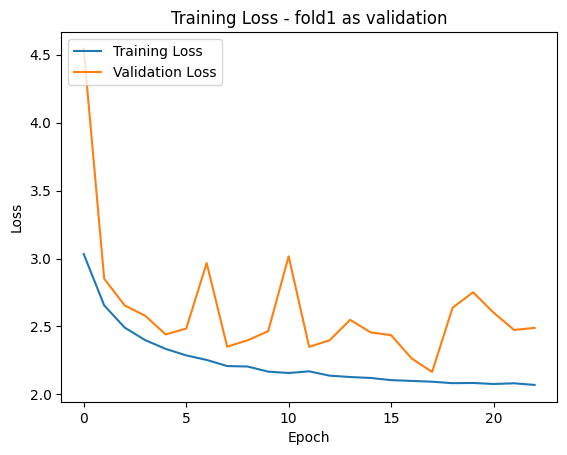

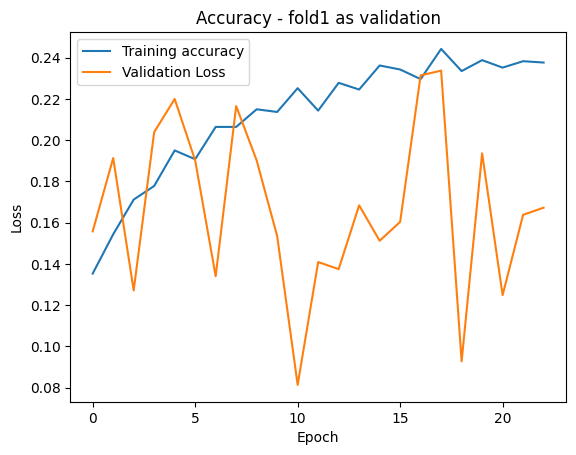

 10%|█         | 1/10 [12:48<1:55:20, 768.98s/it]

Training using fold2 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.01242, saving model to model.h5
61/61 - 55s - loss: 2.0935 - accuracy: 0.2322 - val_loss: 3.0124 - val_accuracy: 0.0923 - lr: 0.0010 - 55s/epoch - 896ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.01242 to 2.51236, saving model to model.h5
61/61 - 31s - loss: 2.0880 - accuracy: 0.2361 - val_loss: 2.5124 - val_accuracy: 0.1858 - lr: 0.0010 - 31s/epoch - 513ms/step
Epoch 3/30


 10%|█         | 1/10 [14:24<2:09:40, 864.45s/it]


KeyboardInterrupt: ignored

In [24]:
tensorflow.keras.backend.clear_session()
metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size =64
early_stop = 3 # early stoppping after 3 epochs with no improvement of test data

#objective to specify the objective to select the best models, and we use max_trials to specify the number of different models to try.
objective='val_loss'
max_trials = 8 # how many model variations to test?
max_trial_retrys = 3 # how many trials per variation? (same model could perform differently)



def model_k_cross(data):
    list_scores = []
    #Densenet121 model using pretrained weights from imagenet
    model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=input_shape[1:4], classes=10)

    x=model_d.output
    x= GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    x= Dense(1024,activation='relu')(x)
    x= Dense(512,activation='relu')(x)
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    preds=Dense(10,activation='softmax')(x) #FC-layer
    model=Model(inputs=model_d.input,outputs=preds)
    model.summary()


    #To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.
    for layer in model.layers[:-8]:
        layer.trainable=False
    for layer in model.layers[-8:]:
        layer.trainable=True



    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)


        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model. The ImageDataGenerator function performs real-time data augmentation over generated tensor image data batches in a loop.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
        datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)
        datagen.fit(X_train)

        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                       steps_per_epoch=X_train.shape[0] //128,
                       epochs=num_epoch,
                       verbose=2,
                       callbacks=[anne, checkpoint, EarlyStoppingCallback],
                       validation_data=(X_val, y_val))

        # Evaluation
        scores = model.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])


        # Plot training history - loss
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')


model_k_cross(data)

